In [1]:
from imblearn.over_sampling import SMOTENC
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import pandas as pd
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import bernoulli
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.manifold import MDS
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
from typing import Literal


numpyro.set_platform('cpu')
numpyro.set_host_device_count(16)

In [2]:
kaggle_submission = False
run_cv = True

# Logistic Regression with Tree-based Features Selection and Sampler

In this experiment,
I'll try perform uncorrelated features removal
and Bayesian logistic regression.

## Data

In [3]:
if kaggle_submission:
    train_path = '/kaggle/input/icr-identify-age-related-conditions/train.csv'
    test_path = '/kaggle/input/icr-identify-age-related-conditions/test.csv'
else:
    train_path = '../data/train.csv'
    test_path = '../data/test.csv'

train_df = pd.read_csv(train_path)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

In [4]:
test_df = pd.read_csv(test_path)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      5 non-null      object 
 1   AB      5 non-null      float64
 2   AF      5 non-null      float64
 3   AH      5 non-null      float64
 4   AM      5 non-null      float64
 5   AR      5 non-null      float64
 6   AX      5 non-null      float64
 7   AY      5 non-null      float64
 8   AZ      5 non-null      float64
 9   BC      5 non-null      float64
 10  BD      5 non-null      float64
 11  BN      5 non-null      float64
 12  BP      5 non-null      float64
 13  BQ      5 non-null      float64
 14  BR      5 non-null      float64
 15  BZ      5 non-null      float64
 16  CB      5 non-null      float64
 17  CC      5 non-null      float64
 18  CD      5 non-null      float64
 19  CF      5 non-null      float64
 20  CH      5 non-null      float64
 21  CL      5 non-null      float64
 22  CR    

### Data Preprocessing

In [5]:
imputer = SimpleImputer(strategy='median')
preprocessing = Pipeline([
    # ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

In [6]:
X_df = train_df.drop(columns=['Id', 'Class', 'EJ'])
y = train_df['Class']
ej = train_df['EJ'].astype('category')

X_df = pd.DataFrame(
    imputer.fit_transform(X_df),
    columns=X_df.columns,
    index=X_df.index)
y = y.values

### Interaction Terms

In [7]:
def create_interaction_terms_between(df: pd.DataFrame, features: list[str]):
    assert all(f in df.columns for f in features)

    interactions = dict()

    for i, fst in enumerate(features):
        for snd in features[i+1:]:
            interactions[f'{fst}*{snd}'] = df[fst] * df[snd]

    return pd.DataFrame(interactions)

### Quadratic Terms

In [8]:
def create_quadratic_terms(df: pd.DataFrame, features: list[str]):
    assert all(f in df.columns for f in features)

    return X_df[features].pow(2.).rename(columns={
        f: f'{f}^2' for f in features
    })

In [9]:
Xinteractions_df = create_interaction_terms_between(X_df, X_df.columns)
X2_df = create_quadratic_terms(X_df, X_df.columns)

Xtrain_df = pd.concat([X_df, Xinteractions_df, X2_df], axis=1)
# Xtrain_df['EJ'] = ej.cat.codes

### Correlations Removal

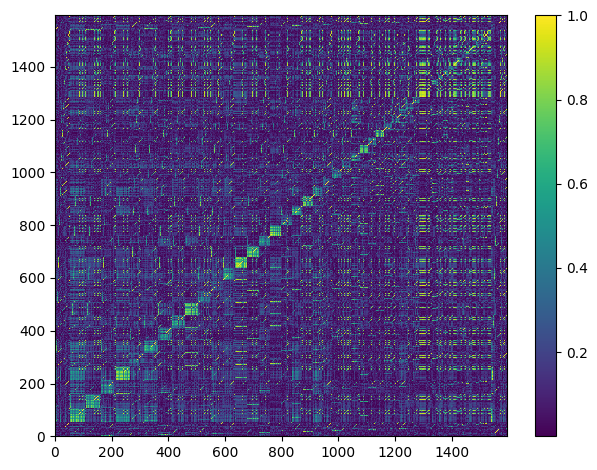

In [10]:
corr = Xtrain_df.corr('spearman')

fig, ax = plt.subplots()
cs = ax.pcolormesh(corr.abs())
fig.colorbar(cs, ax=ax)
fig.tight_layout()

/home/beekill/bin/mambaforge/envs/age/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


<Axes: >

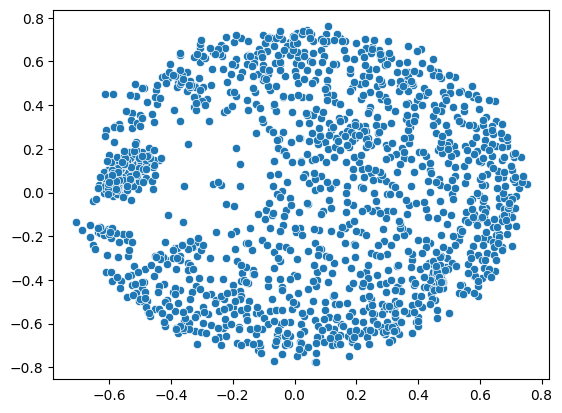

In [11]:
# Convert the correlation matrix into dissimilarity matrix,
# to be used with MDS.
distance = 1. - np.abs(corr)
mds = MDS(n_components=2, dissimilarity='precomputed')
embeddings = mds.fit_transform(distance)

# Show the results.
sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1])

Clusters: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

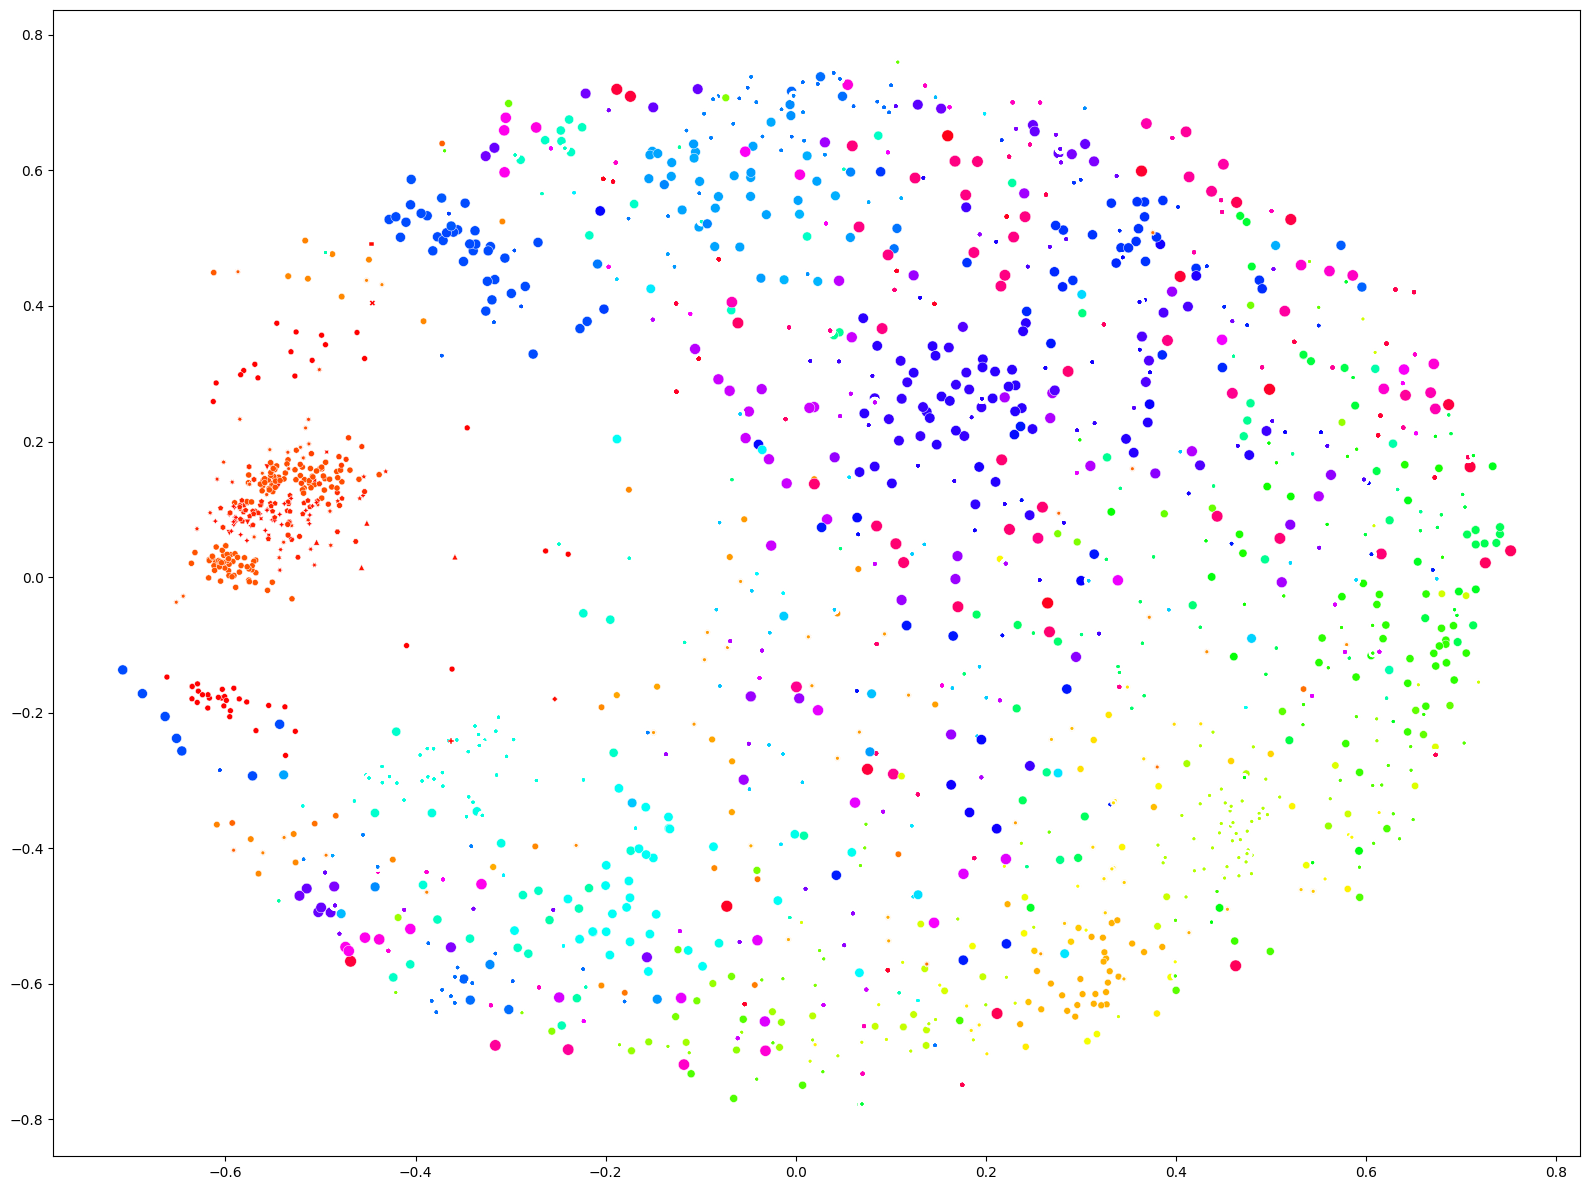

In [12]:
# Now, we can use clustering on the MDS's result
# to identify the clusters.
# clustering = DBSCAN(eps=0.1, min_samples=2, metric='precomputed')
# clusters = clustering.fit_predict(distance)
dist_linkage = hierarchy.ward(squareform(distance))
clusters = hierarchy.fcluster(dist_linkage, 0.3, criterion='distance')
unique_clusters = list(np.unique(clusters))
print(f'Clusters: {unique_clusters}')

# Plot the results.
fig, ax = plt.subplots(figsize=(16, 12))
sns.scatterplot(x=embeddings[:, 0],
                y=embeddings[:, 1],
                hue=clusters,
                style=clusters,
                size=clusters*100,
                palette='hsv',
                legend=False,
                ax=ax)
fig.tight_layout()

In [13]:
# Show the correlation in these clusters.
for cluster in unique_clusters:
    features_in_cluster = Xtrain_df.columns[clusters == cluster]
    X_in_cluster = Xtrain_df[features_in_cluster]
    corr_in_cluster = X_in_cluster.corr('spearman')
    corrs = 1 - squareform(1 - np.abs(corr_in_cluster))
    if len(features_in_cluster) > 1:
        print(f'{cluster=}, nb_features={len(features_in_cluster)}, '
              f'min={np.min(corrs)}, '
              f'max={np.max(corrs)}, mean={np.mean(corrs)}')
    else:
        print(f'{cluster=} has only 1 member.')

cluster=1, nb_features=47, min=0.6610663651465527, max=1.0, mean=0.8717003420133187
cluster=2 has only 1 member.
cluster=3 has only 1 member.
cluster=4 has only 1 member.
cluster=5 has only 1 member.
cluster=6, nb_features=33, min=0.853831339617906, max=1.0, mean=0.9147167073736575
cluster=7, nb_features=4, min=0.8476433715440829, max=0.9202469309244384, mean=0.8927511749537262
cluster=8, nb_features=4, min=0.8597206563102028, max=0.9462443710818355, mean=0.8991774649290855
cluster=9, nb_features=4, min=0.8537912907015649, max=0.9543980205027024, mean=0.902209830135333
cluster=10, nb_features=4, min=0.8893661261708603, max=0.9679051630992845, mean=0.927570034830481
cluster=11, nb_features=4, min=0.8697644756967174, max=0.958440050588756, mean=0.9072027141381702
cluster=12, nb_features=4, min=0.8761722038651139, max=0.9565649215041385, mean=0.9171461688673465
cluster=13, nb_features=38, min=0.8617061212929099, max=1.0, mean=0.925144595261086
cluster=14, nb_features=4, min=0.833351758802

Now, we can use these steps to extract the uncorrelated features.

In [14]:
def filter_in_uncorrelated_features(X_df: pd.DataFrame,
                                    correlation_threshold: float = 0.7):
    # Calculate Spearman's correlation, and then convert to
    # distances matrix.
    corr = X_df.corr('spearman')
    distances = 1. - corr.abs()

    # Perform clustering using Agglomerative Clustering.
    dist_linkage = hierarchy.ward(squareform(distances))
    clusters = hierarchy.fcluster(dist_linkage,
                                  1. - correlation_threshold,
                                  criterion='distance')

    # Choose a feature from each cluster.
    features = []
    for cluster in np.unique(clusters):
        features_in_cluster = X_df.columns[cluster == clusters]

        # TODO: Here, we use the first feature,
        # but it can be other choices.
        chosen_feature = features_in_cluster[0]
        features.append(chosen_feature)

    # Return a new dataframe with the chosen features.
    return X_df[features]

## Model
### Neural Network Classifier

In [15]:
class NNClassifier(nn.Module):
    def __init__(self, input_shape: int) -> None:
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_shape, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.LayerNorm(1024),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.LayerNorm(512),

            nn.Linear(512, 64),
            # nn.Tanh(),
        )

        self.output = nn.Sequential(
            # nn.Dropout(),
            nn.LayerNorm(64),
            # nn.Dropout(),
            nn.Linear(64, 1),
        )

    def forward(self, x, *,
                mode: Literal['encoder', 'output', 'full'] = 'full',
                logit: bool = False):
        if mode == 'encoder':
            return self.encoder(x)
        elif mode == 'output':
            x = self.output(x)
            return x if logit else torch.sigmoid(x)
        elif mode == 'full':
            x = self.encoder(x)
            x = self.output(x)
            return x if logit else torch.sigmoid(x)

        raise ValueError(f'Unknown mode={mode}')


def create_training_and_evaluation_step(
        model: nn.Module,
        lr=1e-3,
        weight_decay=1e-5,
        regularization_weight=1e-2):

    loss_fn = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(
        model.parameters(), lr=lr, weight_decay=weight_decay)

    # Init weights before training.
    def init_weights(m: nn.Module):
        strategy_fn = nn.init.xavier_normal_
        if type(m) in [nn.Linear, nn.LazyLinear]:
            strategy_fn(m.weight)

    model.apply(lambda m: init_weights(m))

    def encoder_regularization_loss(x: torch.Tensor):
        """
        Calculate regularization loss of the encoder's output.

        x should have shape (nb_batches, nb_features)
        """
        # First, the output should be normally distributed.
        l1 = torch.mean(torch.sum(x**2, axis=1))

        # Second, features should not be correlated.
        cov = torch.t(x) @ x
        cov = cov - torch.diag(torch.diag(cov))
        l2 = torch.mean(torch.abs(cov))

        return l1 + l2

    def train_step(dataloader: DataLoader, *,
                   device: str, epoch: int, progress: bool = True,
                   train_noise: float = 0.0):
        model.train()

        train_loss = 0
        regularization_loss = 0

        num_batches = len(dataloader)
        bar = (tqdm(
            enumerate(dataloader), total=num_batches, desc=f'Epoch {epoch}')
            if progress
            else enumerate(dataloader))
        for i, (X, y) in bar:
            X, y = X.to(device), y.to(device)

            # Add noise to the training.
            X = X + train_noise * torch.rand_like(X)

            # Make prediction and calculate loss.
            encoder_output = model(X, mode='encoder')
            pred = model(encoder_output, mode='output', logit=True)

            # Losses.
            encoder_loss = encoder_regularization_loss(encoder_output)
            classification_loss = loss_fn(pred, y)

            loss = regularization_weight * encoder_loss + classification_loss
            regularization_loss += encoder_loss.item()
            train_loss += loss.item()

            # Back-propagation step.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Show the MSE.
            if progress:
                bar.set_postfix_str(
                    f'Loss: {(train_loss / (i + 1)):.4f}'
                    f'- Encoder loss: {regularization_loss / (i + 1):.4f}')

        return train_loss / num_batches, regularization_loss / num_batches

    def evaluate_step(dataloader: DataLoader, device: str):
        num_batches = len(dataloader)
        model.eval()

        test_loss = 0
        regularization_loss = 0

        with torch.no_grad():
            for i, (X, y) in enumerate(dataloader):
                X, y = X.to(device), y.to(device)

                encoder_output = model(X, mode='encoder')
                pred = model(encoder_output, mode='output', logit=True)

                encoder_loss = encoder_regularization_loss(
                    encoder_output).item()
                regularization_loss += encoder_loss
                test_loss += (loss_fn(pred, y).item()
                              + regularization_weight * encoder_loss)

        test_loss /= num_batches
        return test_loss, regularization_loss / num_batches

    return train_step, evaluate_step


def train(model: nn.Module,
          *,
          train_ds: DataLoader,
          val_ds: DataLoader,
          epochs: int,
          train_noise: float = 0.0,
          early_stopping_patience: int = 100,
          device: str = 'cpu',
          lr: float = 1e-3,
          weight_decay: float = 1e-2,
          regularization_weight: float = 1.0):
    def save_checkpoint(model, path):
        torch.save(model.state_dict(), path)

    def load_checkpoint(model, path):
        model.load_state_dict(torch.load(path))
        return model

    model = model.to(device)

    train_step, val_step = create_training_and_evaluation_step(
        model,
        lr=lr,
        weight_decay=weight_decay,
        regularization_weight=regularization_weight)
    train_losses = []
    val_losses = []

    tmp_path = 'tmp_autoencoder.pth'

    patience = 0
    bar = tqdm(range(epochs), total=epochs, desc='Training')
    for epoch in bar:
        train_loss, train_regu_loss = train_step(
            train_ds, device=device, epoch=epoch, progress=False,
            train_noise=train_noise)
        train_losses.append(train_loss)

        val_loss, val_regu_loss = val_step(val_ds, device)
        val_losses.append(val_loss)

        bar.set_postfix_str(
            f'Train: {train_loss:.4f} - Val: {val_loss:.4f}'
            f'-Train Reg: {train_regu_loss:.4f} - Val Reg:{val_regu_loss:.4f}')

        patience += 1
        if val_loss <= np.min(val_losses):
            save_checkpoint(model, tmp_path)
            patience = 0
        else:
            if patience > early_stopping_patience:
                print(f'The validation does not improve for the last {patience} epochs. '
                      'Early stopping!')
                break

    # Best validation score and corresponding train score.
    best_val_idx = np.argmin(val_losses)
    print(
        f'Train: {train_losses[best_val_idx]:.4f} '
        f'- Val: {val_losses[best_val_idx]:.4f} at epoch {best_val_idx}.')

    # Restore the best model.
    print('Restore the best model.')
    return (load_checkpoint(model, tmp_path),
            dict(train_loss=train_losses,
                 val_loss=val_losses,
                 best_epoch=best_val_idx))

### Features Selection

In [16]:
def select_important_features(
        X, y, *, n_estimators: int = 50, important_thresholds: float = 0.5):
    model = ExtraTreesClassifier(n_estimators=n_estimators)
    model.fit(X, y)
    print(model.feature_importances_)
    selector = SelectFromModel(
        model,
        prefit=True,
        threshold=important_thresholds)
    x = selector.fit_transform(X, y)
    return pd.DataFrame(x, columns=selector.get_feature_names_out())

### Oversampling

In [17]:
def sampling(X, y):
    ros = SMOTENC(['ej'], sampling_strategy='all', random_state=0)
    columns = X.columns
    x, y = ros.fit_resample(X, y)
    return pd.DataFrame(x, columns=columns), y

### Cross Validation


-- Fold # 1/10 - Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1891 - Val: 0.1946 at epoch 300.
Restore the best model.


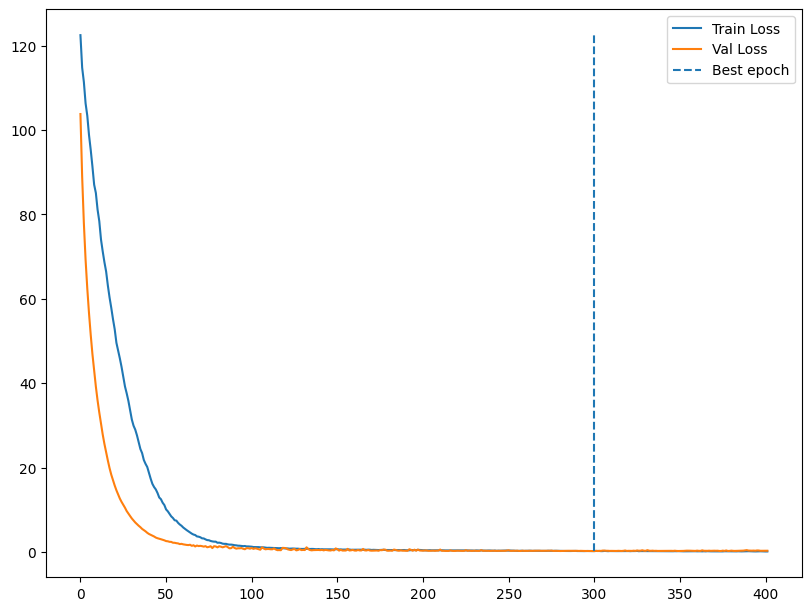

(20000, 555)
(20000,)
Train - f1=0.9896 recall=0.9794 precision=1.0000 log-loss=0.0720 opt-log-loss=0.0537
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.1872 opt-log-loss=0.1415

-- Fold # 1/10 - Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1994 - Val: 0.2465 at epoch 316.
Restore the best model.


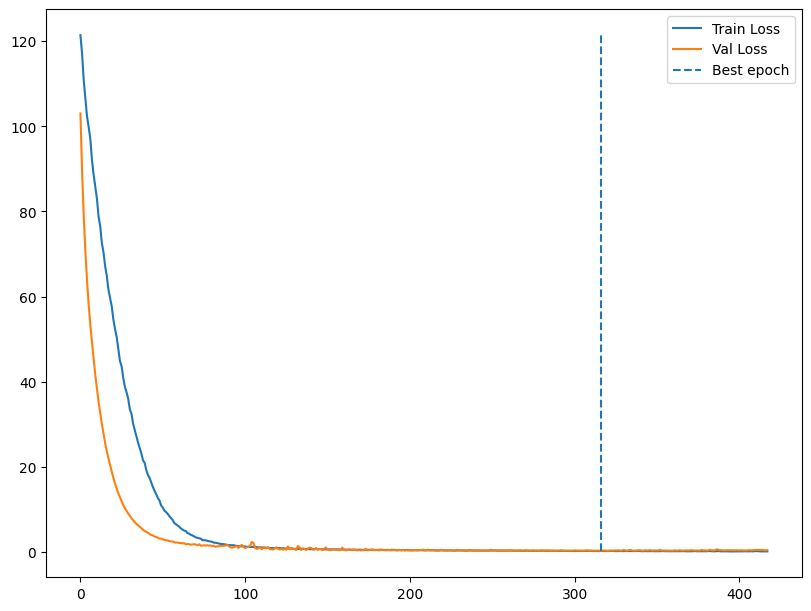

(20000, 555)
(20000,)
Train - f1=0.9796 recall=0.9897 precision=0.9697 log-loss=0.0284 opt-log-loss=0.0421
(20000, 62)
(20000,)
Test  - f1=0.8696 recall=0.9091 precision=0.8333 log-loss=0.2102 opt-log-loss=0.1907

-- Fold # 1/10 - Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2173 - Val: 0.2787 at epoch 282.
Restore the best model.


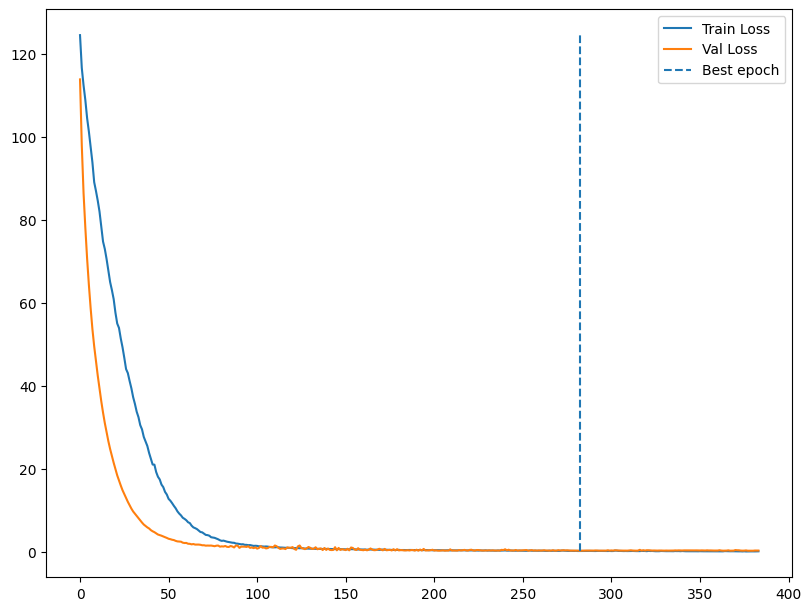

(20000, 555)
(20000,)
Train - f1=0.9741 recall=0.9691 precision=0.9792 log-loss=0.0564 opt-log-loss=0.0478
(20000, 62)
(20000,)
Test  - f1=0.7619 recall=0.7273 precision=0.8000 log-loss=0.3582 opt-log-loss=0.2467

-- Fold # 1/10 - Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1916 - Val: 0.2223 at epoch 331.
Restore the best model.


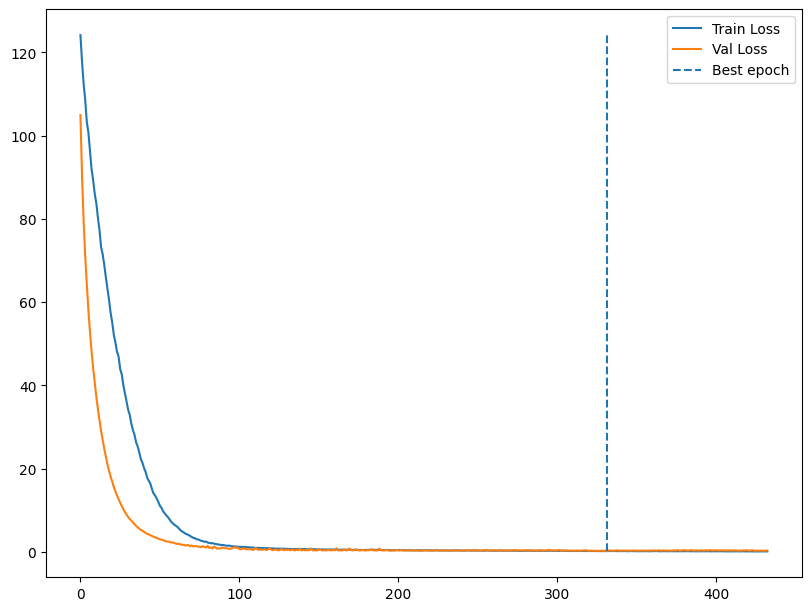

(20000, 555)
(20000,)
Train - f1=0.9897 recall=0.9897 precision=0.9897 log-loss=0.0235 opt-log-loss=0.0295
(20000, 62)
(20000,)
Test  - f1=0.7826 recall=0.8182 precision=0.7500 log-loss=0.1973 opt-log-loss=0.1718

-- Fold # 1/10 - Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2459 - Val: 0.2464 at epoch 269.
Restore the best model.


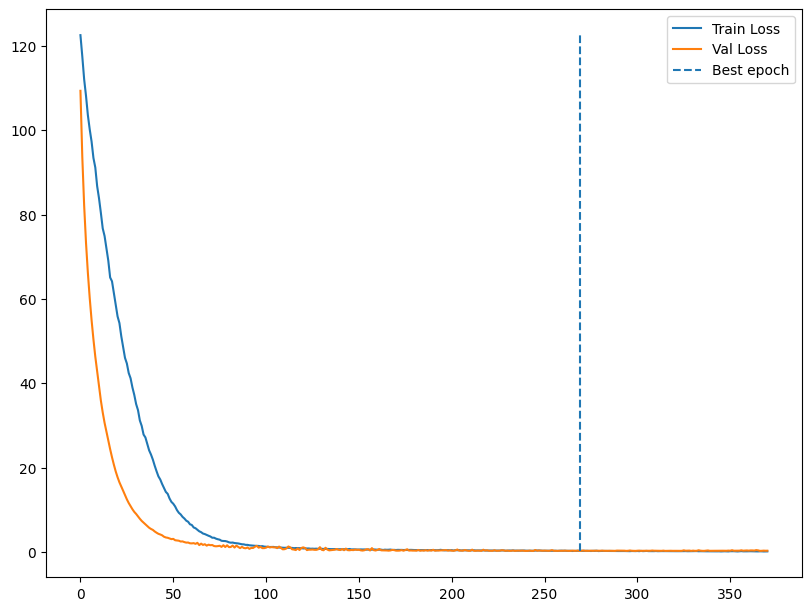

(20000, 555)
(20000,)
Train - f1=0.9738 recall=0.9588 precision=0.9894 log-loss=0.0816 opt-log-loss=0.0564
(20000, 62)
(20000,)
Test  - f1=0.7826 recall=0.8182 precision=0.7500 log-loss=0.2436 opt-log-loss=0.1805

-- Fold # 1/10 - Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.0738 - Val: 0.2349 at epoch 456.
Restore the best model.


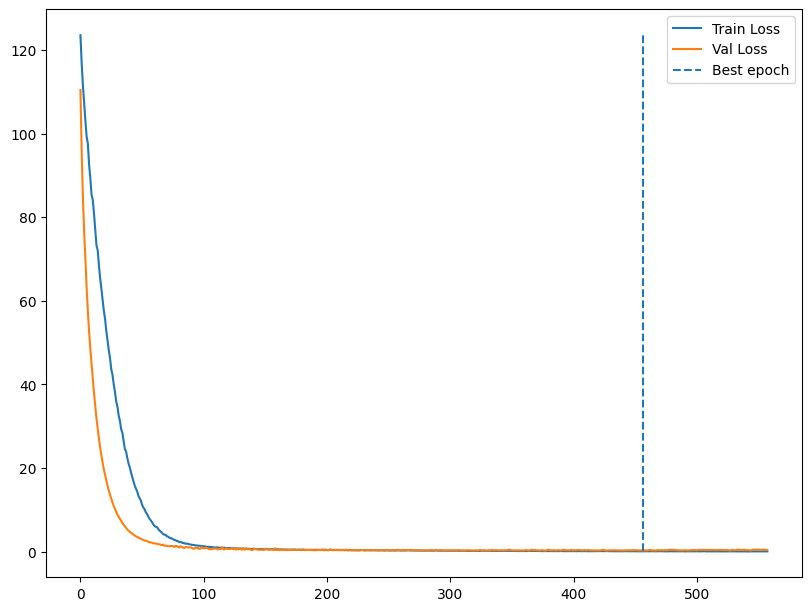

(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0042 opt-log-loss=0.0071
(20000, 62)
(20000,)
Test  - f1=0.8571 recall=0.8182 precision=0.9000 log-loss=0.2664 opt-log-loss=0.2003

-- Fold # 1/10 - Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2245 - Val: 0.2423 at epoch 276.
Restore the best model.


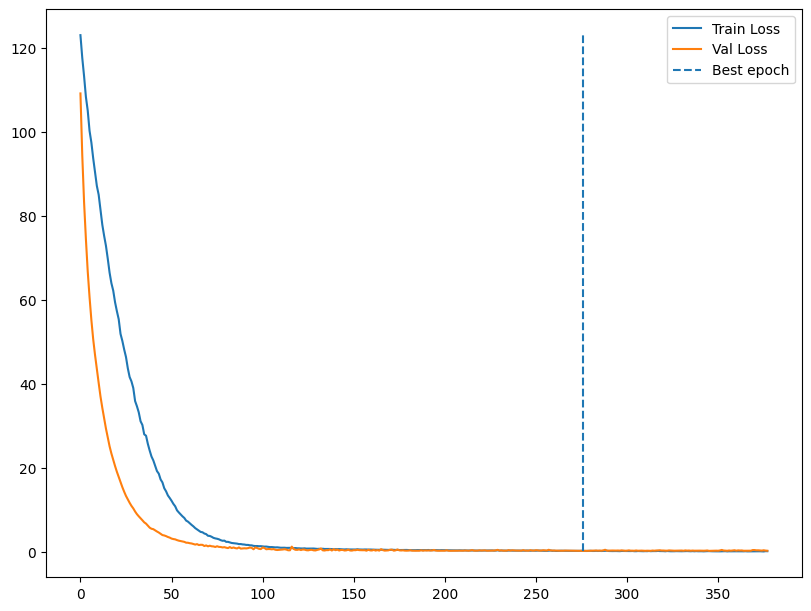

(20000, 555)
(20000,)
Train - f1=0.9794 recall=0.9794 precision=0.9794 log-loss=0.0635 opt-log-loss=0.0460
(20000, 62)
(20000,)
Test  - f1=0.6667 recall=0.5455 precision=0.8571 log-loss=0.2908 opt-log-loss=0.1793

-- Fold # 1/10 - Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2937 - Val: 0.3095 at epoch 256.
Restore the best model.


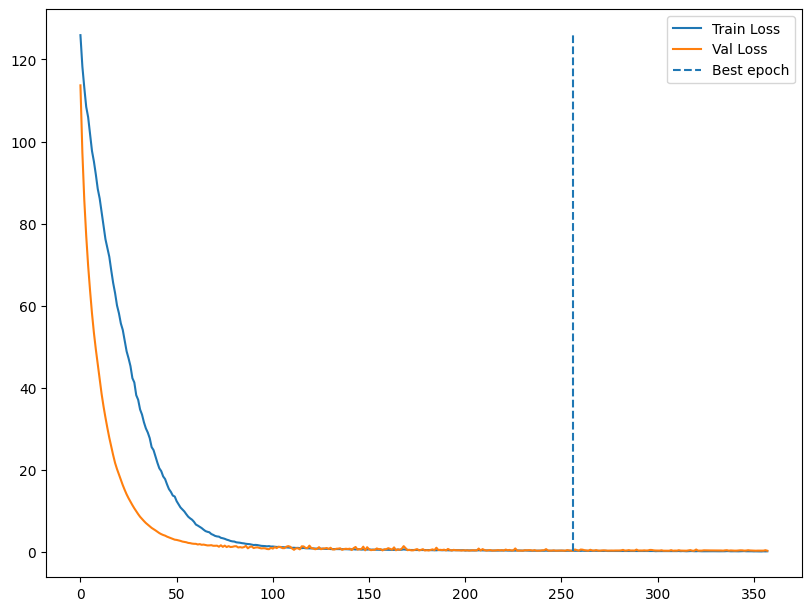

(20000, 555)
(20000,)
Train - f1=0.9340 recall=0.9485 precision=0.9200 log-loss=0.1075 opt-log-loss=0.0904
(20000, 62)
(20000,)
Test  - f1=0.7619 recall=0.7273 precision=0.8000 log-loss=0.4477 opt-log-loss=0.3349

-- Fold # 1/10 - Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2822 - Val: 0.2733 at epoch 249.
Restore the best model.


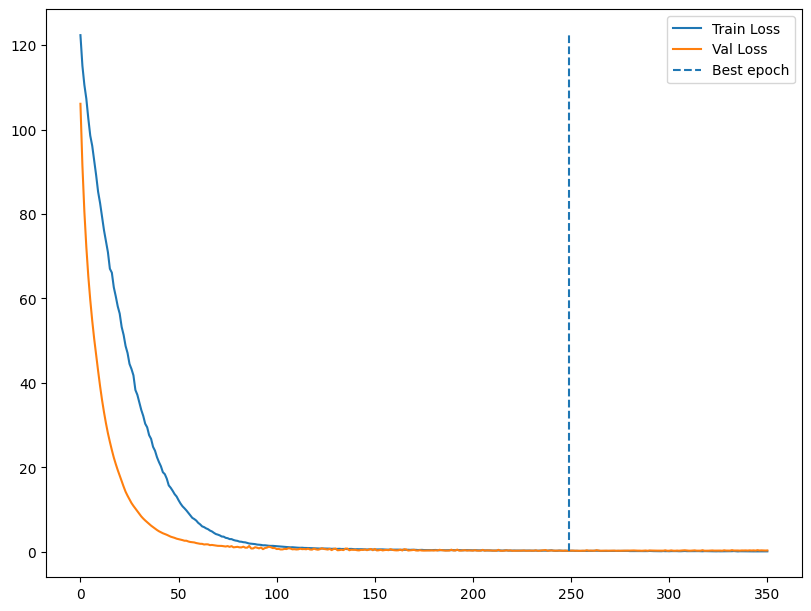

(20000, 555)
(20000,)
Train - f1=0.9442 recall=0.9588 precision=0.9300 log-loss=0.1161 opt-log-loss=0.0979
(20000, 62)
(20000,)
Test  - f1=0.7368 recall=0.6364 precision=0.8750 log-loss=0.3632 opt-log-loss=0.2330

-- Fold # 1/10 - Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2066 - Val: 0.2374 at epoch 273.
Restore the best model.


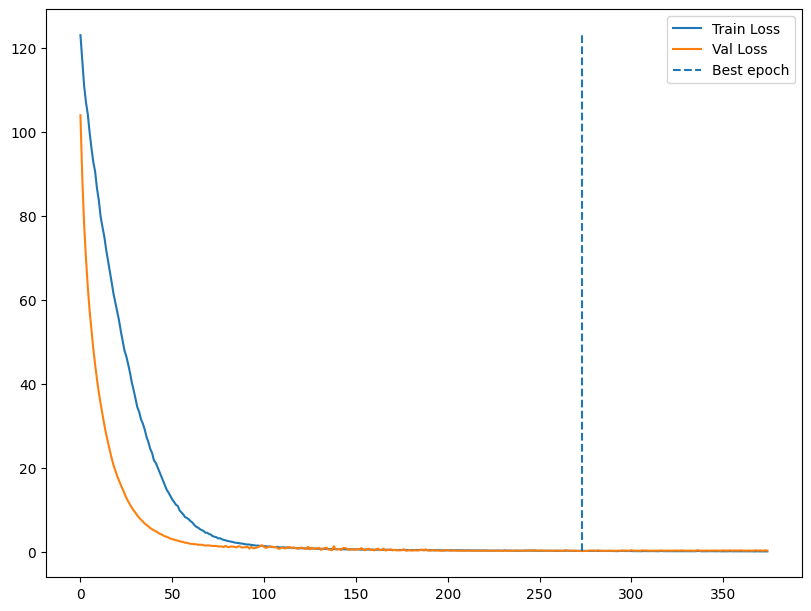

(20000, 555)
(20000,)
Train - f1=0.9741 recall=0.9691 precision=0.9792 log-loss=0.0653 opt-log-loss=0.0611
(20000, 62)
(20000,)
Test  - f1=0.8571 recall=0.8182 precision=0.9000 log-loss=0.2768 opt-log-loss=0.1886

-- Fold # 2/10 - Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1807 - Val: 0.2787 at epoch 315.
Restore the best model.


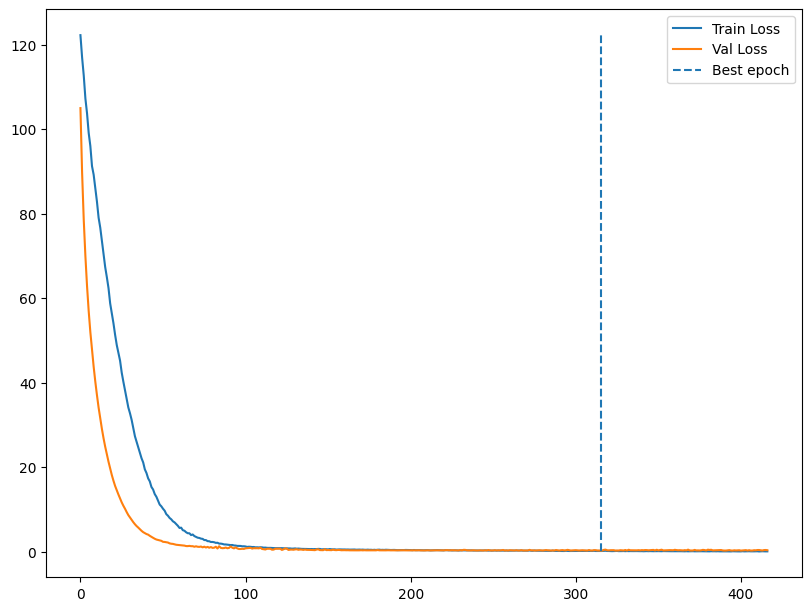

(20000, 555)
(20000,)
Train - f1=0.9604 recall=1.0000 precision=0.9238 log-loss=0.0298 opt-log-loss=0.0599
(20000, 62)
(20000,)
Test  - f1=0.8333 recall=0.9091 precision=0.7692 log-loss=0.2952 opt-log-loss=0.2599

-- Fold # 2/10 - Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2999 - Val: 0.2697 at epoch 248.
Restore the best model.


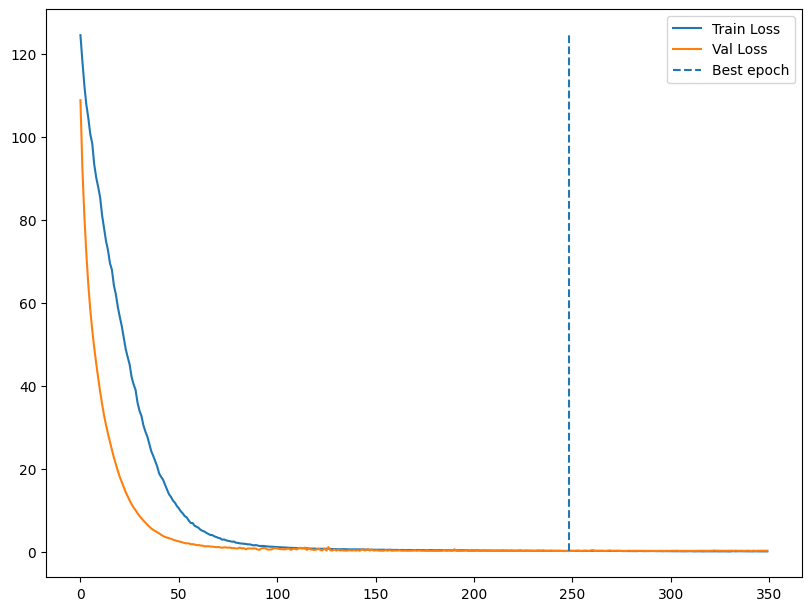

(20000, 555)
(20000,)
Train - f1=0.9216 recall=0.9691 precision=0.8785 log-loss=0.0900 opt-log-loss=0.1168
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.3258 opt-log-loss=0.2780

-- Fold # 2/10 - Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1972 - Val: 0.2570 at epoch 290.
Restore the best model.


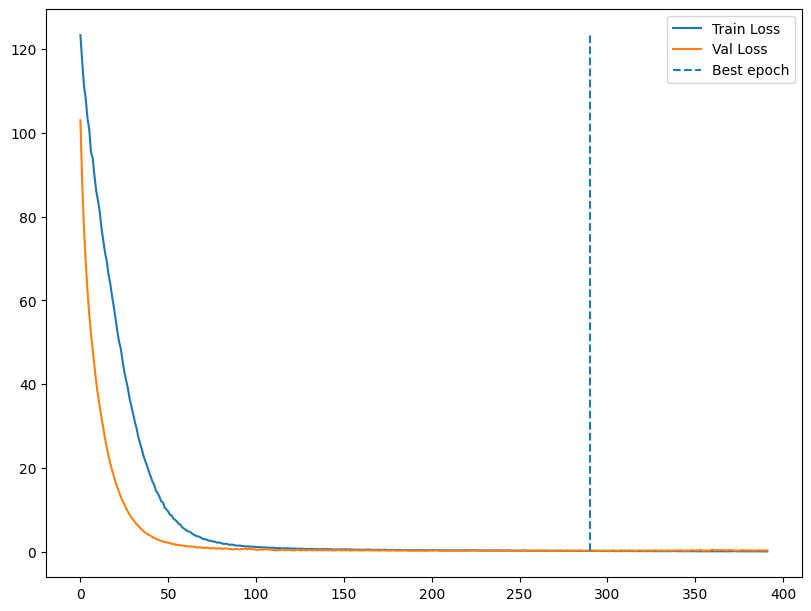

(20000, 555)
(20000,)
Train - f1=0.9798 recall=1.0000 precision=0.9604 log-loss=0.0374 opt-log-loss=0.0504
(20000, 62)
(20000,)
Test  - f1=0.8571 recall=0.8182 precision=0.9000 log-loss=0.3200 opt-log-loss=0.2346

-- Fold # 2/10 - Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2373 - Val: 0.2682 at epoch 270.
Restore the best model.


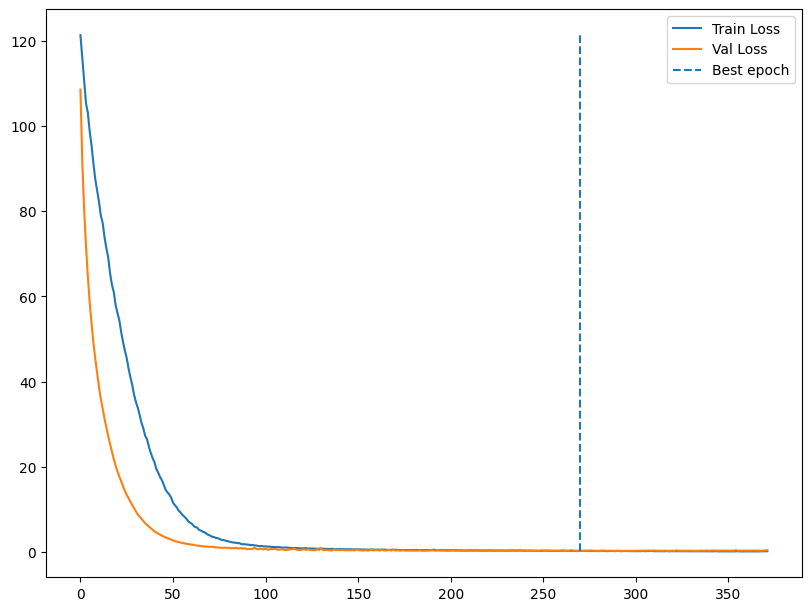

(20000, 555)
(20000,)
Train - f1=0.9412 recall=0.9897 precision=0.8972 log-loss=0.0584 opt-log-loss=0.0853
(20000, 62)
(20000,)
Test  - f1=0.7826 recall=0.8182 precision=0.7500 log-loss=0.2846 opt-log-loss=0.2360

-- Fold # 2/10 - Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3475 - Val: 0.2686 at epoch 213.
Restore the best model.


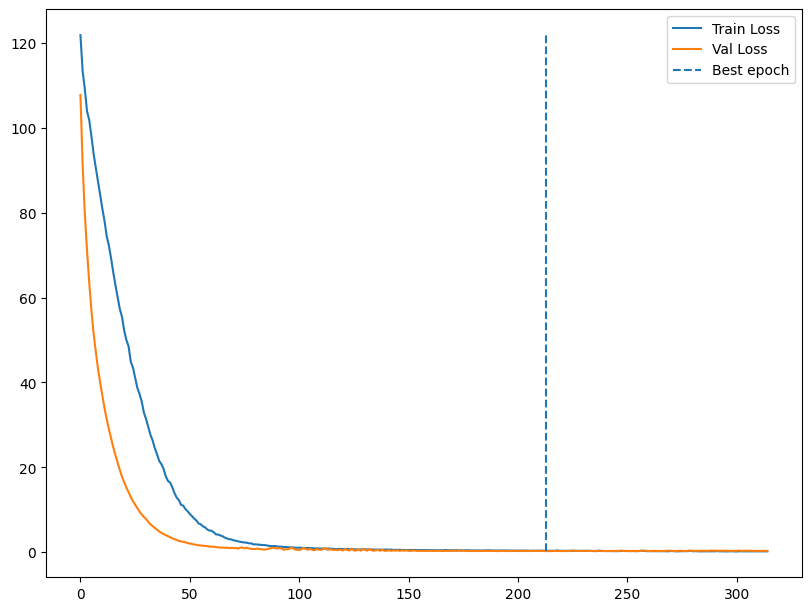

(20000, 555)
(20000,)
Train - f1=0.8920 recall=0.9794 precision=0.8190 log-loss=0.1050 opt-log-loss=0.1269
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.3066 opt-log-loss=0.2441

-- Fold # 2/10 - Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2933 - Val: 0.2347 at epoch 233.
Restore the best model.


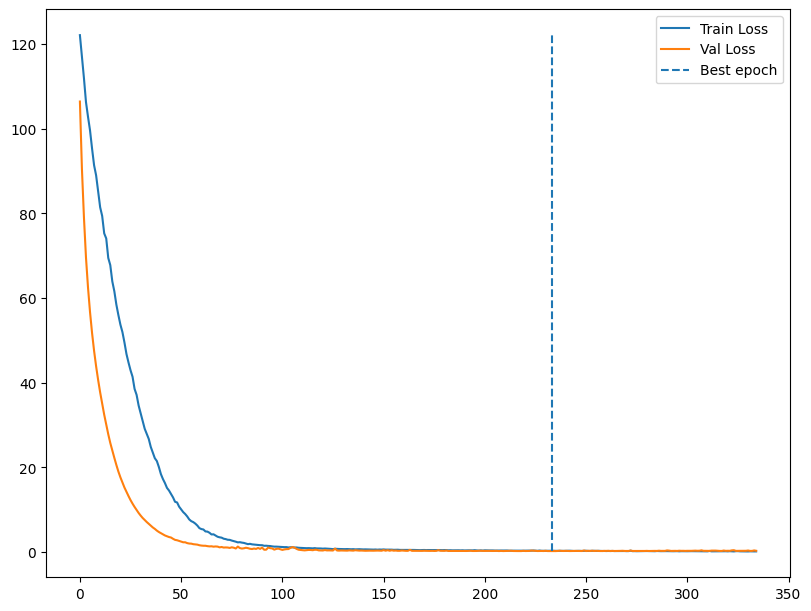

(20000, 555)
(20000,)
Train - f1=0.9645 recall=0.9794 precision=0.9500 log-loss=0.0904 opt-log-loss=0.0887
(20000, 62)
(20000,)
Test  - f1=0.9091 recall=0.9091 precision=0.9091 log-loss=0.3067 opt-log-loss=0.2229

-- Fold # 2/10 - Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1994 - Val: 0.2823 at epoch 301.
Restore the best model.


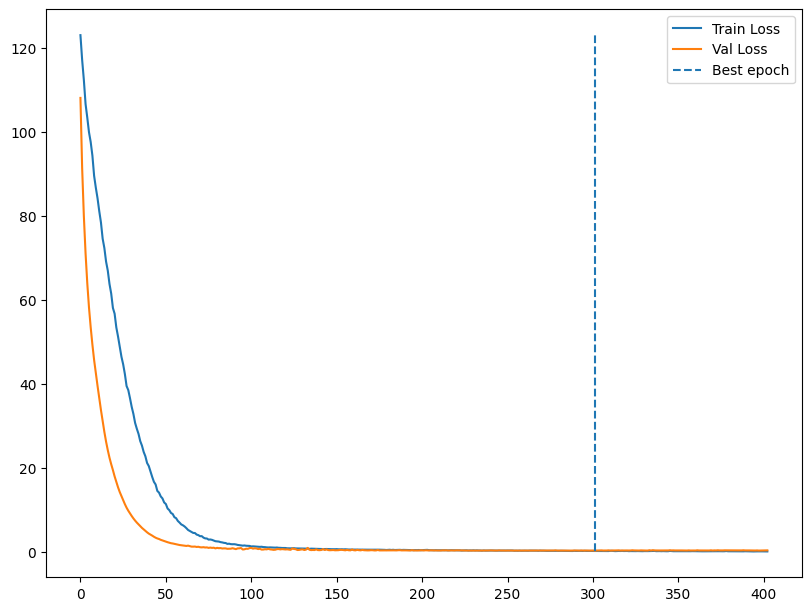

(20000, 555)
(20000,)
Train - f1=0.9648 recall=0.9897 precision=0.9412 log-loss=0.0348 opt-log-loss=0.0593
(20000, 62)
(20000,)
Test  - f1=0.7500 recall=0.8182 precision=0.6923 log-loss=0.3496 opt-log-loss=0.3148

-- Fold # 2/10 - Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3687 - Val: 0.3044 at epoch 210.
Restore the best model.


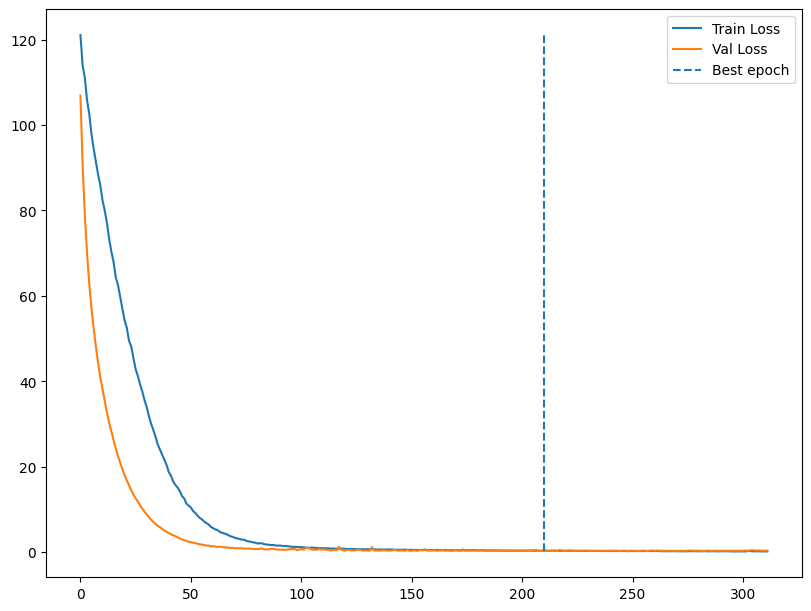

(20000, 555)
(20000,)
Train - f1=0.8756 recall=0.9794 precision=0.7917 log-loss=0.1029 opt-log-loss=0.1453
(20000, 62)
(20000,)
Test  - f1=0.7826 recall=0.8182 precision=0.7500 log-loss=0.3705 opt-log-loss=0.3122

-- Fold # 2/10 - Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4077 - Val: 0.2904 at epoch 193.
Restore the best model.


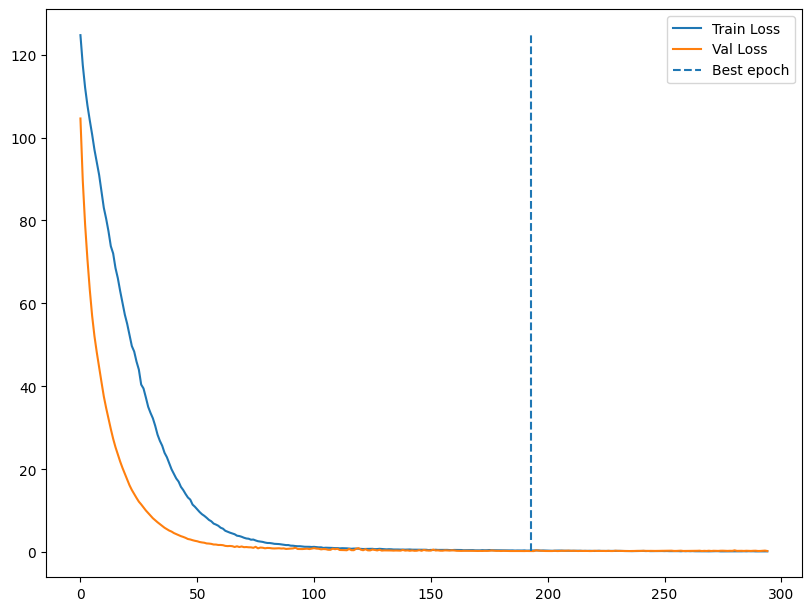

(20000, 555)
(20000,)
Train - f1=0.8288 recall=0.9485 precision=0.7360 log-loss=0.1794 opt-log-loss=0.1928
(20000, 62)
(20000,)
Test  - f1=0.7619 recall=0.7273 precision=0.8000 log-loss=0.3507 opt-log-loss=0.2848

-- Fold # 2/10 - Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4318 - Val: 0.3164 at epoch 187.
Restore the best model.


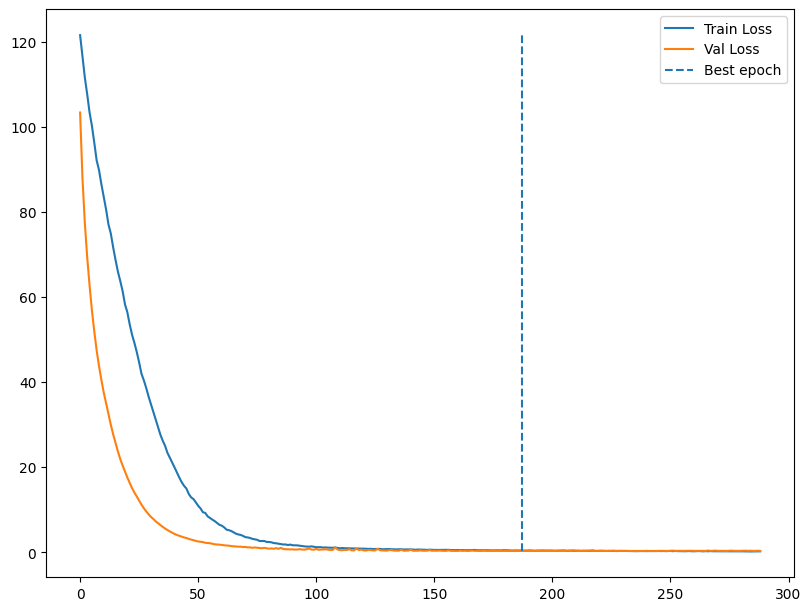

(20000, 555)
(20000,)
Train - f1=0.8768 recall=0.9175 precision=0.8396 log-loss=0.1798 opt-log-loss=0.1702
(20000, 62)
(20000,)
Test  - f1=0.7619 recall=0.7273 precision=0.8000 log-loss=0.3965 opt-log-loss=0.2871

-- Fold # 3/10 - Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2053 - Val: 0.2836 at epoch 312.
Restore the best model.


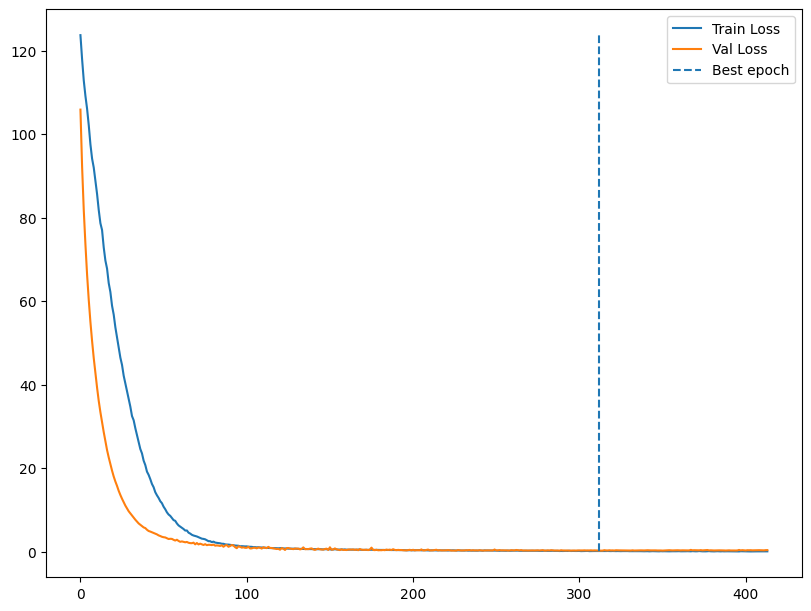

(20000, 555)
(20000,)
Train - f1=0.9897 recall=0.9897 precision=0.9897 log-loss=0.0402 opt-log-loss=0.0397
(20000, 62)
(20000,)
Test  - f1=0.6667 recall=0.6364 precision=0.7000 log-loss=0.3823 opt-log-loss=0.2780

-- Fold # 3/10 - Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1100 - Val: 0.2806 at epoch 368.
Restore the best model.


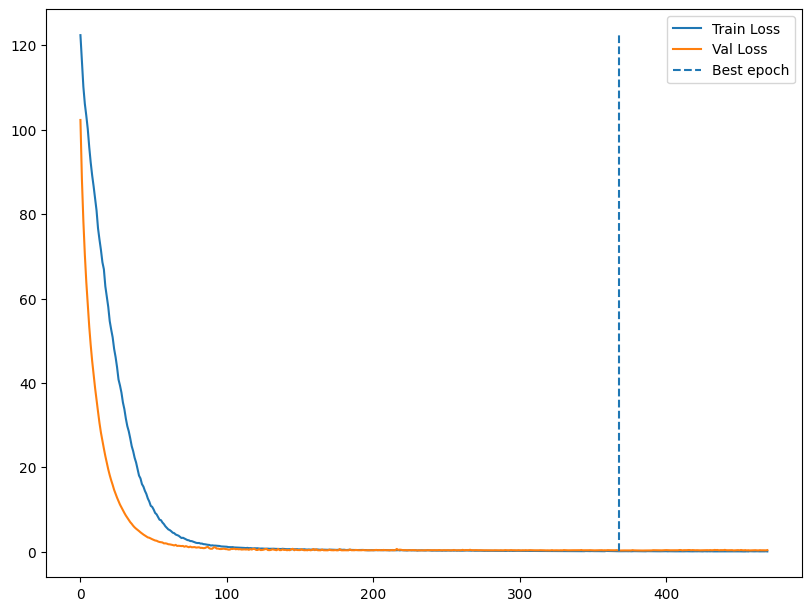

(20000, 555)
(20000,)
Train - f1=0.9948 recall=0.9897 precision=1.0000 log-loss=0.0309 opt-log-loss=0.0145
(20000, 62)
(20000,)
Test  - f1=0.7826 recall=0.8182 precision=0.7500 log-loss=0.3362 opt-log-loss=0.2616

-- Fold # 3/10 - Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2265 - Val: 0.2529 at epoch 282.
Restore the best model.


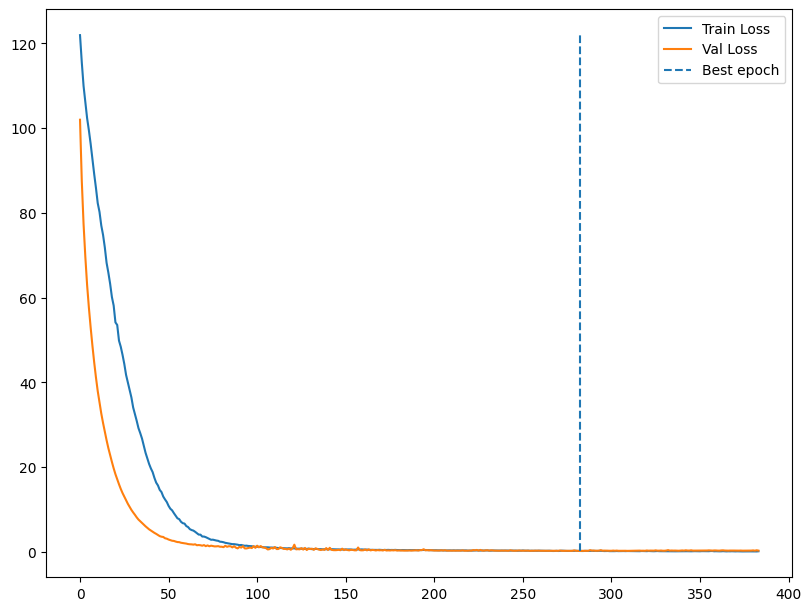

(20000, 555)
(20000,)
Train - f1=0.9796 recall=0.9897 precision=0.9697 log-loss=0.0611 opt-log-loss=0.0546
(20000, 62)
(20000,)
Test  - f1=0.8000 recall=0.9091 precision=0.7143 log-loss=0.2134 opt-log-loss=0.1810

-- Fold # 3/10 - Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.0524 - Val: 0.2026 at epoch 508.
Restore the best model.


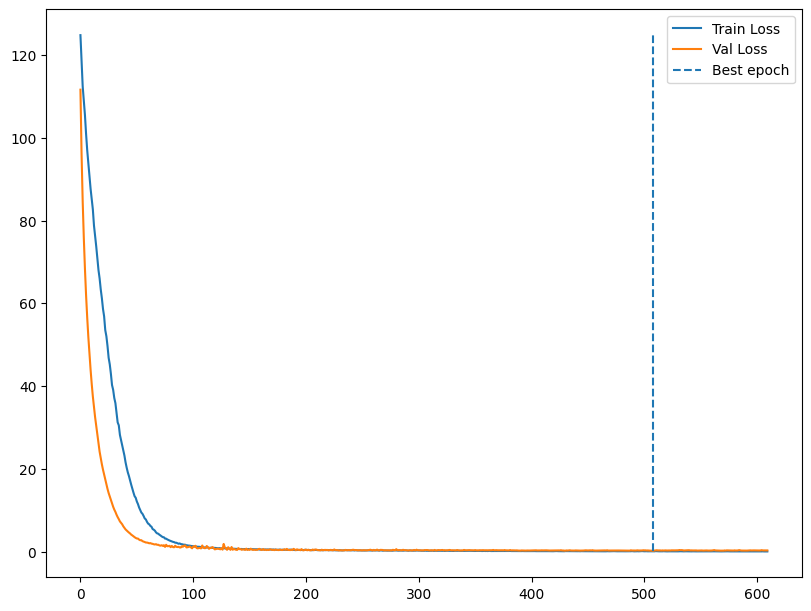

(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0043 opt-log-loss=0.0041
(20000, 62)
(20000,)
Test  - f1=0.8696 recall=0.9091 precision=0.8333 log-loss=0.2656 opt-log-loss=0.2161

-- Fold # 3/10 - Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2419 - Val: 0.3505 at epoch 280.
Restore the best model.


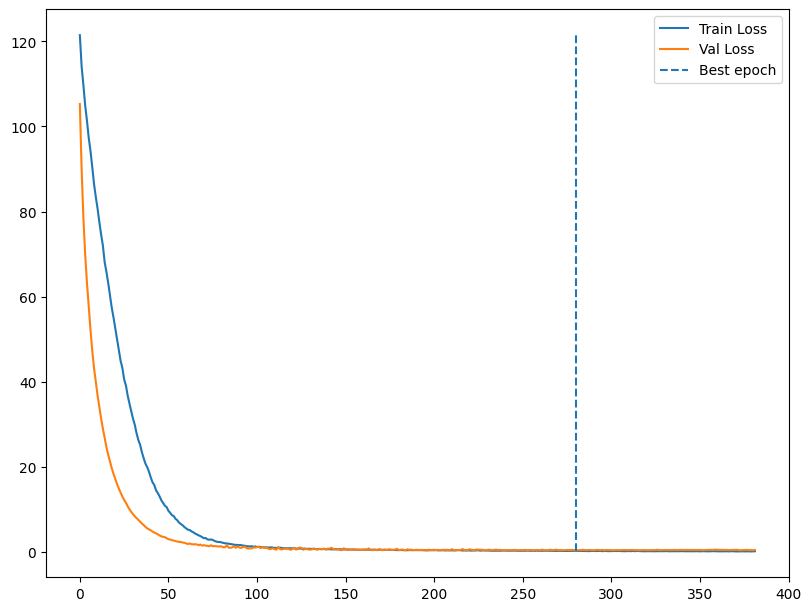

(20000, 555)
(20000,)
Train - f1=0.9634 recall=0.9485 precision=0.9787 log-loss=0.1096 opt-log-loss=0.0545
(20000, 62)
(20000,)
Test  - f1=0.6364 recall=0.6364 precision=0.6364 log-loss=0.5159 opt-log-loss=0.3708

-- Fold # 3/10 - Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1136 - Val: 0.3313 at epoch 419.
Restore the best model.


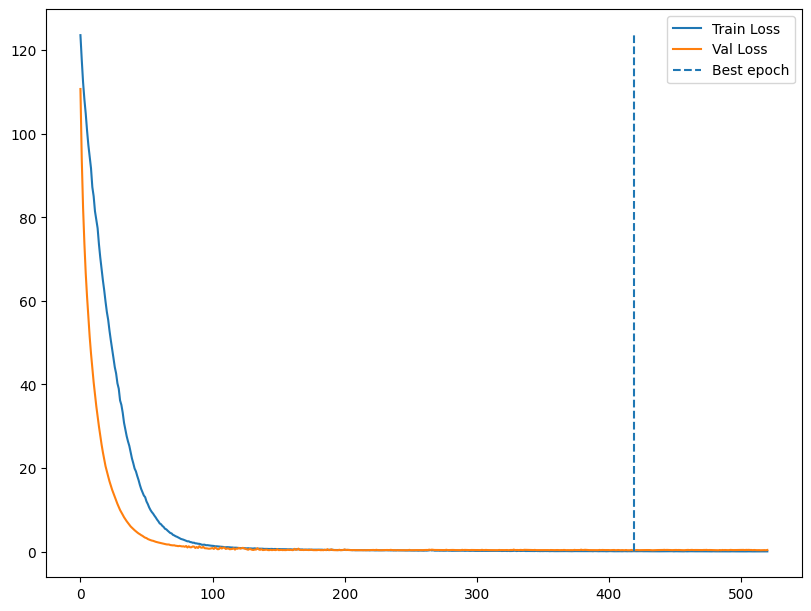

(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0193 opt-log-loss=0.0150
(20000, 62)
(20000,)
Test  - f1=0.7826 recall=0.8182 precision=0.7500 log-loss=0.3753 opt-log-loss=0.3515

-- Fold # 3/10 - Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3013 - Val: 0.3095 at epoch 232.
Restore the best model.


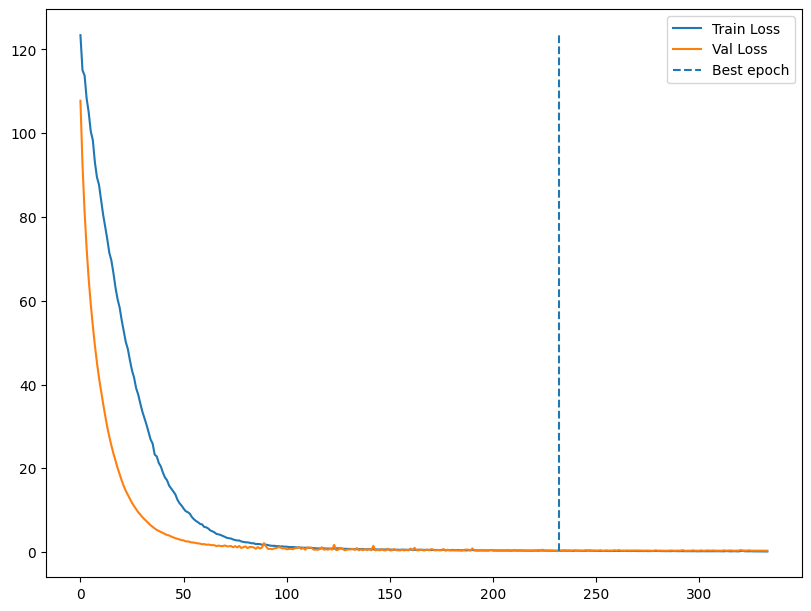

(20000, 555)
(20000,)
Train - f1=0.9485 recall=0.9485 precision=0.9485 log-loss=0.1152 opt-log-loss=0.1101
(20000, 62)
(20000,)
Test  - f1=0.7273 recall=0.7273 precision=0.7273 log-loss=0.4167 opt-log-loss=0.3080

-- Fold # 3/10 - Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3153 - Val: 0.3523 at epoch 231.
Restore the best model.


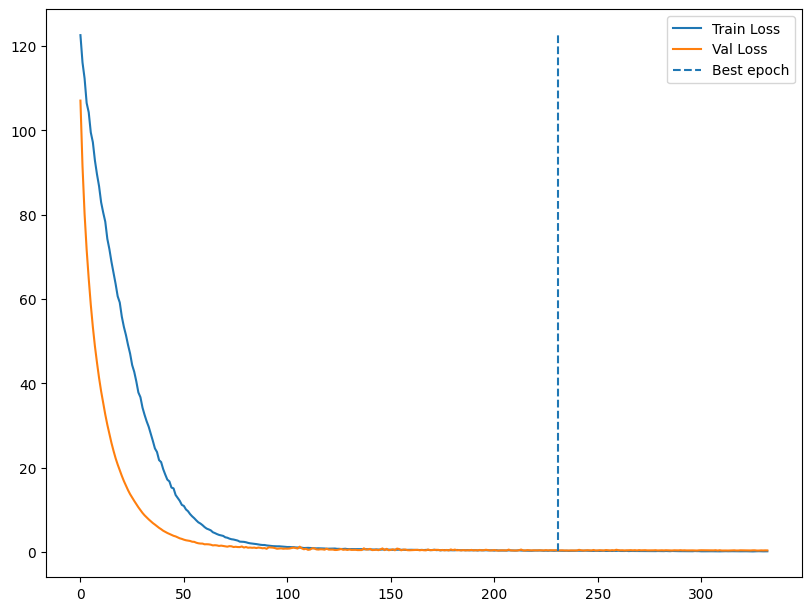

(20000, 555)
(20000,)
Train - f1=0.9400 recall=0.9691 precision=0.9126 log-loss=0.1297 opt-log-loss=0.1131
(20000, 62)
(20000,)
Test  - f1=0.6957 recall=0.7273 precision=0.6667 log-loss=0.4436 opt-log-loss=0.3377

-- Fold # 3/10 - Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1457 - Val: 0.2600 at epoch 361.
Restore the best model.


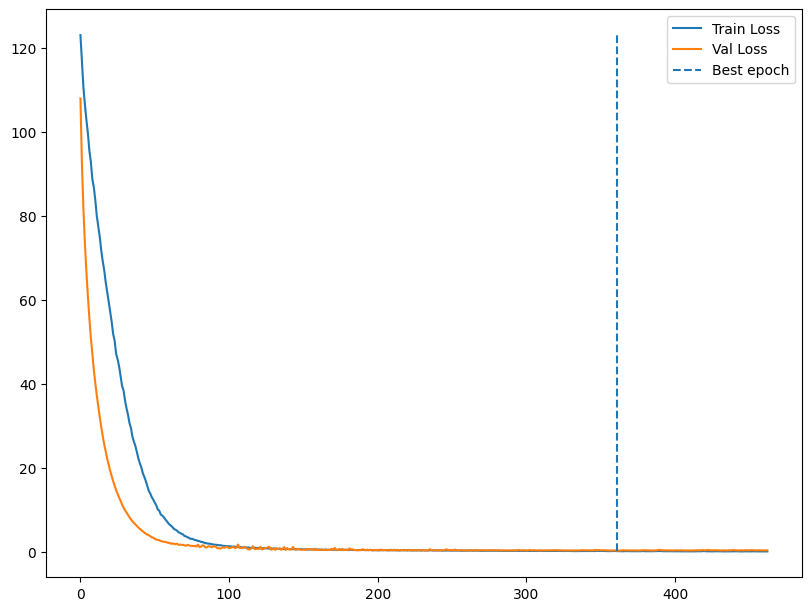

(20000, 555)
(20000,)
Train - f1=0.9949 recall=1.0000 precision=0.9898 log-loss=0.0152 opt-log-loss=0.0177
(20000, 62)
(20000,)
Test  - f1=0.7826 recall=0.8182 precision=0.7500 log-loss=0.2838 opt-log-loss=0.2418

-- Fold # 3/10 - Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1827 - Val: 0.3433 at epoch 321.
Restore the best model.


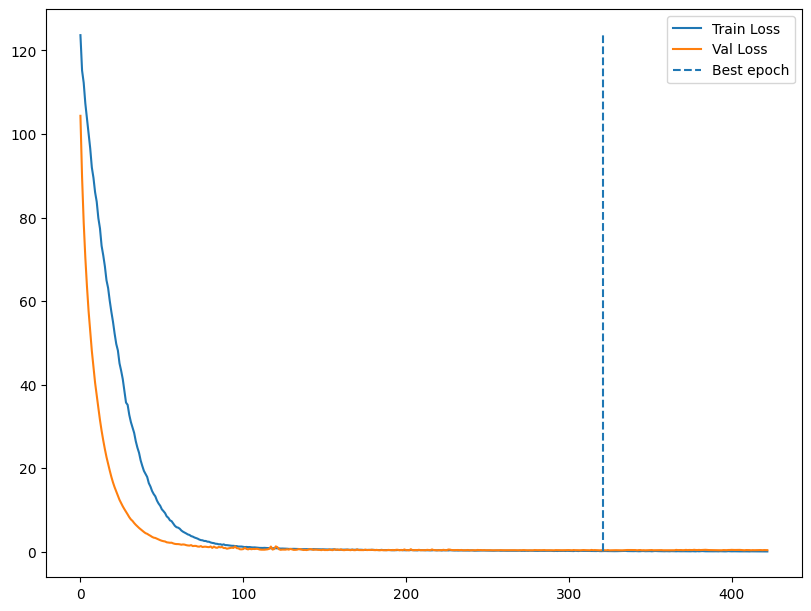

(20000, 555)
(20000,)
Train - f1=0.9697 recall=0.9897 precision=0.9505 log-loss=0.0369 opt-log-loss=0.0503
(20000, 62)
(20000,)
Test  - f1=0.6957 recall=0.7273 precision=0.6667 log-loss=0.2969 opt-log-loss=0.2586

-- Fold # 4/10 - Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3722 - Val: 0.2853 at epoch 195.
Restore the best model.


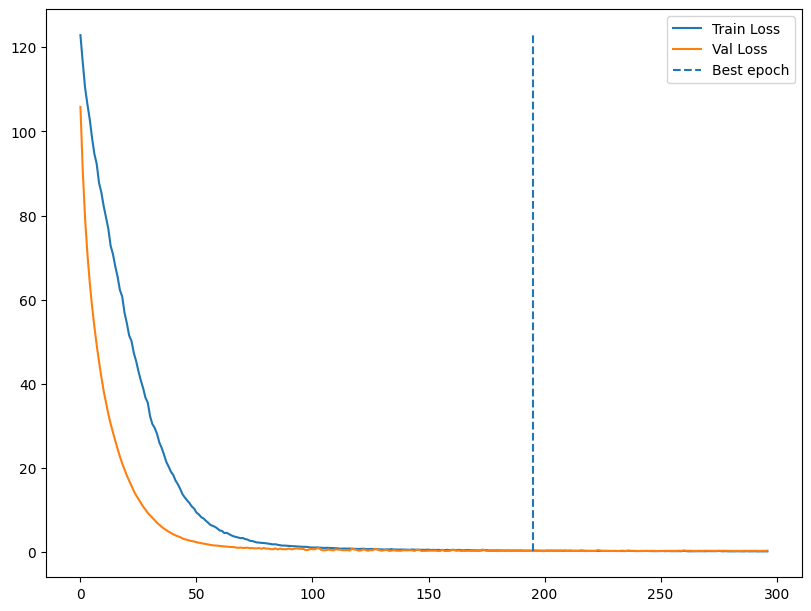

(20000, 555)
(20000,)
Train - f1=0.8132 recall=0.7629 precision=0.8706 log-loss=0.3349 opt-log-loss=0.1756
(20000, 62)
(20000,)
Test  - f1=0.7619 recall=0.7273 precision=0.8000 log-loss=0.4115 opt-log-loss=0.2683

-- Fold # 4/10 - Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2212 - Val: 0.2466 at epoch 275.
Restore the best model.


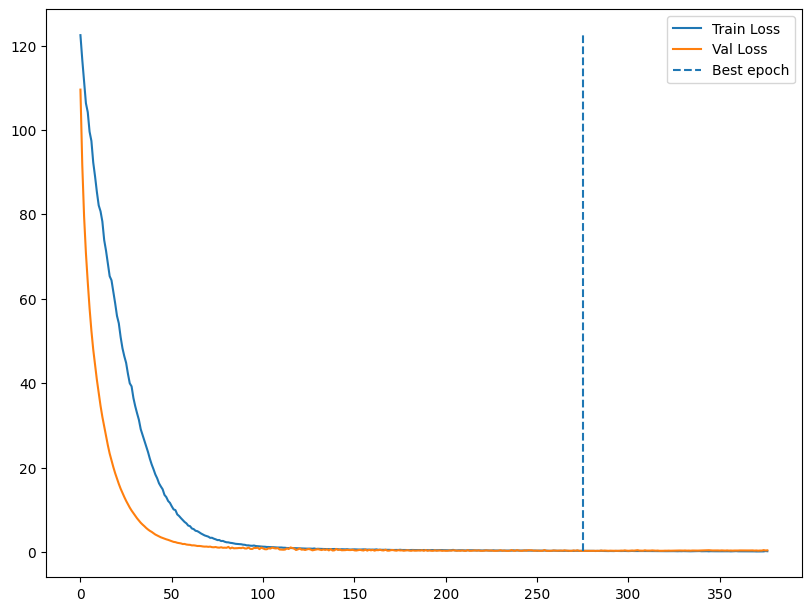

(20000, 555)
(20000,)
Train - f1=0.9641 recall=0.9691 precision=0.9592 log-loss=0.1094 opt-log-loss=0.0703
(20000, 62)
(20000,)
Test  - f1=0.7826 recall=0.8182 precision=0.7500 log-loss=0.2394 opt-log-loss=0.1869

-- Fold # 4/10 - Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3099 - Val: 0.2583 at epoch 246.
Restore the best model.


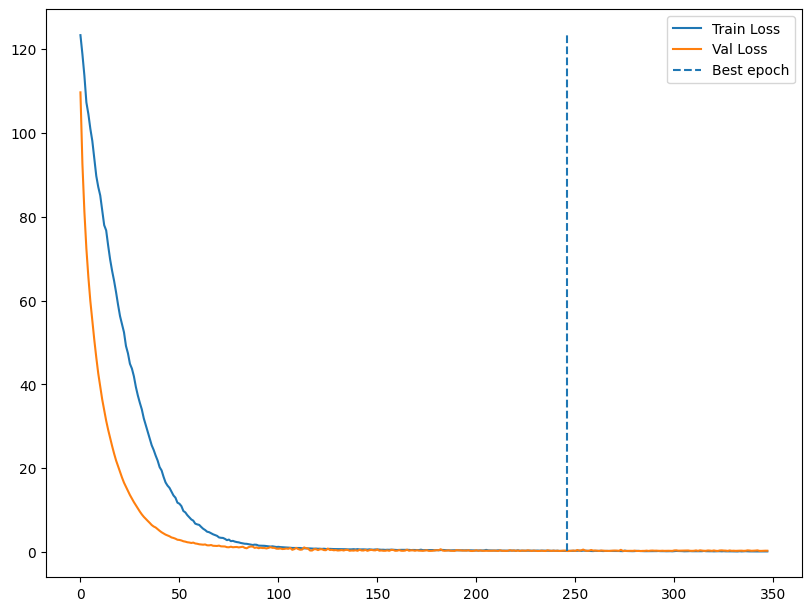

(20000, 555)
(20000,)
Train - f1=0.9524 recall=0.9278 precision=0.9783 log-loss=0.1733 opt-log-loss=0.0988
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.3056 opt-log-loss=0.2294

-- Fold # 4/10 - Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2590 - Val: 0.2332 at epoch 310.
Restore the best model.


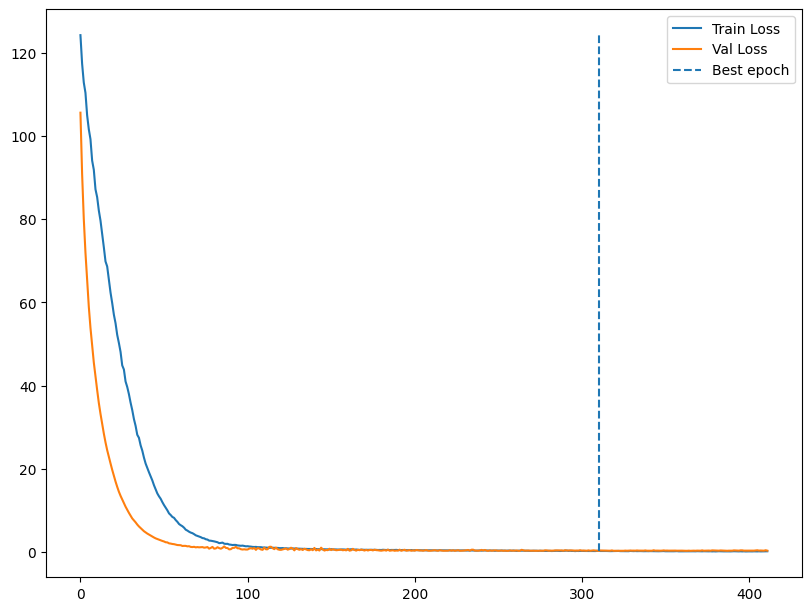

(20000, 555)
(20000,)
Train - f1=0.9735 recall=0.9485 precision=1.0000 log-loss=0.1010 opt-log-loss=0.0451
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.3029 opt-log-loss=0.2112

-- Fold # 4/10 - Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2514 - Val: 0.2312 at epoch 275.
Restore the best model.


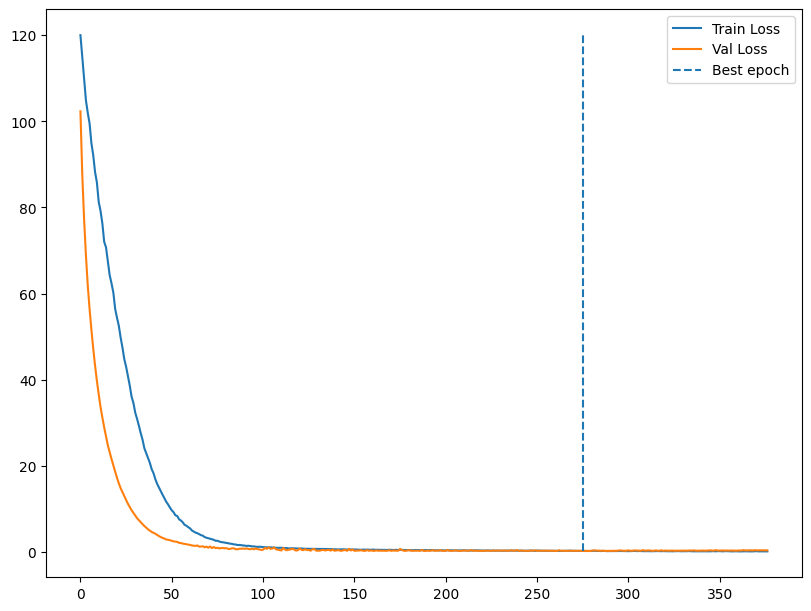

(20000, 555)
(20000,)
Train - f1=0.9845 recall=0.9794 precision=0.9896 log-loss=0.1077 opt-log-loss=0.0620
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.2508 opt-log-loss=0.1882

-- Fold # 4/10 - Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2739 - Val: 0.2557 at epoch 231.
Restore the best model.


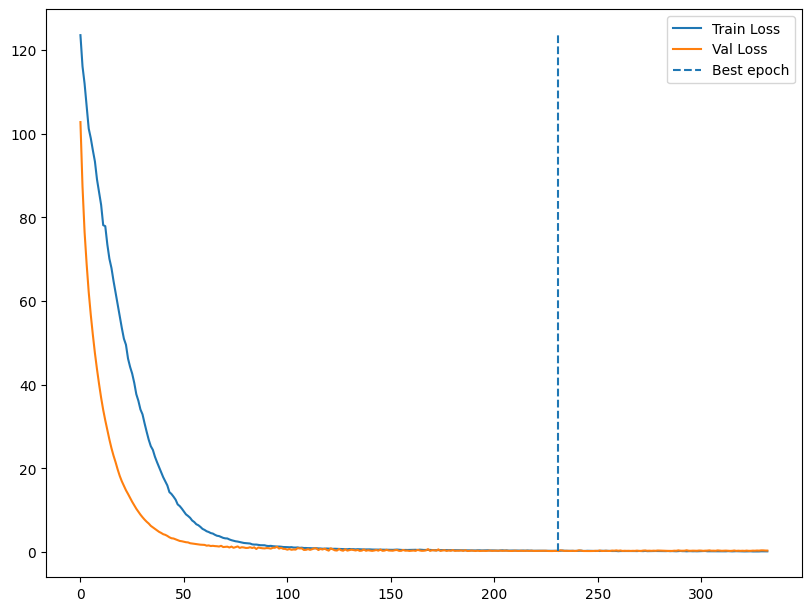

(20000, 555)
(20000,)
Train - f1=0.8947 recall=0.8763 precision=0.9140 log-loss=0.1836 opt-log-loss=0.1187
(20000, 62)
(20000,)
Test  - f1=0.7619 recall=0.7273 precision=0.8000 log-loss=0.3600 opt-log-loss=0.2393

-- Fold # 4/10 - Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1469 - Val: 0.1673 at epoch 339.
Restore the best model.


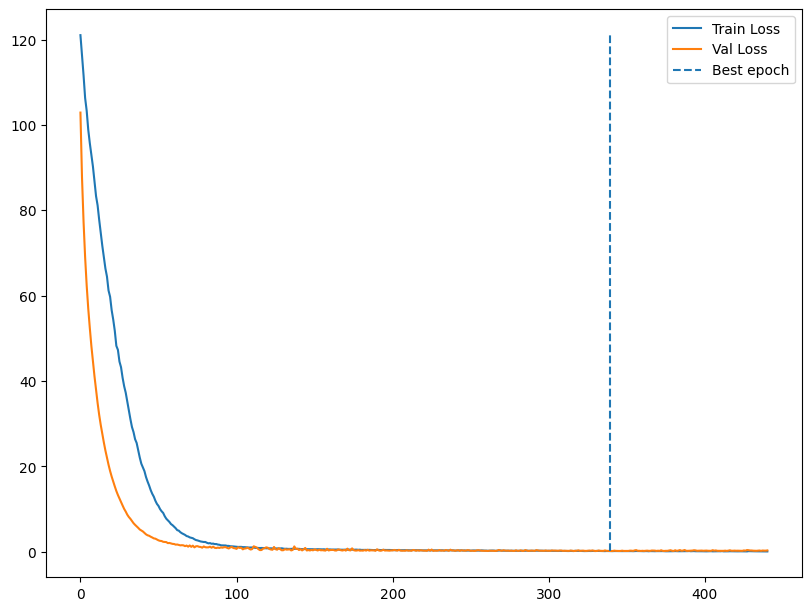

(20000, 555)
(20000,)
Train - f1=0.9738 recall=0.9588 precision=0.9894 log-loss=0.0905 opt-log-loss=0.0365
(20000, 62)
(20000,)
Test  - f1=0.9524 recall=0.9091 precision=1.0000 log-loss=0.1723 opt-log-loss=0.1228

-- Fold # 4/10 - Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3265 - Val: 0.2385 at epoch 223.
Restore the best model.


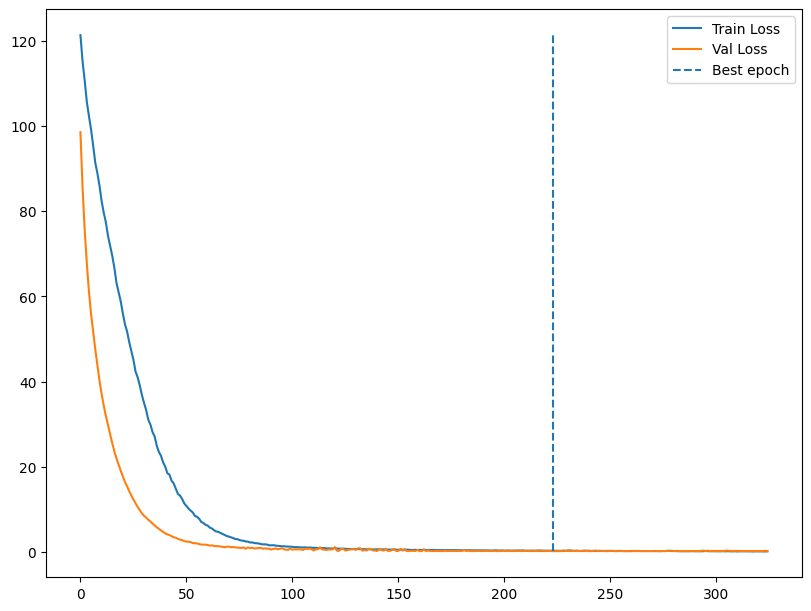

(20000, 555)
(20000,)
Train - f1=0.9286 recall=0.9381 precision=0.9192 log-loss=0.1548 opt-log-loss=0.1223
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.2746 opt-log-loss=0.2170

-- Fold # 4/10 - Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4696 - Val: 0.2629 at epoch 178.
Restore the best model.


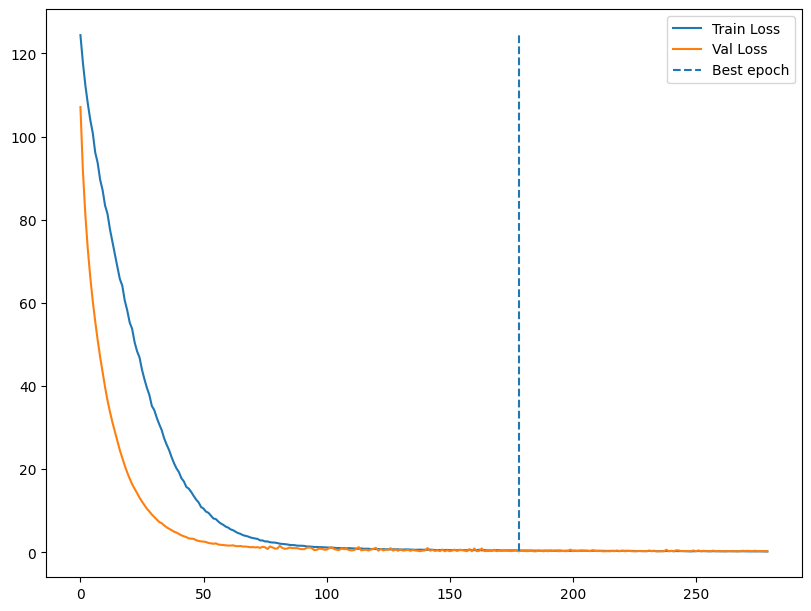

(20000, 555)
(20000,)
Train - f1=0.8370 recall=0.7938 precision=0.8851 log-loss=0.2659 opt-log-loss=0.1789
(20000, 62)
(20000,)
Test  - f1=0.7619 recall=0.7273 precision=0.8000 log-loss=0.3519 opt-log-loss=0.2466

-- Fold # 4/10 - Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3284 - Val: 0.2440 at epoch 212.
Restore the best model.


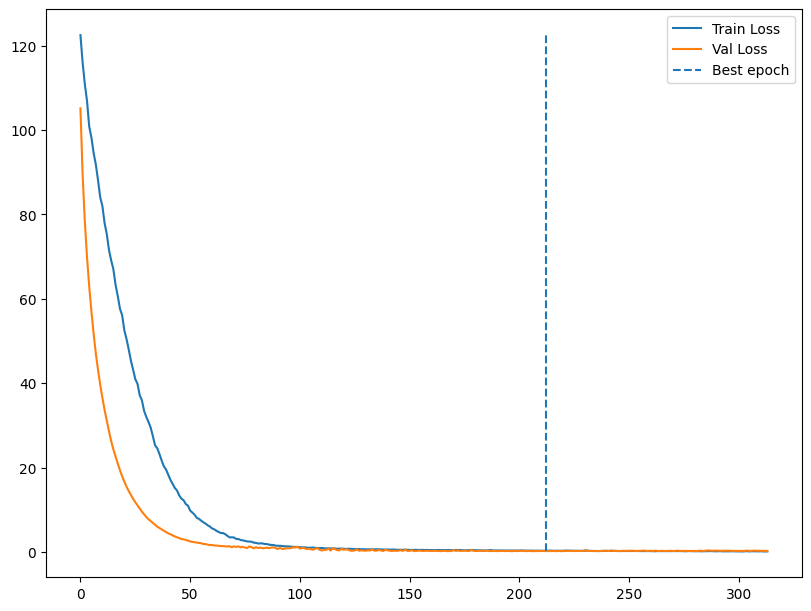

(20000, 555)
(20000,)
Train - f1=0.8619 recall=0.8041 precision=0.9286 log-loss=0.2526 opt-log-loss=0.1441
(20000, 62)
(20000,)
Test  - f1=0.8571 recall=0.8182 precision=0.9000 log-loss=0.3177 opt-log-loss=0.2205

-- Fold # 5/10 - Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2171 - Val: 0.2351 at epoch 307.
Restore the best model.


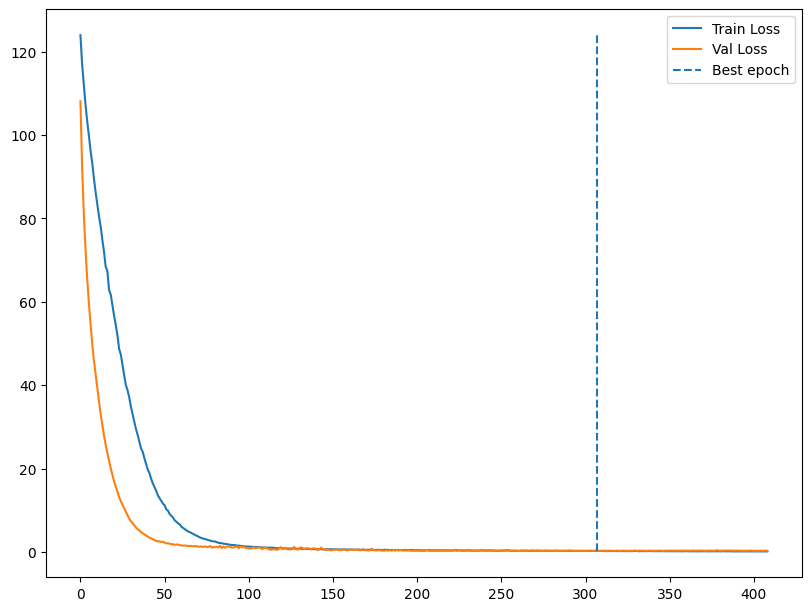

(20000, 555)
(20000,)
Train - f1=0.9798 recall=1.0000 precision=0.9604 log-loss=0.0374 opt-log-loss=0.0577
(20000, 62)
(20000,)
Test  - f1=0.8000 recall=0.7273 precision=0.8889 log-loss=0.2699 opt-log-loss=0.1965

-- Fold # 5/10 - Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3006 - Val: 0.2010 at epoch 245.
Restore the best model.


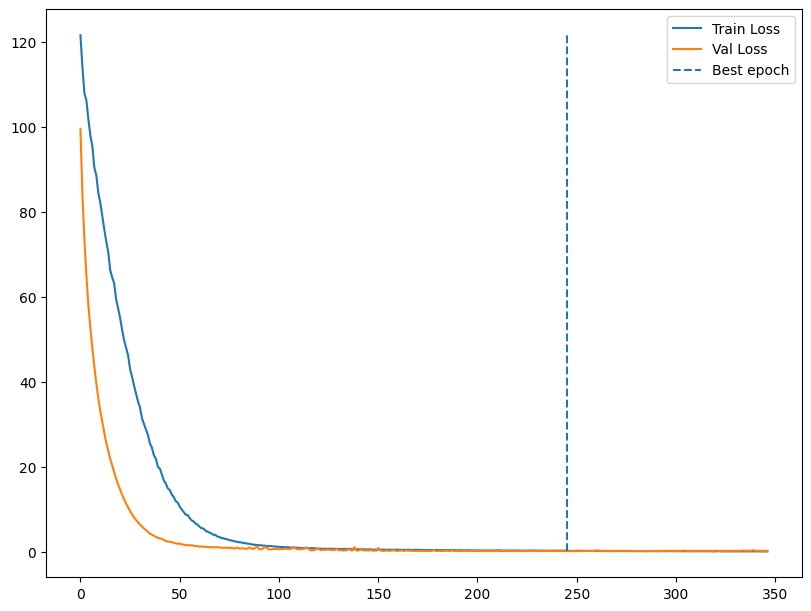

(20000, 555)
(20000,)
Train - f1=0.9014 recall=0.9897 precision=0.8276 log-loss=0.0691 opt-log-loss=0.1082
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.1931 opt-log-loss=0.1539

-- Fold # 5/10 - Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1506 - Val: 0.1732 at epoch 356.
Restore the best model.


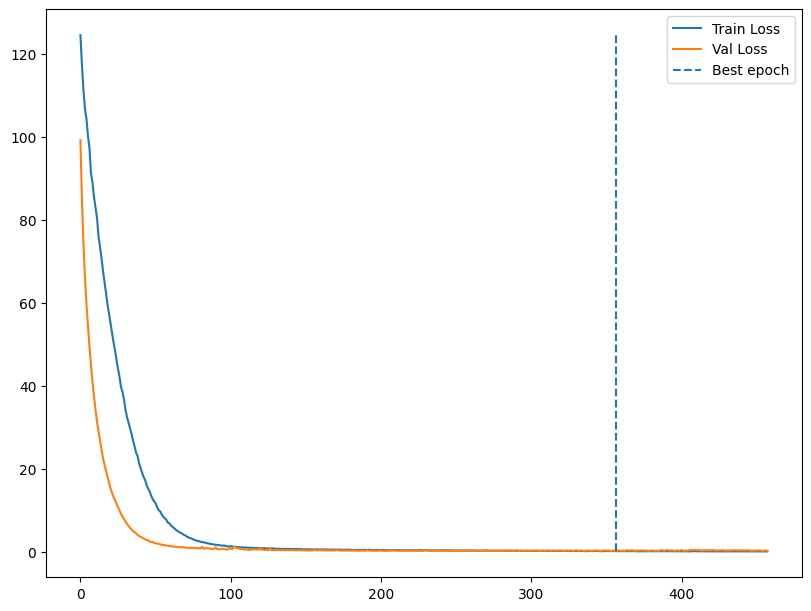

(20000, 555)
(20000,)
Train - f1=0.9848 recall=1.0000 precision=0.9700 log-loss=0.0175 opt-log-loss=0.0436
(20000, 62)
(20000,)
Test  - f1=0.9565 recall=1.0000 precision=0.9167 log-loss=0.1078 opt-log-loss=0.1109

-- Fold # 5/10 - Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2561 - Val: 0.1945 at epoch 254.
Restore the best model.


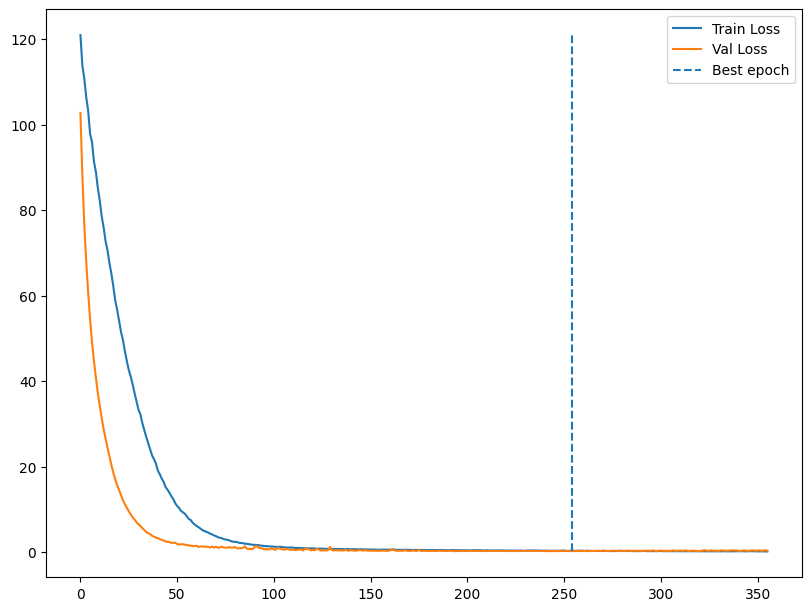

(20000, 555)
(20000,)
Train - f1=0.8962 recall=0.9794 precision=0.8261 log-loss=0.0741 opt-log-loss=0.1045
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.1872 opt-log-loss=0.1315

-- Fold # 5/10 - Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3120 - Val: 0.2282 at epoch 229.
Restore the best model.


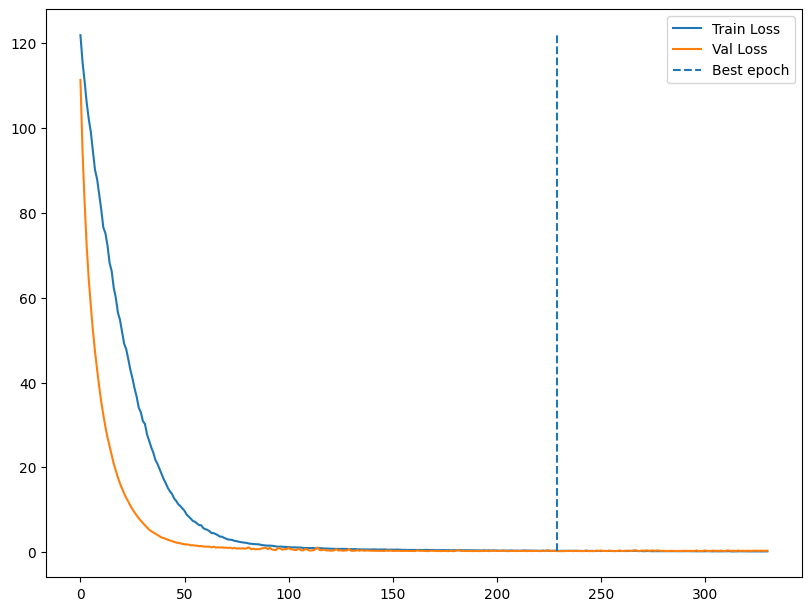

(20000, 555)
(20000,)
Train - f1=0.9014 recall=0.9897 precision=0.8276 log-loss=0.0868 opt-log-loss=0.1176
(20000, 62)
(20000,)
Test  - f1=0.8696 recall=0.9091 precision=0.8333 log-loss=0.1849 opt-log-loss=0.1514

-- Fold # 5/10 - Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2983 - Val: 0.2054 at epoch 245.
Restore the best model.


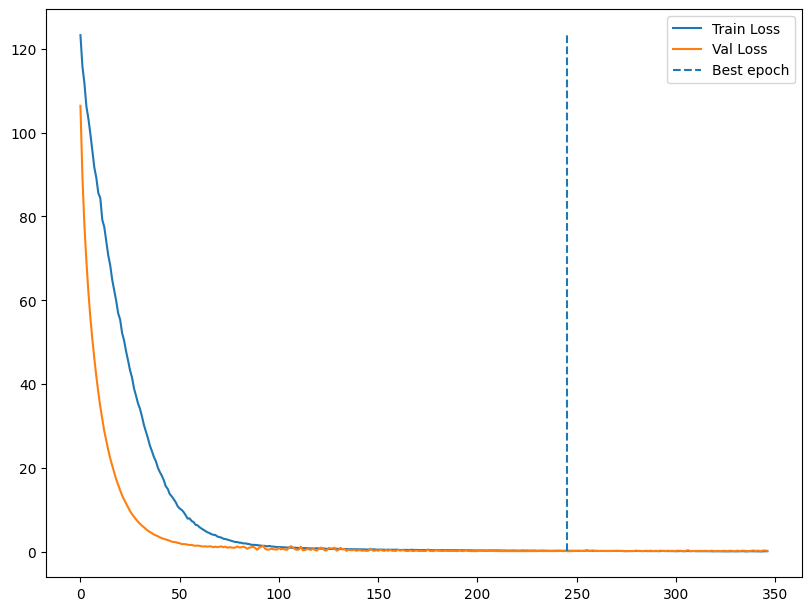

(20000, 555)
(20000,)
Train - f1=0.8848 recall=0.9897 precision=0.8000 log-loss=0.0845 opt-log-loss=0.1250
(20000, 62)
(20000,)
Test  - f1=0.8571 recall=0.8182 precision=0.9000 log-loss=0.2803 opt-log-loss=0.1949

-- Fold # 5/10 - Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1957 - Val: 0.1577 at epoch 321.
Restore the best model.


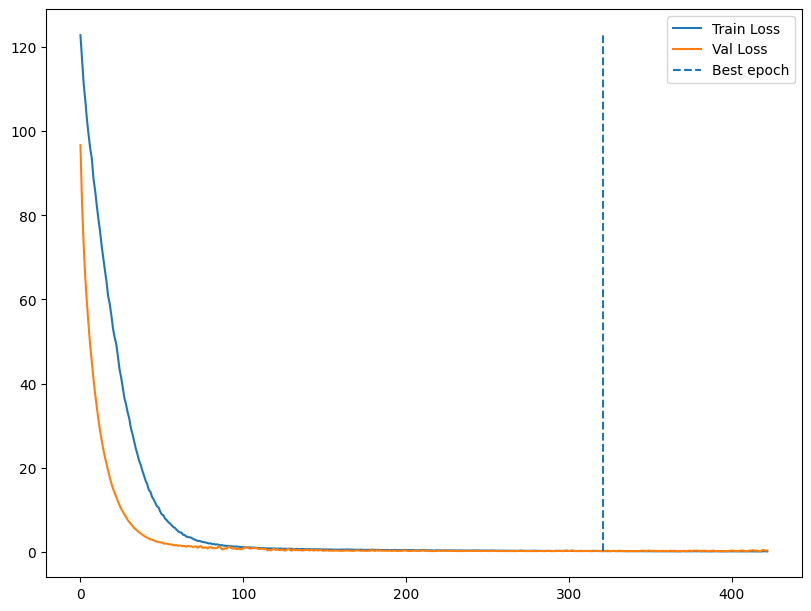

(20000, 555)
(20000,)
Train - f1=0.9798 recall=1.0000 precision=0.9604 log-loss=0.0213 opt-log-loss=0.0388
(20000, 62)
(20000,)
Test  - f1=0.9091 recall=0.9091 precision=0.9091 log-loss=0.1516 opt-log-loss=0.1072

-- Fold # 5/10 - Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3873 - Val: 0.2161 at epoch 205.
Restore the best model.


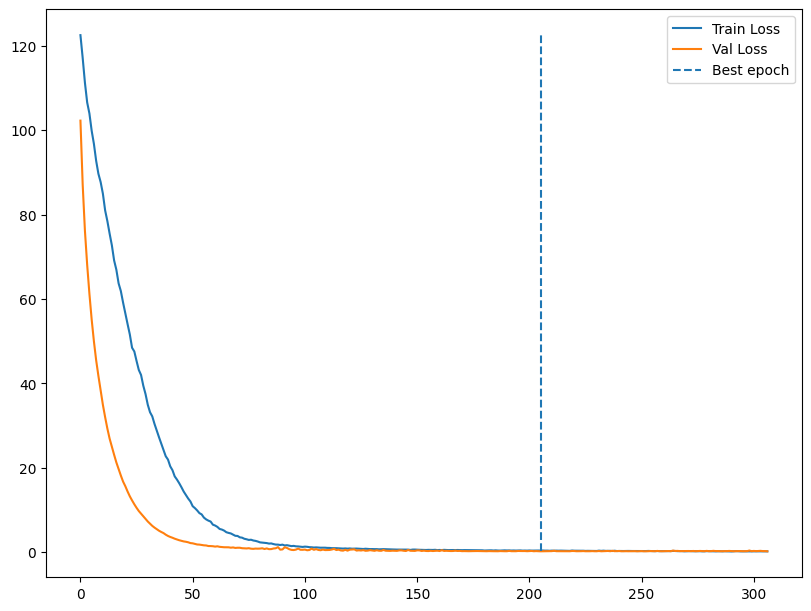

(20000, 555)
(20000,)
Train - f1=0.8792 recall=0.9381 precision=0.8273 log-loss=0.1329 opt-log-loss=0.1283
(20000, 62)
(20000,)
Test  - f1=0.8571 recall=0.8182 precision=0.9000 log-loss=0.3159 opt-log-loss=0.1992

-- Fold # 5/10 - Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3030 - Val: 0.1522 at epoch 238.
Restore the best model.


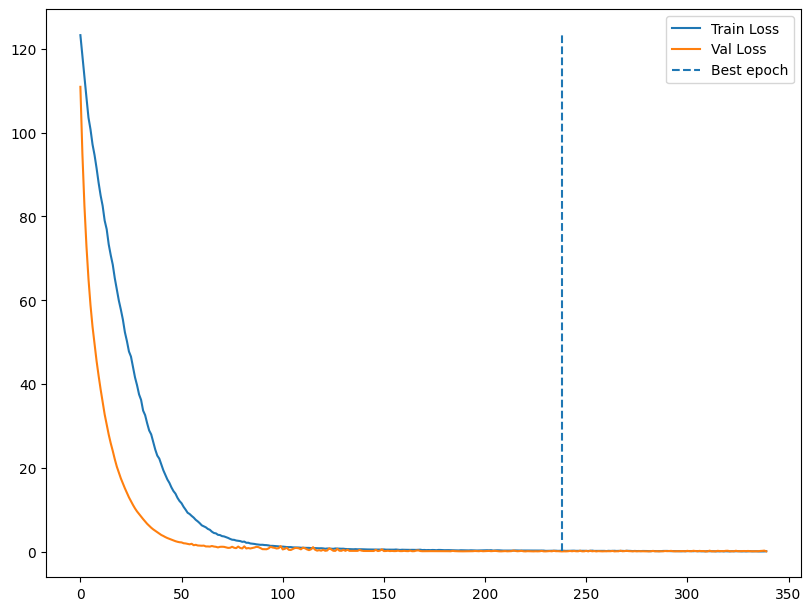

(20000, 555)
(20000,)
Train - f1=0.9179 recall=0.9794 precision=0.8636 log-loss=0.0678 opt-log-loss=0.0962
(20000, 62)
(20000,)
Test  - f1=0.8571 recall=0.8182 precision=0.9000 log-loss=0.1583 opt-log-loss=0.1213

-- Fold # 5/10 - Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2708 - Val: 0.1809 at epoch 260.
Restore the best model.


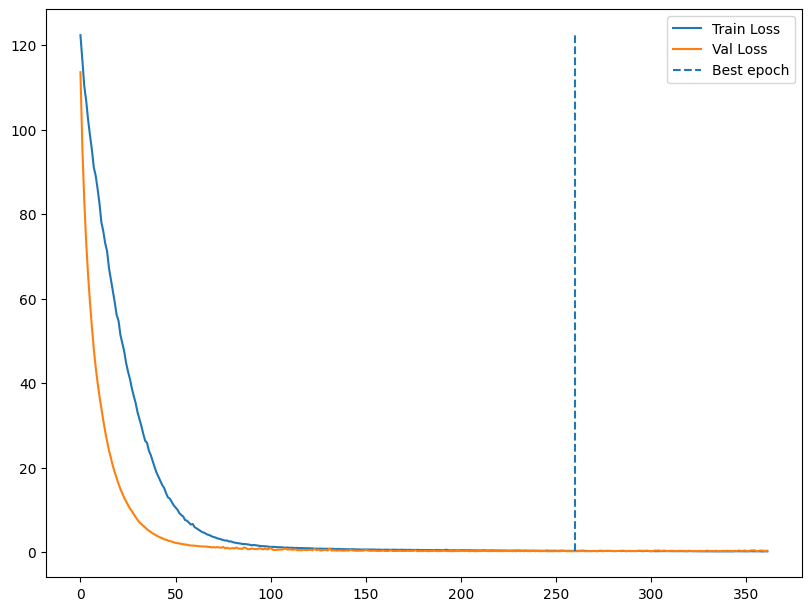

(20000, 555)
(20000,)
Train - f1=0.9100 recall=0.9897 precision=0.8421 log-loss=0.0739 opt-log-loss=0.1131
(20000, 62)
(20000,)
Test  - f1=0.8571 recall=0.8182 precision=0.9000 log-loss=0.1862 opt-log-loss=0.1336

-- Fold # 6/10 - Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1780 - Val: 0.4188 at epoch 318.
Restore the best model.


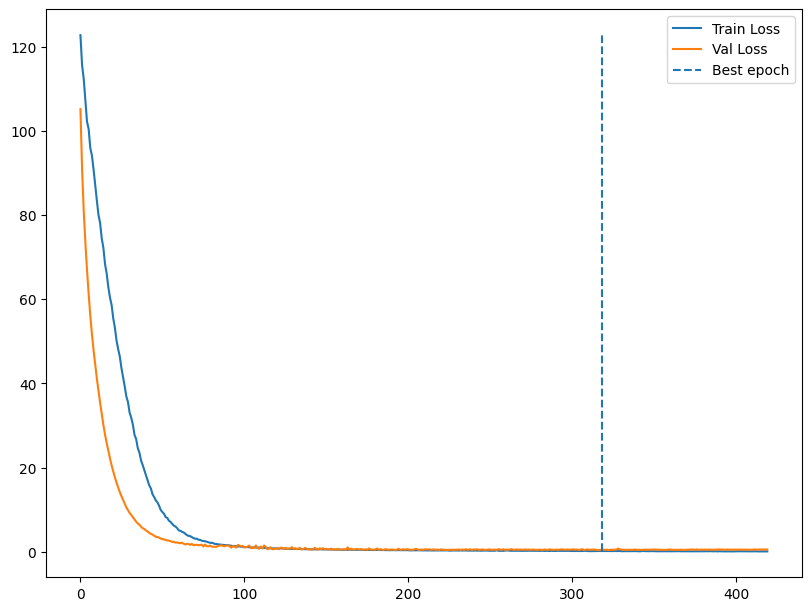

(20000, 555)
(20000,)
Train - f1=0.9792 recall=0.9691 precision=0.9895 log-loss=0.0679 opt-log-loss=0.0353
(20000, 62)
(20000,)
Test  - f1=0.6667 recall=0.6364 precision=0.7000 log-loss=0.7041 opt-log-loss=0.5394

-- Fold # 6/10 - Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2438 - Val: 0.4240 at epoch 292.
Restore the best model.


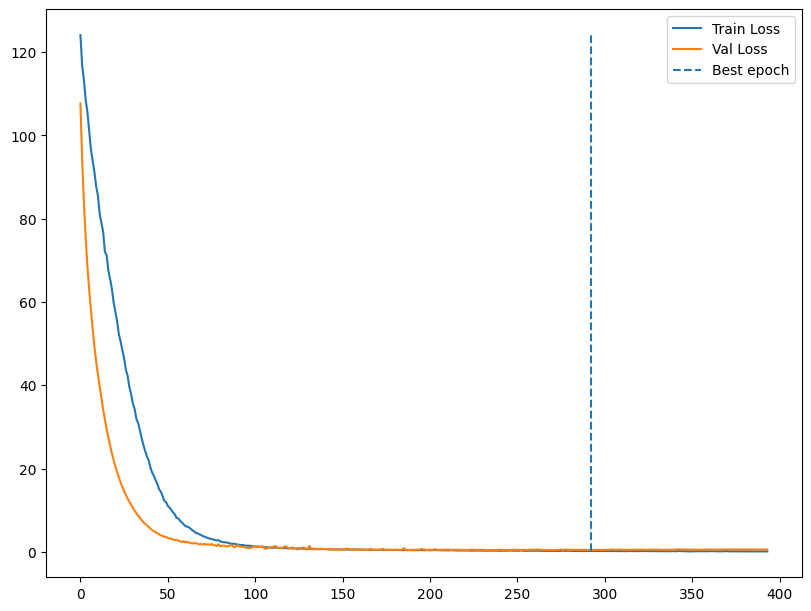

(20000, 555)
(20000,)
Train - f1=0.9648 recall=0.9897 precision=0.9412 log-loss=0.0489 opt-log-loss=0.0661
(20000, 62)
(20000,)
Test  - f1=0.6667 recall=0.7273 precision=0.6154 log-loss=0.5505 opt-log-loss=0.4857

-- Fold # 6/10 - Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2178 - Val: 0.4990 at epoch 299.
Restore the best model.


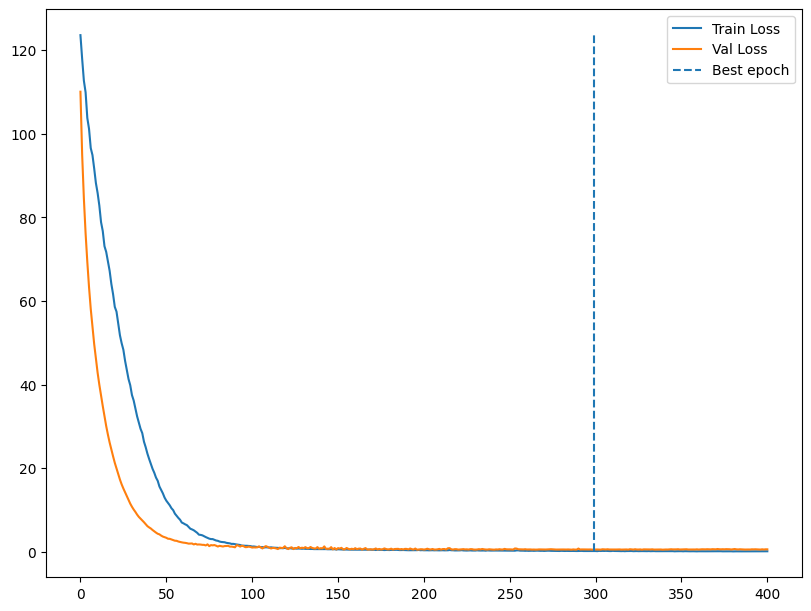

(20000, 555)
(20000,)
Train - f1=0.9741 recall=0.9691 precision=0.9792 log-loss=0.0782 opt-log-loss=0.0474
(20000, 62)
(20000,)
Test  - f1=0.5714 recall=0.5455 precision=0.6000 log-loss=0.8912 opt-log-loss=0.6396

-- Fold # 6/10 - Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2571 - Val: 0.4985 at epoch 270.
Restore the best model.


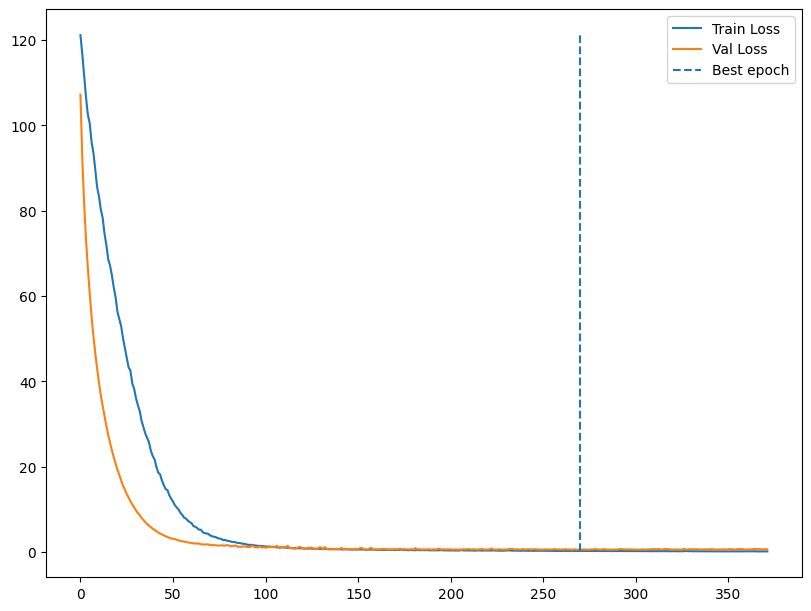

(20000, 555)
(20000,)
Train - f1=0.9574 recall=0.9278 precision=0.9890 log-loss=0.1538 opt-log-loss=0.0647
(20000, 62)
(20000,)
Test  - f1=0.6000 recall=0.5455 precision=0.6667 log-loss=0.9181 opt-log-loss=0.6746

-- Fold # 6/10 - Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2475 - Val: 0.4278 at epoch 302.
Restore the best model.


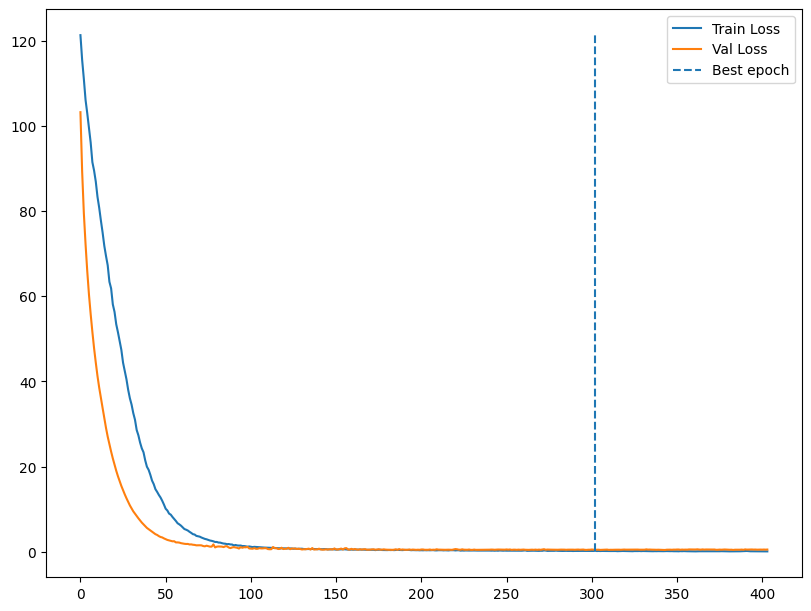

(20000, 555)
(20000,)
Train - f1=0.9846 recall=0.9897 precision=0.9796 log-loss=0.0555 opt-log-loss=0.0413
(20000, 62)
(20000,)
Test  - f1=0.6364 recall=0.6364 precision=0.6364 log-loss=0.6367 opt-log-loss=0.4959

-- Fold # 6/10 - Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1201 - Val: 0.4546 at epoch 364.
Restore the best model.


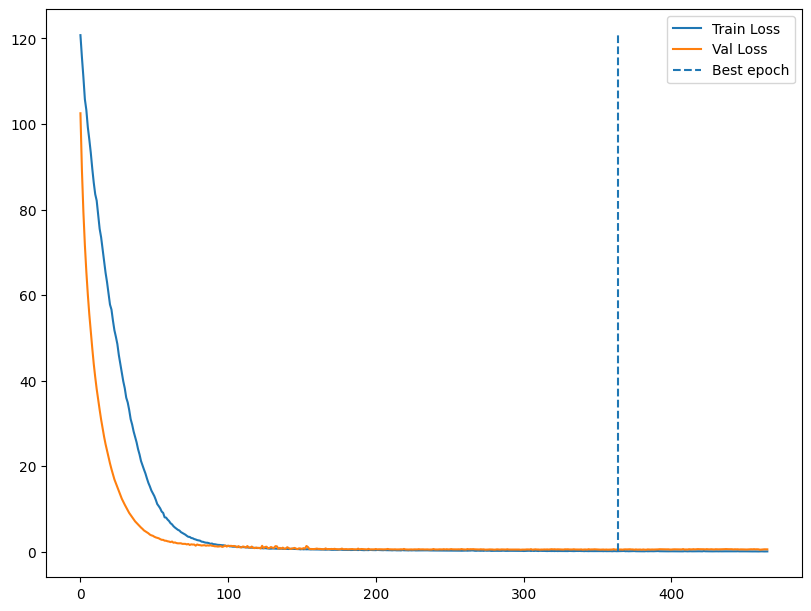

(20000, 555)
(20000,)
Train - f1=0.9948 recall=0.9897 precision=1.0000 log-loss=0.0321 opt-log-loss=0.0164
(20000, 62)
(20000,)
Test  - f1=0.7000 recall=0.6364 precision=0.7778 log-loss=0.8717 opt-log-loss=0.6402

-- Fold # 6/10 - Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2524 - Val: 0.3919 at epoch 294.
Restore the best model.


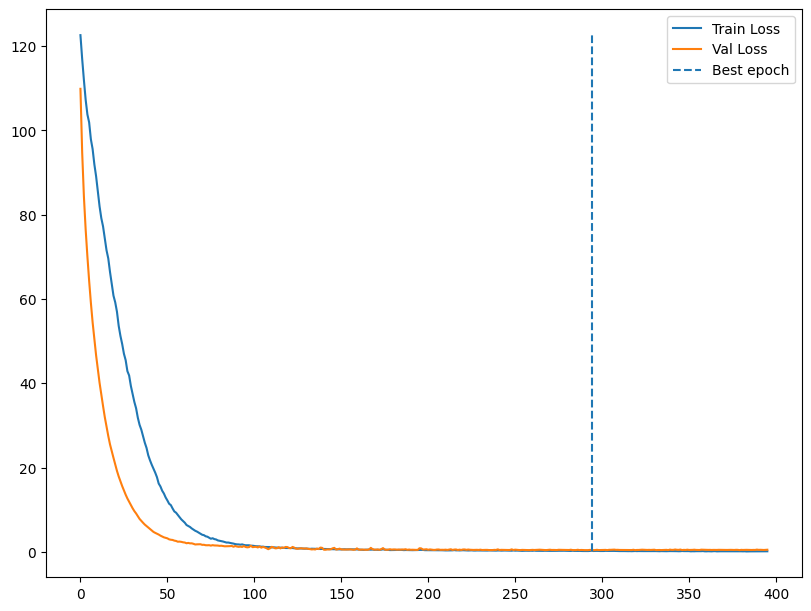

(20000, 555)
(20000,)
Train - f1=0.9738 recall=0.9588 precision=0.9894 log-loss=0.0759 opt-log-loss=0.0616
(20000, 62)
(20000,)
Test  - f1=0.6957 recall=0.7273 precision=0.6667 log-loss=0.5625 opt-log-loss=0.4338

-- Fold # 6/10 - Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3413 - Val: 0.4312 at epoch 224.
Restore the best model.


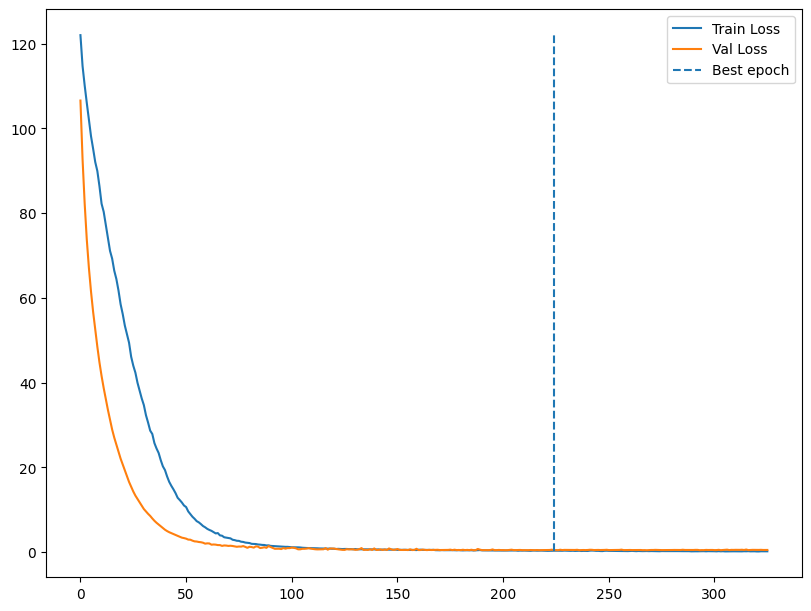

(20000, 555)
(20000,)
Train - f1=0.9278 recall=0.9278 precision=0.9278 log-loss=0.1558 opt-log-loss=0.1234
(20000, 62)
(20000,)
Test  - f1=0.5455 recall=0.5455 precision=0.5455 log-loss=0.5810 opt-log-loss=0.4557

-- Fold # 6/10 - Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3678 - Val: 0.3962 at epoch 202.
Restore the best model.


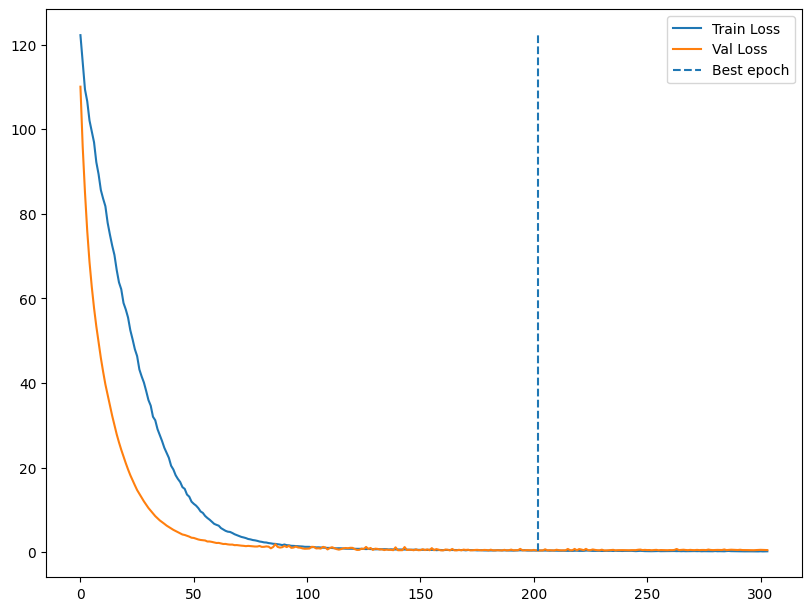

(20000, 555)
(20000,)
Train - f1=0.8830 recall=0.8557 precision=0.9121 log-loss=0.2200 opt-log-loss=0.1420
(20000, 62)
(20000,)
Test  - f1=0.7000 recall=0.6364 precision=0.7778 log-loss=0.6228 opt-log-loss=0.4602

-- Fold # 6/10 - Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4143 - Val: 0.4213 at epoch 209.
Restore the best model.


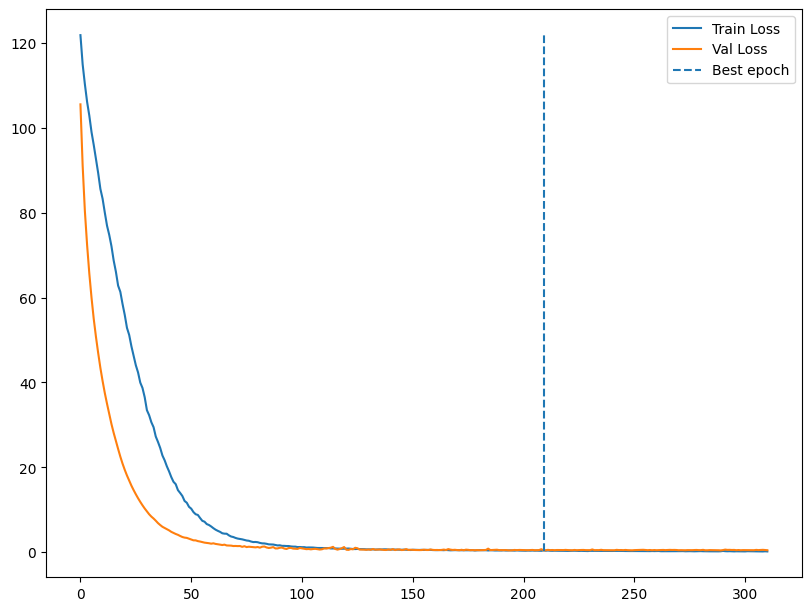

(20000, 555)
(20000,)
Train - f1=0.9368 recall=0.9175 precision=0.9570 log-loss=0.1829 opt-log-loss=0.1312
(20000, 62)
(20000,)
Test  - f1=0.7273 recall=0.7273 precision=0.7273 log-loss=0.5039 opt-log-loss=0.3916

-- Fold # 7/10 - Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.5375 - Val: 0.4026 at epoch 155.
Restore the best model.


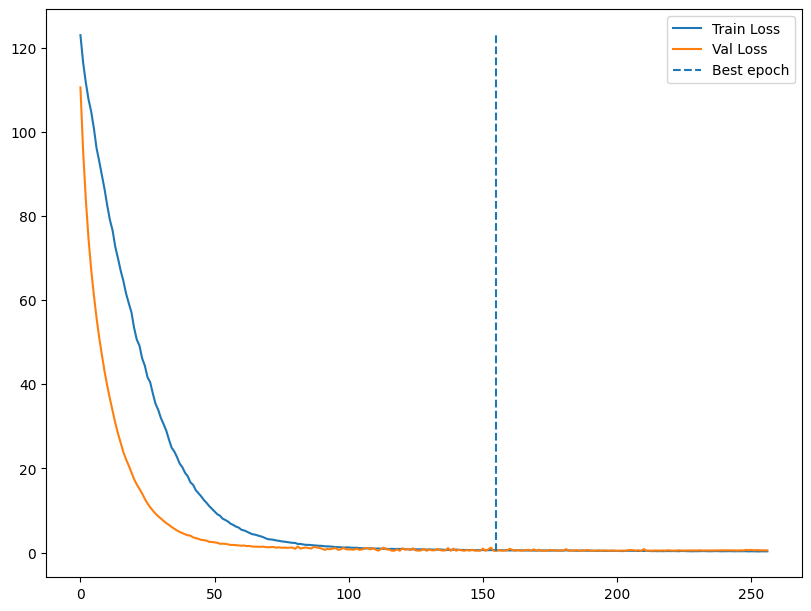

(20000, 555)
(20000,)
Train - f1=0.8342 recall=0.8557 precision=0.8137 log-loss=0.2790 opt-log-loss=0.2256
(20000, 62)
(20000,)
Test  - f1=0.6667 recall=0.6364 precision=0.7000 log-loss=0.5993 opt-log-loss=0.4399

-- Fold # 7/10 - Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4143 - Val: 0.5003 at epoch 210.
Restore the best model.


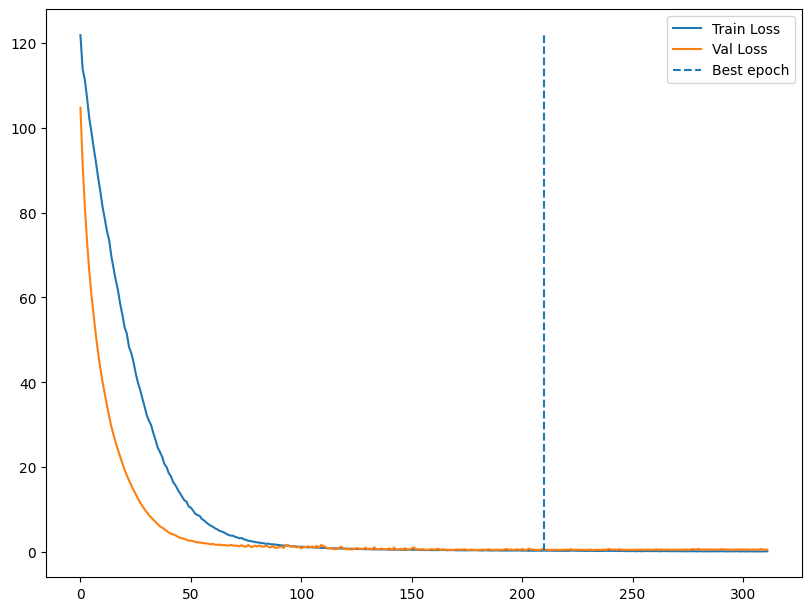

(20000, 555)
(20000,)
Train - f1=0.8792 recall=0.9381 precision=0.8273 log-loss=0.1426 opt-log-loss=0.1460
(20000, 62)
(20000,)
Test  - f1=0.6000 recall=0.5455 precision=0.6667 log-loss=0.7841 opt-log-loss=0.6214

-- Fold # 7/10 - Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.5355 - Val: 0.4958 at epoch 149.
Restore the best model.


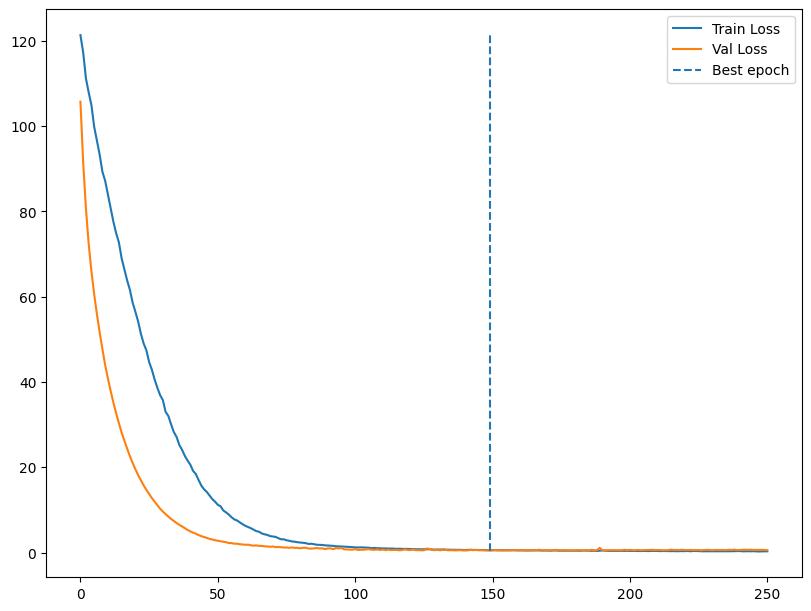

(20000, 555)
(20000,)
Train - f1=0.8098 recall=0.8557 precision=0.7685 log-loss=0.2757 opt-log-loss=0.2437
(20000, 62)
(20000,)
Test  - f1=0.6000 recall=0.5455 precision=0.6667 log-loss=0.7932 opt-log-loss=0.5675

-- Fold # 7/10 - Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3057 - Val: 0.5110 at epoch 247.
Restore the best model.


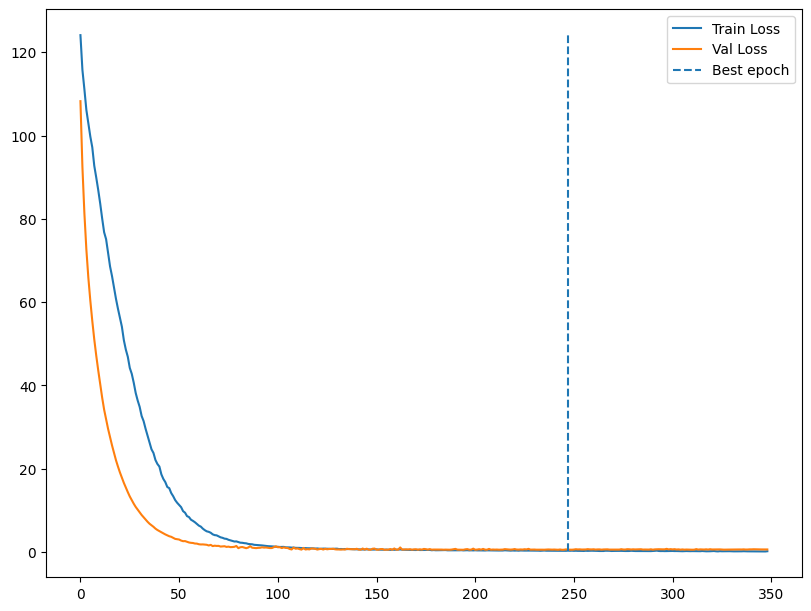

(20000, 555)
(20000,)
Train - f1=0.9447 recall=0.9691 precision=0.9216 log-loss=0.0914 opt-log-loss=0.0991
(20000, 62)
(20000,)
Test  - f1=0.4762 recall=0.4545 precision=0.5000 log-loss=0.8867 opt-log-loss=0.6890

-- Fold # 7/10 - Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4010 - Val: 0.5130 at epoch 192.
Restore the best model.


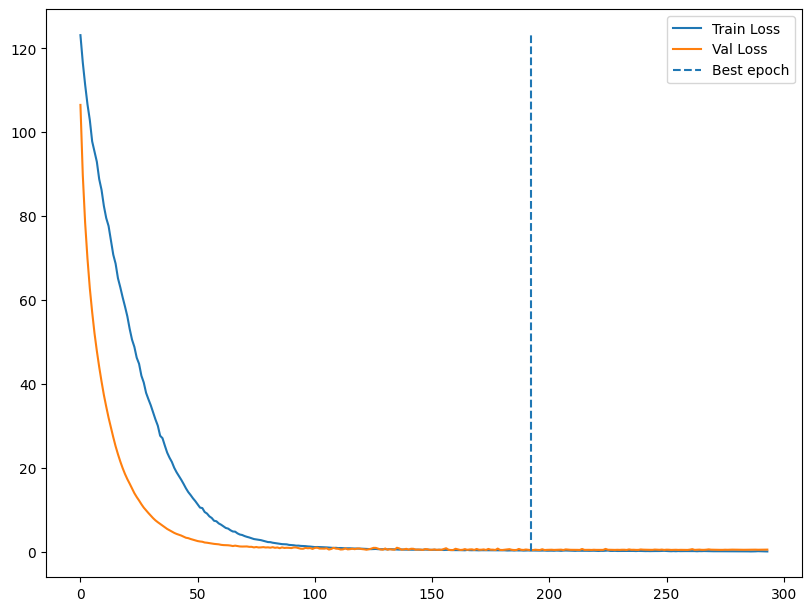

(20000, 555)
(20000,)
Train - f1=0.8744 recall=0.8969 precision=0.8529 log-loss=0.2108 opt-log-loss=0.1719
(20000, 62)
(20000,)
Test  - f1=0.5263 recall=0.4545 precision=0.6250 log-loss=0.9389 opt-log-loss=0.6587

-- Fold # 7/10 - Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3063 - Val: 0.5496 at epoch 234.
Restore the best model.


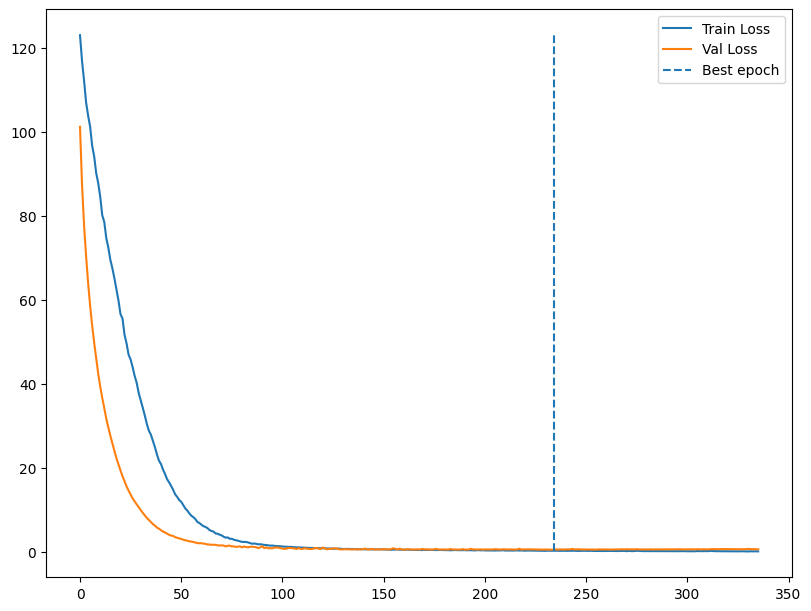

(20000, 555)
(20000,)
Train - f1=0.9347 recall=0.9588 precision=0.9118 log-loss=0.1251 opt-log-loss=0.1104
(20000, 62)
(20000,)
Test  - f1=0.6316 recall=0.5455 precision=0.7500 log-loss=1.1286 opt-log-loss=0.8249

-- Fold # 7/10 - Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4501 - Val: 0.4592 at epoch 192.
Restore the best model.


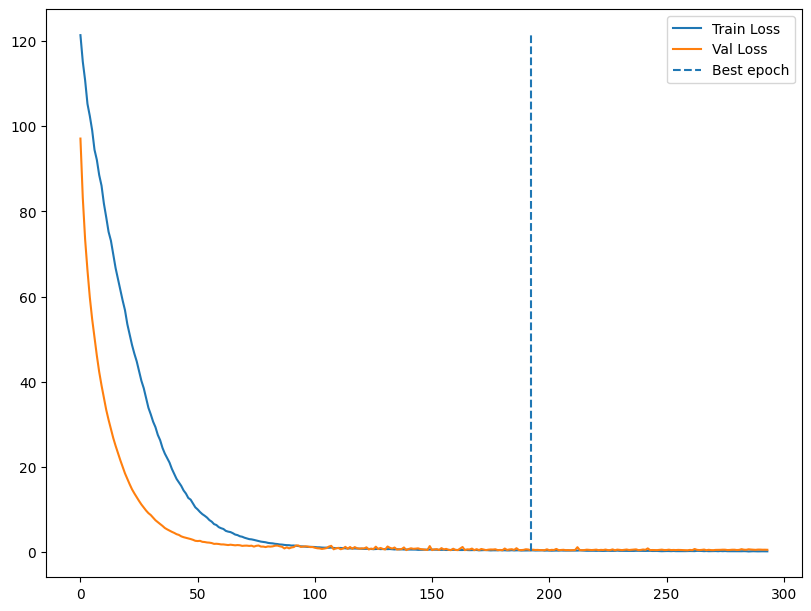

(20000, 555)
(20000,)
Train - f1=0.8922 recall=0.9381 precision=0.8505 log-loss=0.1772 opt-log-loss=0.1733
(20000, 62)
(20000,)
Test  - f1=0.5455 recall=0.5455 precision=0.5455 log-loss=0.7234 opt-log-loss=0.5670

-- Fold # 7/10 - Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3174 - Val: 0.4413 at epoch 231.
Restore the best model.


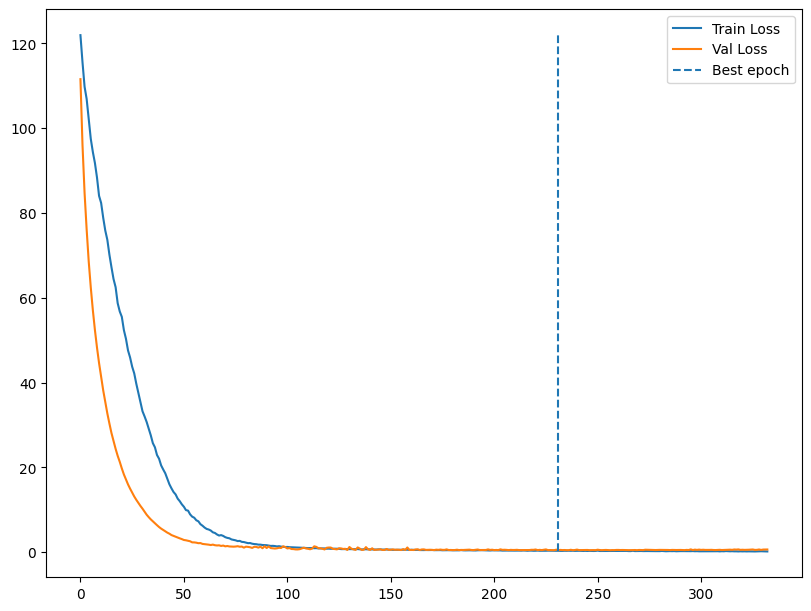

(20000, 555)
(20000,)
Train - f1=0.9149 recall=0.8866 precision=0.9451 log-loss=0.1567 opt-log-loss=0.1102
(20000, 62)
(20000,)
Test  - f1=0.6316 recall=0.5455 precision=0.7500 log-loss=0.7941 opt-log-loss=0.5444

-- Fold # 7/10 - Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4590 - Val: 0.4957 at epoch 176.
Restore the best model.


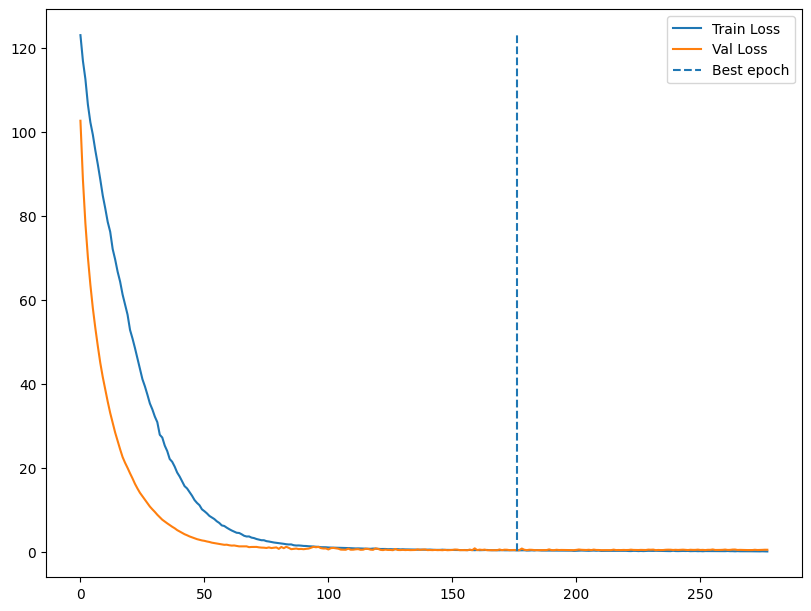

(20000, 555)
(20000,)
Train - f1=0.8267 recall=0.9588 precision=0.7266 log-loss=0.2206 opt-log-loss=0.2198
(20000, 62)
(20000,)
Test  - f1=0.4762 recall=0.4545 precision=0.5000 log-loss=0.8155 opt-log-loss=0.6094

-- Fold # 7/10 - Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.5133 - Val: 0.5255 at epoch 157.
Restore the best model.


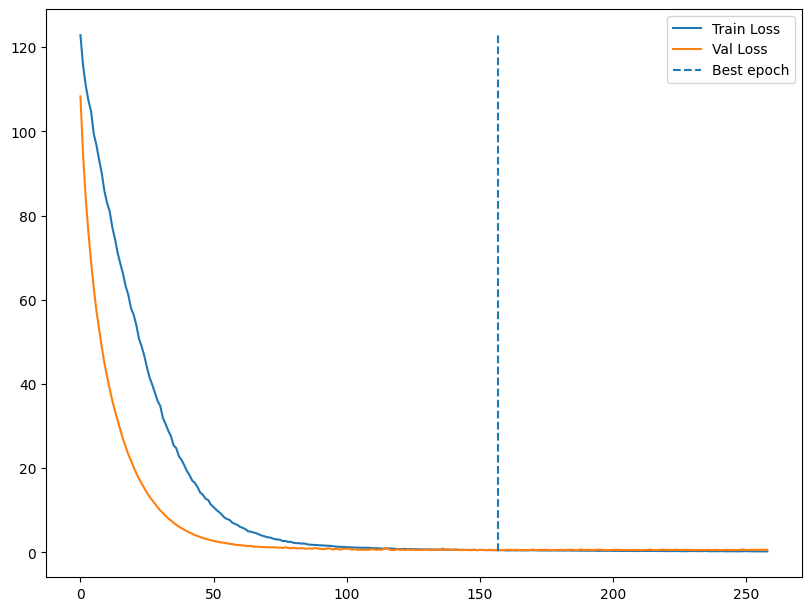

(20000, 555)
(20000,)
Train - f1=0.8037 recall=0.8866 precision=0.7350 log-loss=0.2730 opt-log-loss=0.2568
(20000, 62)
(20000,)
Test  - f1=0.5714 recall=0.5455 precision=0.6000 log-loss=0.9300 opt-log-loss=0.7089

-- Fold # 8/10 - Repeat #1/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1728 - Val: 0.2864 at epoch 321.
Restore the best model.


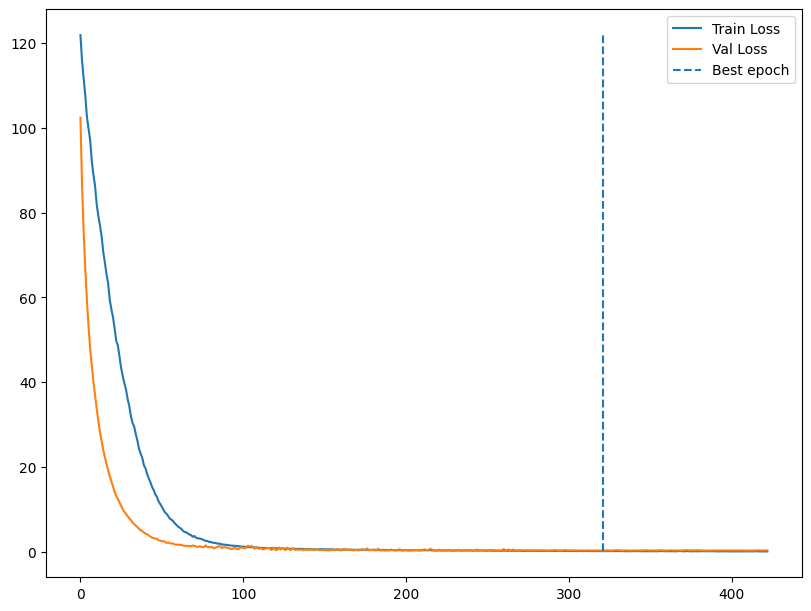

(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0266 opt-log-loss=0.0137
(20000, 61)
(20000,)
Test  - f1=0.7826 recall=0.8182 precision=0.7500 log-loss=0.3604 opt-log-loss=0.2509

-- Fold # 8/10 - Repeat #2/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.5483 - Val: 0.3537 at epoch 158.
Restore the best model.


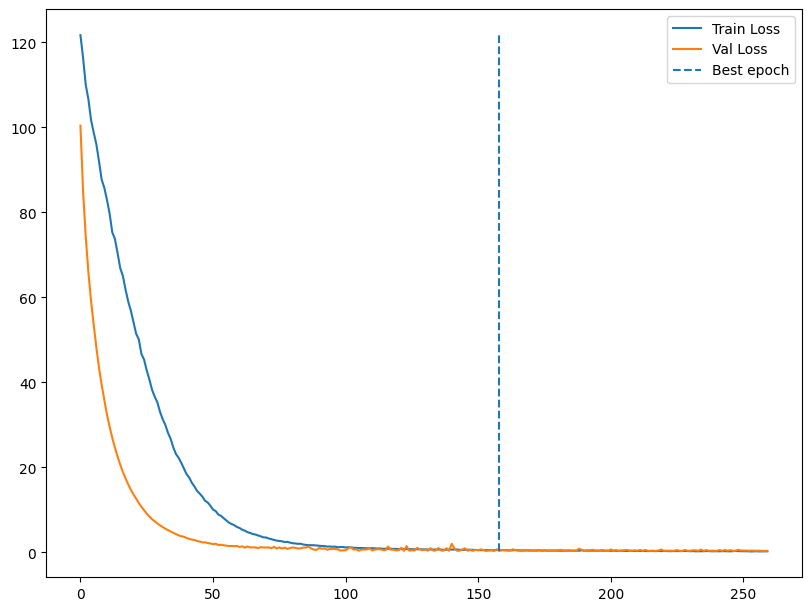

(20000, 556)
(20000,)
Train - f1=0.8254 recall=0.8041 precision=0.8478 log-loss=0.2615 opt-log-loss=0.2074
(20000, 61)
(20000,)
Test  - f1=0.7000 recall=0.6364 precision=0.7778 log-loss=0.4300 opt-log-loss=0.3425

-- Fold # 8/10 - Repeat #3/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3502 - Val: 0.2836 at epoch 216.
Restore the best model.


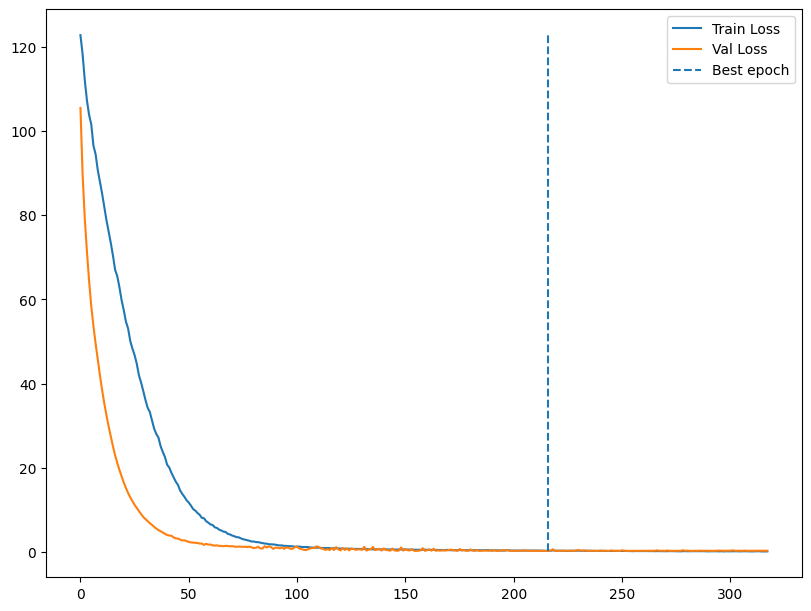

(20000, 556)
(20000,)
Train - f1=0.9254 recall=0.9588 precision=0.8942 log-loss=0.1071 opt-log-loss=0.0975
(20000, 61)
(20000,)
Test  - f1=0.8333 recall=0.9091 precision=0.7692 log-loss=0.2486 opt-log-loss=0.2221

-- Fold # 8/10 - Repeat #4/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1843 - Val: 0.2863 at epoch 281.
Restore the best model.


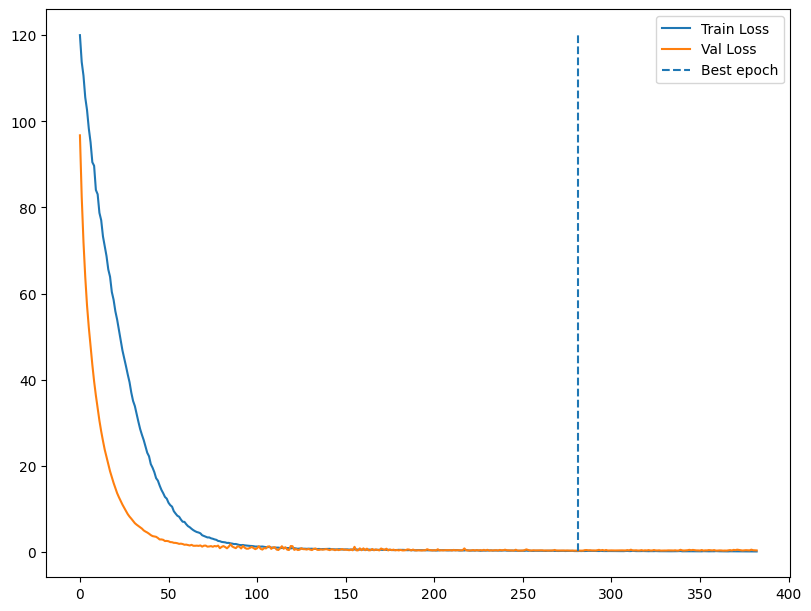

(20000, 556)
(20000,)
Train - f1=0.9848 recall=1.0000 precision=0.9700 log-loss=0.0376 opt-log-loss=0.0331
(20000, 61)
(20000,)
Test  - f1=0.6667 recall=0.6364 precision=0.7000 log-loss=0.3384 opt-log-loss=0.2349

-- Fold # 8/10 - Repeat #5/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2351 - Val: 0.3224 at epoch 280.
Restore the best model.


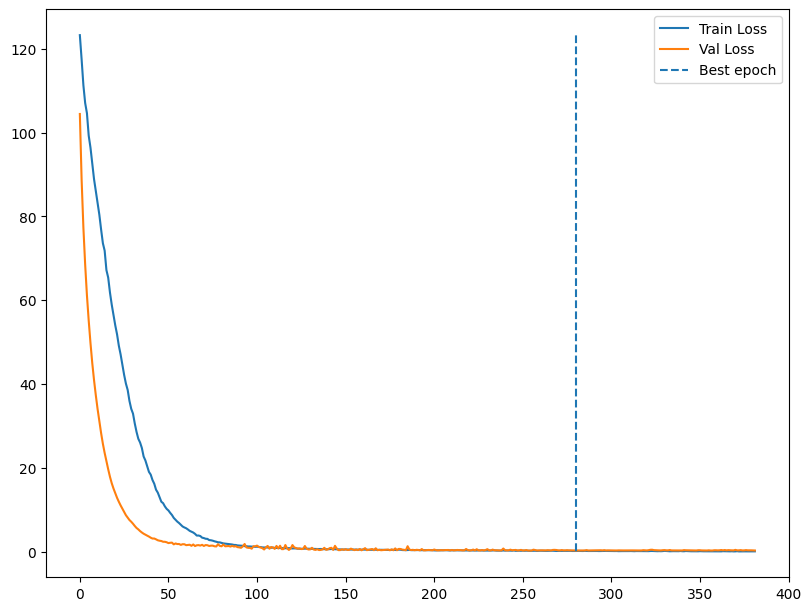

(20000, 556)
(20000,)
Train - f1=0.9846 recall=0.9897 precision=0.9796 log-loss=0.0470 opt-log-loss=0.0570
(20000, 61)
(20000,)
Test  - f1=0.6957 recall=0.7273 precision=0.6667 log-loss=0.3131 opt-log-loss=0.2762

-- Fold # 8/10 - Repeat #6/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3678 - Val: 0.3390 at epoch 217.
Restore the best model.


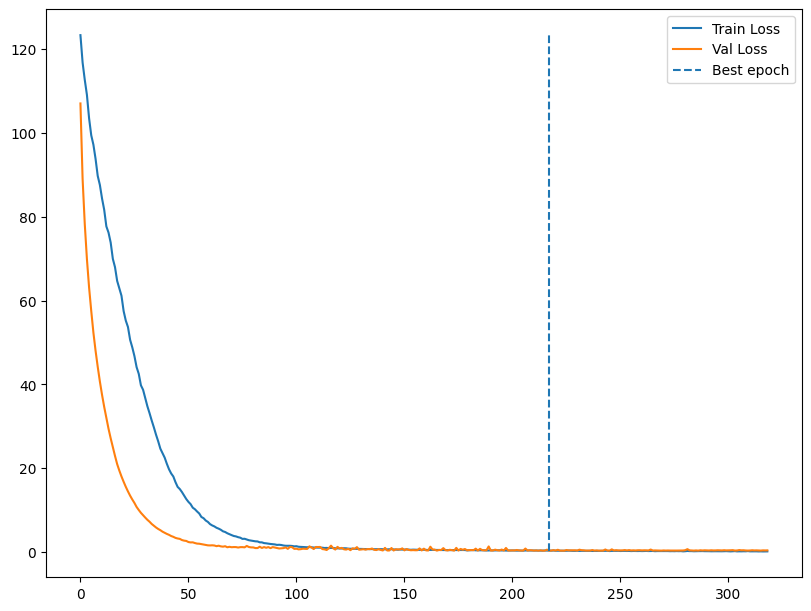

(20000, 556)
(20000,)
Train - f1=0.9293 recall=0.9485 precision=0.9109 log-loss=0.1282 opt-log-loss=0.1151
(20000, 61)
(20000,)
Test  - f1=0.7273 recall=0.7273 precision=0.7273 log-loss=0.4464 opt-log-loss=0.3389

-- Fold # 8/10 - Repeat #7/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1826 - Val: 0.3623 at epoch 319.
Restore the best model.


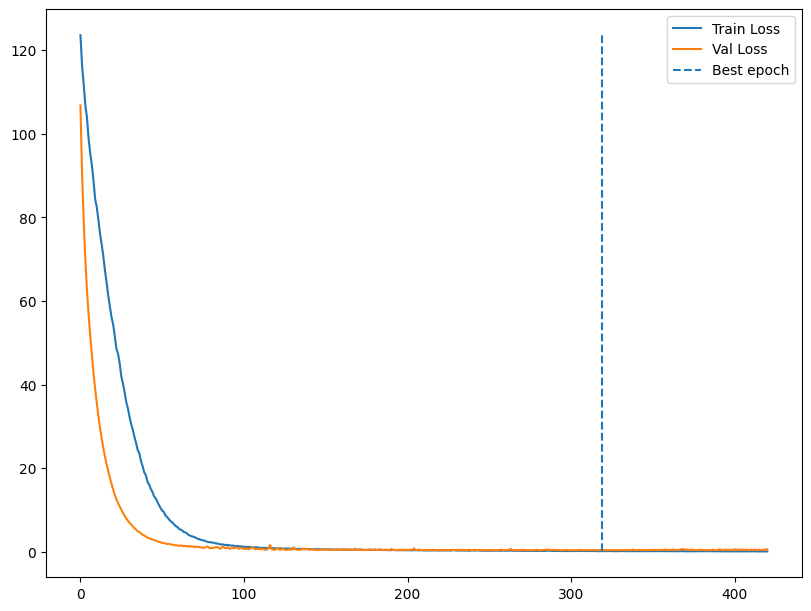

(20000, 556)
(20000,)
Train - f1=0.9949 recall=1.0000 precision=0.9898 log-loss=0.0192 opt-log-loss=0.0299
(20000, 61)
(20000,)
Test  - f1=0.8000 recall=0.9091 precision=0.7143 log-loss=0.3831 opt-log-loss=0.3683

-- Fold # 8/10 - Repeat #8/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3646 - Val: 0.3325 at epoch 205.
Restore the best model.


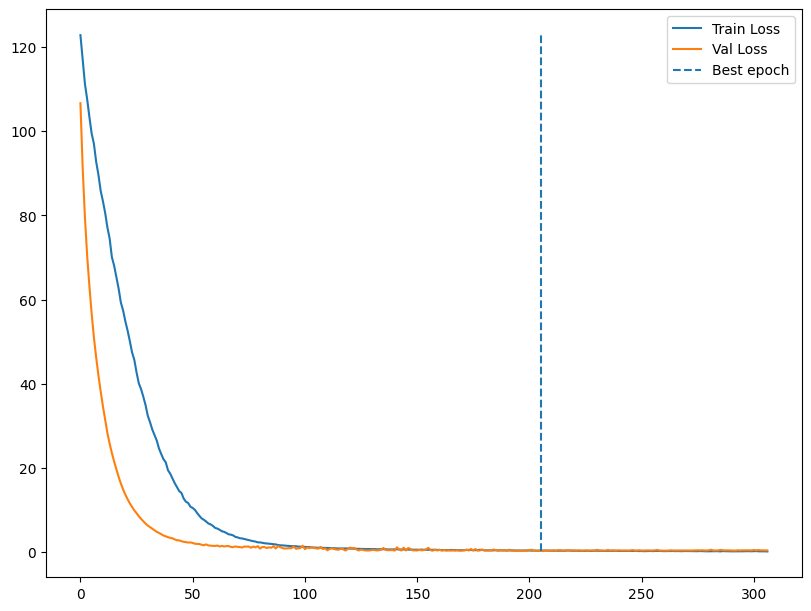

(20000, 556)
(20000,)
Train - f1=0.8854 recall=0.8763 precision=0.8947 log-loss=0.1863 opt-log-loss=0.1348
(20000, 61)
(20000,)
Test  - f1=0.7619 recall=0.7273 precision=0.8000 log-loss=0.4336 opt-log-loss=0.3067

-- Fold # 8/10 - Repeat #9/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3910 - Val: 0.3534 at epoch 199.
Restore the best model.


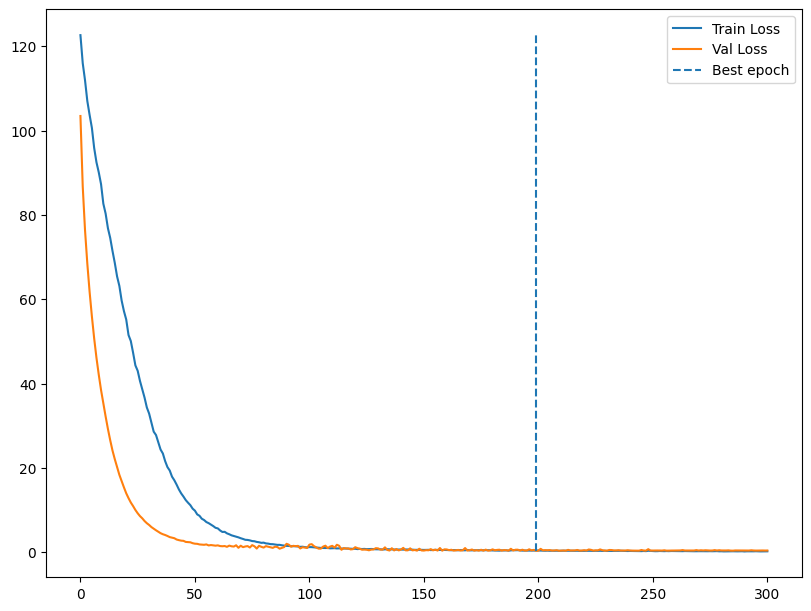

(20000, 556)
(20000,)
Train - f1=0.8912 recall=0.8866 precision=0.8958 log-loss=0.1572 opt-log-loss=0.1241
(20000, 61)
(20000,)
Test  - f1=0.6667 recall=0.6364 precision=0.7000 log-loss=0.4296 opt-log-loss=0.3425

-- Fold # 8/10 - Repeat #10/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3329 - Val: 0.3571 at epoch 214.
Restore the best model.


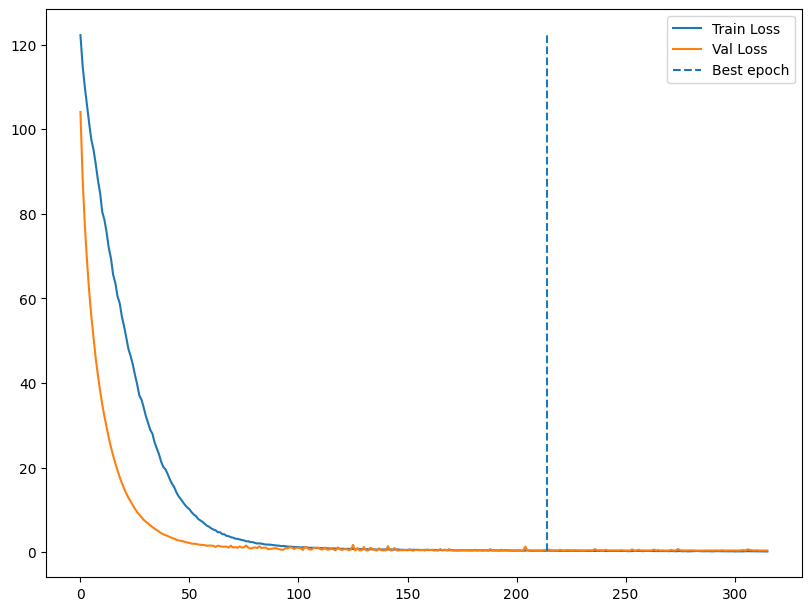

(20000, 556)
(20000,)
Train - f1=0.9360 recall=0.9794 precision=0.8962 log-loss=0.1006 opt-log-loss=0.1012
(20000, 61)
(20000,)
Test  - f1=0.7273 recall=0.7273 precision=0.7273 log-loss=0.3621 opt-log-loss=0.3150

-- Fold # 9/10 - Repeat #1/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4763 - Val: 0.4064 at epoch 167.
Restore the best model.


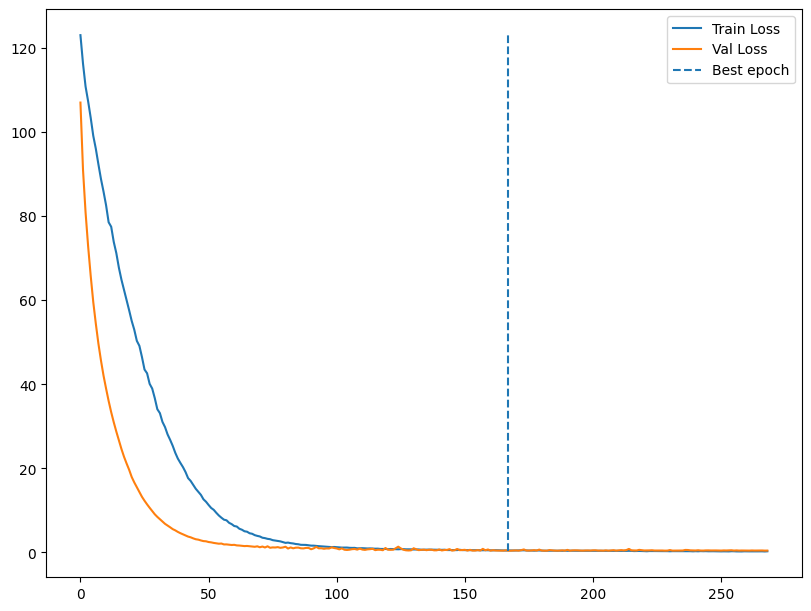

(20000, 556)
(20000,)
Train - f1=0.7657 recall=0.6837 precision=0.8701 log-loss=0.3610 opt-log-loss=0.1963
(20000, 61)
(20000,)
Test  - f1=0.6316 recall=0.6000 precision=0.6667 log-loss=0.7651 opt-log-loss=0.5899

-- Fold # 9/10 - Repeat #2/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1413 - Val: 0.3134 at epoch 334.
Restore the best model.


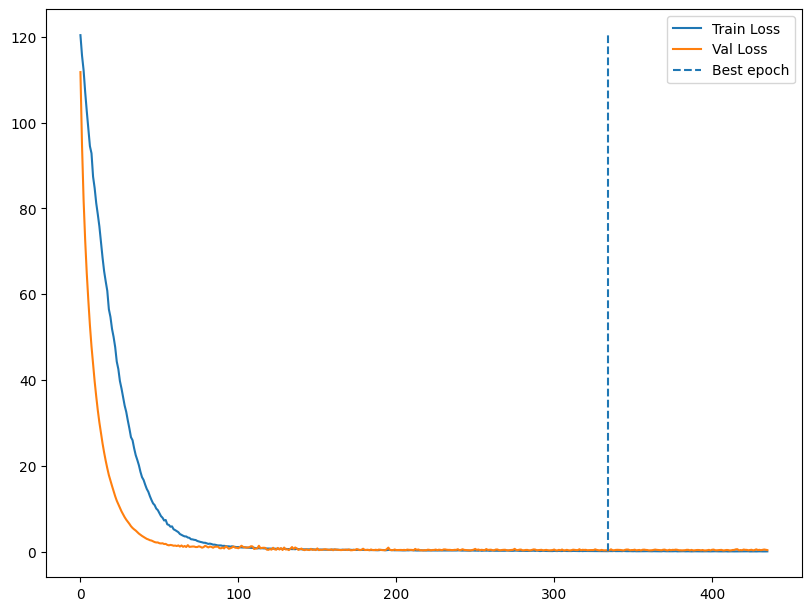

(20000, 556)
(20000,)
Train - f1=0.9231 recall=0.8571 precision=1.0000 log-loss=0.1413 opt-log-loss=0.0372
(20000, 61)
(20000,)
Test  - f1=0.8421 recall=0.8000 precision=0.8889 log-loss=0.6289 opt-log-loss=0.4485

-- Fold # 9/10 - Repeat #3/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2173 - Val: 0.3162 at epoch 270.
Restore the best model.


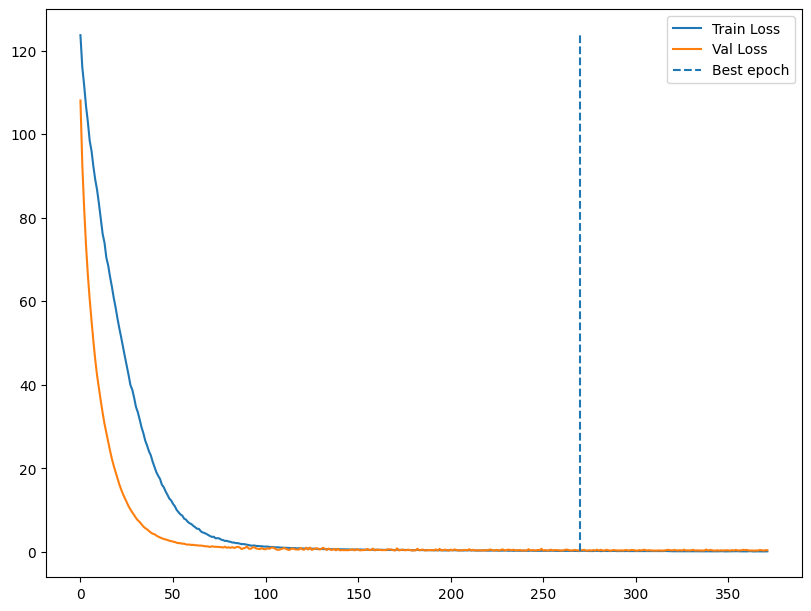

(20000, 556)
(20000,)
Train - f1=0.9634 recall=0.9388 precision=0.9892 log-loss=0.0925 opt-log-loss=0.0424
(20000, 61)
(20000,)
Test  - f1=0.8889 recall=0.8000 precision=1.0000 log-loss=0.5938 opt-log-loss=0.4904

-- Fold # 9/10 - Repeat #4/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1147 - Val: 0.3278 at epoch 399.
Restore the best model.


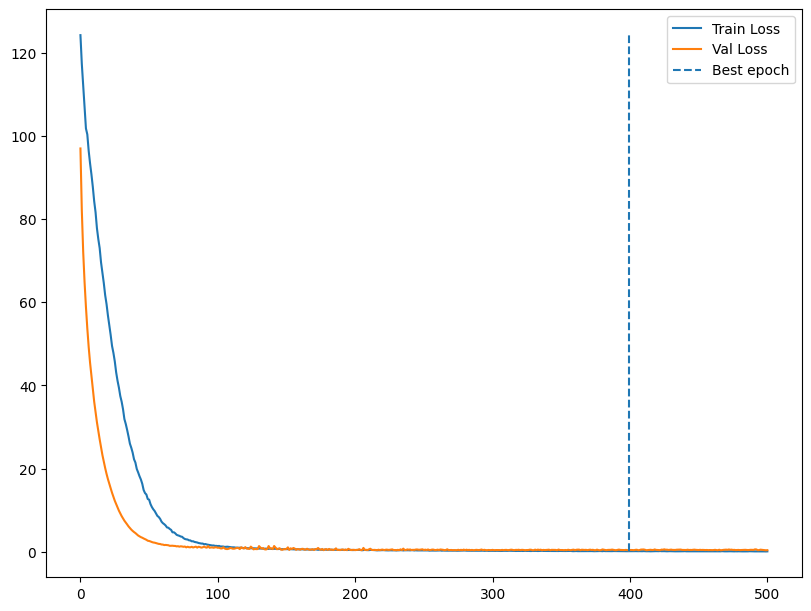

(20000, 556)
(20000,)
Train - f1=0.9949 recall=0.9898 precision=1.0000 log-loss=0.0534 opt-log-loss=0.0167
(20000, 61)
(20000,)
Test  - f1=0.8000 recall=0.8000 precision=0.8000 log-loss=0.6158 opt-log-loss=0.4816

-- Fold # 9/10 - Repeat #5/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4320 - Val: 0.3847 at epoch 181.
Restore the best model.


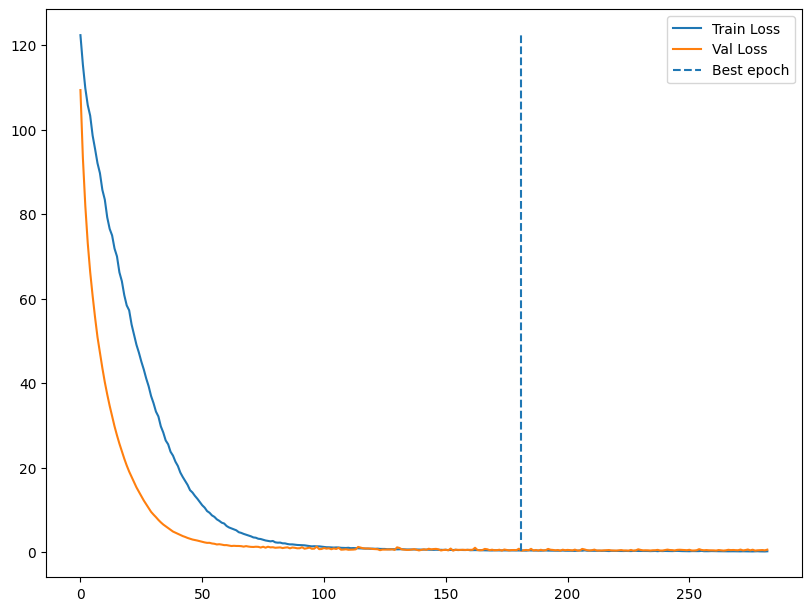

(20000, 556)
(20000,)
Train - f1=0.8744 recall=0.8878 precision=0.8614 log-loss=0.1899 opt-log-loss=0.1490
(20000, 61)
(20000,)
Test  - f1=0.6667 recall=0.7000 precision=0.6364 log-loss=0.6895 opt-log-loss=0.5513

-- Fold # 9/10 - Repeat #6/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2519 - Val: 0.3546 at epoch 254.
Restore the best model.


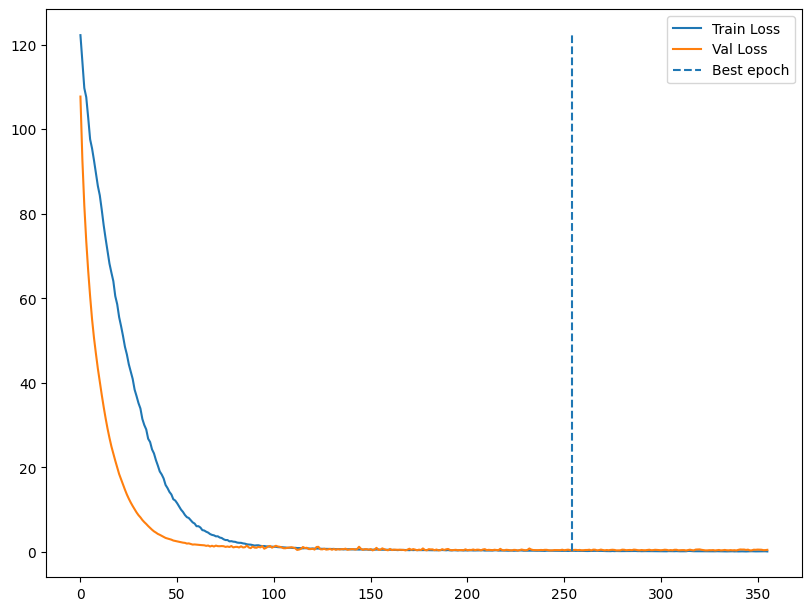

(20000, 556)
(20000,)
Train - f1=0.8070 recall=0.7041 precision=0.9452 log-loss=0.3109 opt-log-loss=0.1058
(20000, 61)
(20000,)
Test  - f1=0.8000 recall=0.8000 precision=0.8000 log-loss=0.7075 opt-log-loss=0.5061

-- Fold # 9/10 - Repeat #7/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.0758 - Val: 0.3079 at epoch 420.
Restore the best model.


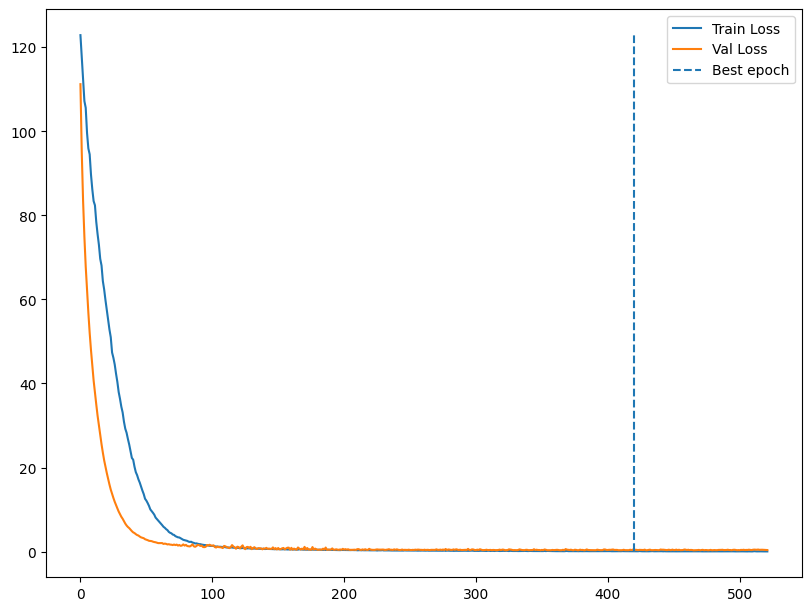

(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0222 opt-log-loss=0.0068
(20000, 61)
(20000,)
Test  - f1=0.8421 recall=0.8000 precision=0.8889 log-loss=0.6298 opt-log-loss=0.5077

-- Fold # 9/10 - Repeat #8/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.0213 - Val: 0.2239 at epoch 693.
Restore the best model.


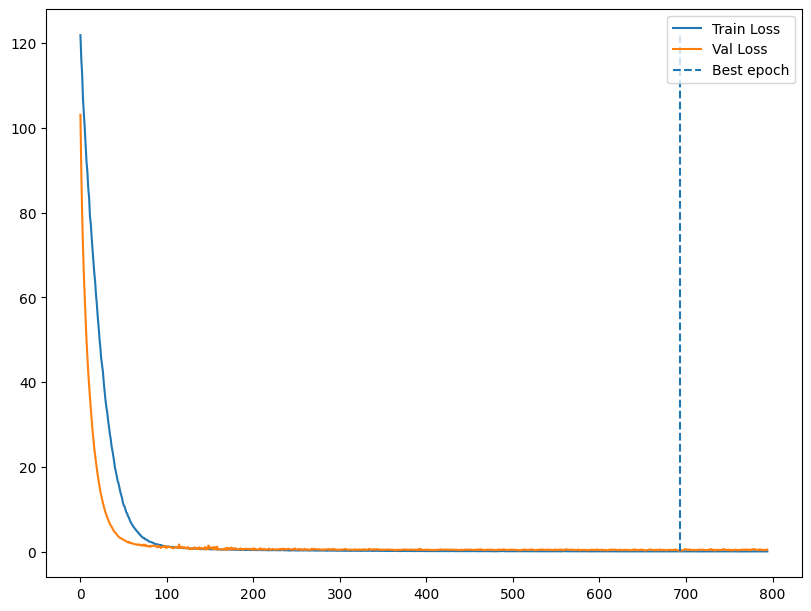

(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0045 opt-log-loss=0.0041
(20000, 61)
(20000,)
Test  - f1=0.8421 recall=0.8000 precision=0.8889 log-loss=0.5398 opt-log-loss=0.4030

-- Fold # 9/10 - Repeat #9/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2038 - Val: 0.3809 at epoch 326.
Restore the best model.


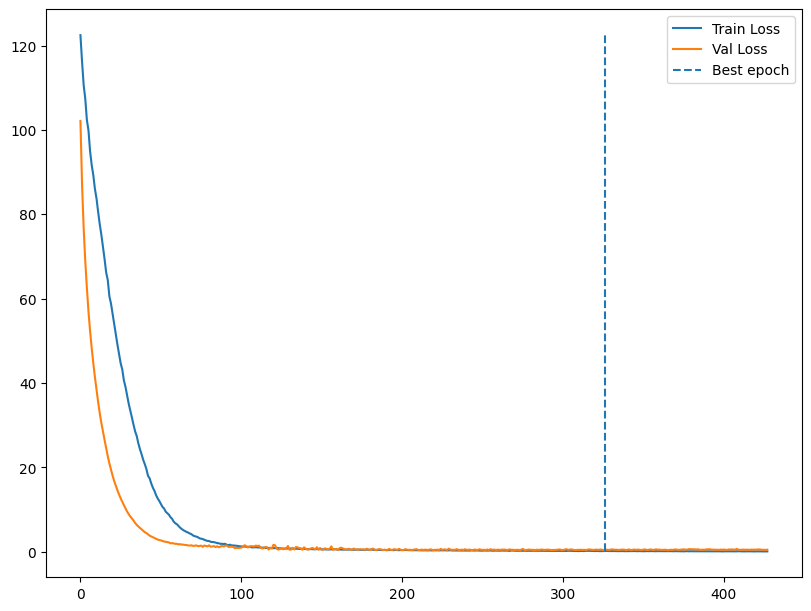

(20000, 556)
(20000,)
Train - f1=0.9846 recall=0.9796 precision=0.9897 log-loss=0.0585 opt-log-loss=0.0261
(20000, 61)
(20000,)
Test  - f1=0.8000 recall=0.8000 precision=0.8000 log-loss=0.6880 opt-log-loss=0.5547

-- Fold # 9/10 - Repeat #10/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.0858 - Val: 0.3098 at epoch 503.
Restore the best model.


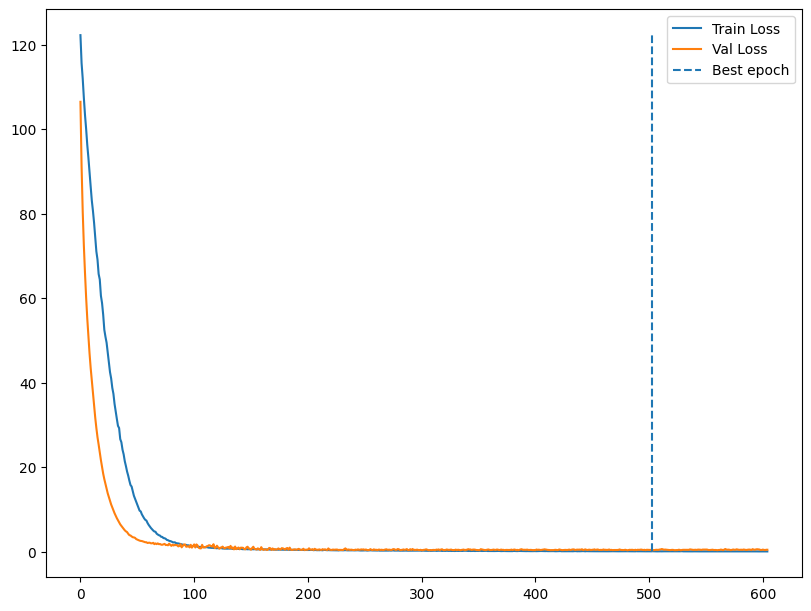

(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0402 opt-log-loss=0.0112
(20000, 61)
(20000,)
Test  - f1=0.7619 recall=0.8000 precision=0.7273 log-loss=0.5294 opt-log-loss=0.4120

-- Fold # 10/10 - Repeat #1/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2280 - Val: 0.2902 at epoch 306.
Restore the best model.


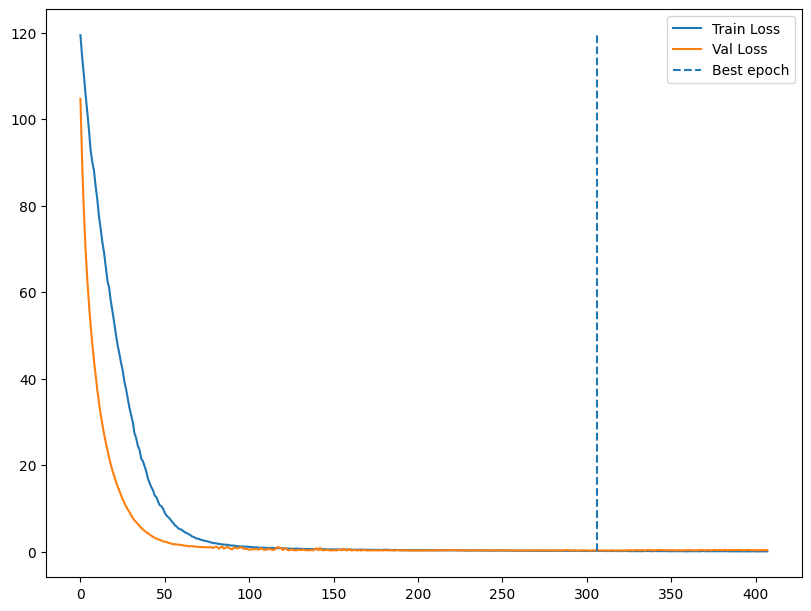

(20000, 556)
(20000,)
Train - f1=0.9849 recall=1.0000 precision=0.9703 log-loss=0.0235 opt-log-loss=0.0440
(20000, 61)
(20000,)
Test  - f1=0.7368 recall=0.7000 precision=0.7778 log-loss=0.4380 opt-log-loss=0.3186

-- Fold # 10/10 - Repeat #2/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3390 - Val: 0.2978 at epoch 230.
Restore the best model.


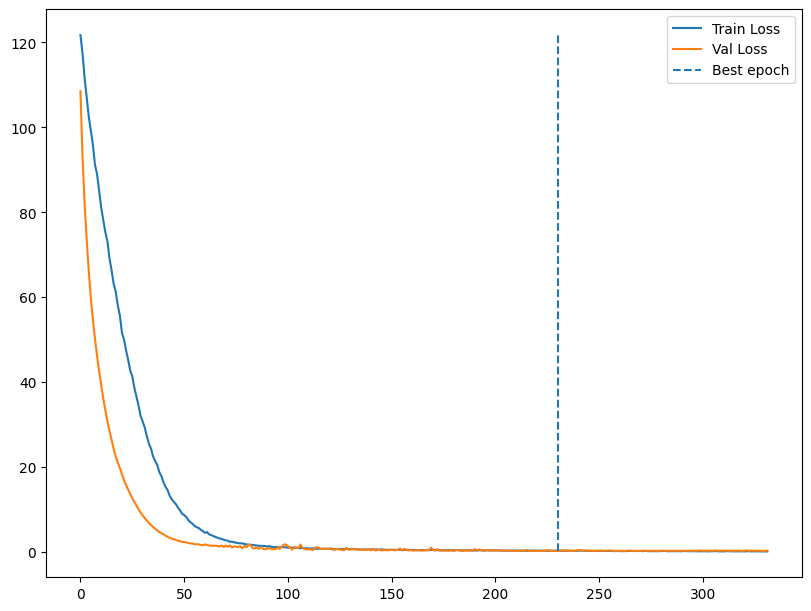

(20000, 556)
(20000,)
Train - f1=0.9557 recall=0.9898 precision=0.9238 log-loss=0.1107 opt-log-loss=0.1021
(20000, 61)
(20000,)
Test  - f1=0.6000 recall=0.6000 precision=0.6000 log-loss=0.4852 opt-log-loss=0.3511

-- Fold # 10/10 - Repeat #3/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1996 - Val: 0.3301 at epoch 270.
Restore the best model.


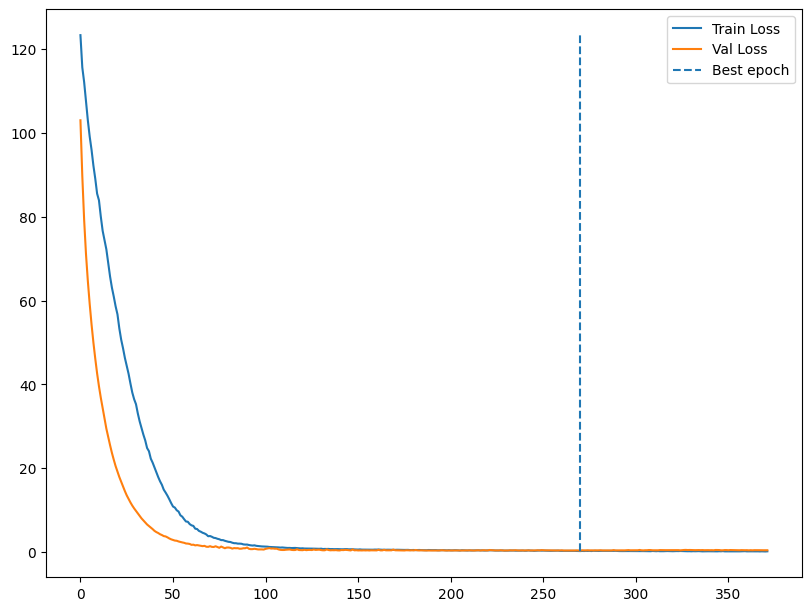

(20000, 556)
(20000,)
Train - f1=0.9600 recall=0.9796 precision=0.9412 log-loss=0.0673 opt-log-loss=0.0703
(20000, 61)
(20000,)
Test  - f1=0.7778 recall=0.7000 precision=0.8750 log-loss=0.6151 opt-log-loss=0.4241

-- Fold # 10/10 - Repeat #4/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1733 - Val: 0.2954 at epoch 359.
Restore the best model.


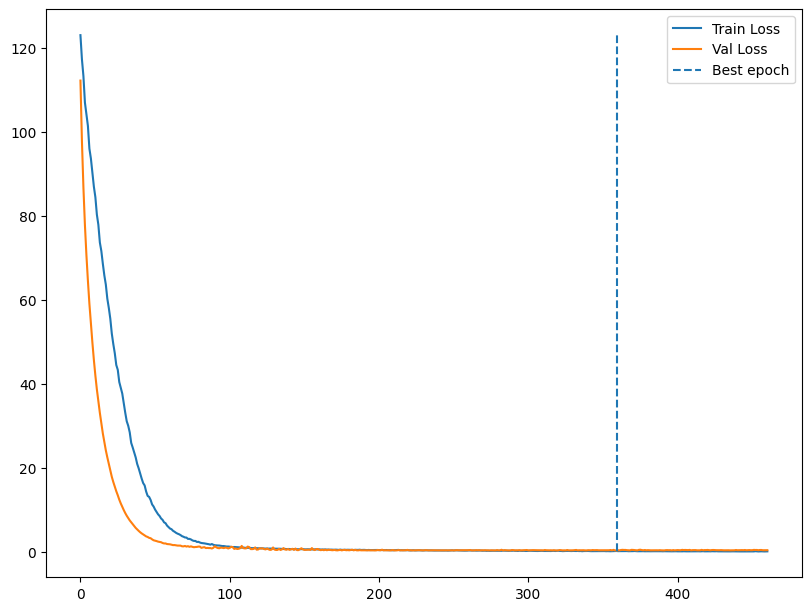

(20000, 556)
(20000,)
Train - f1=0.9949 recall=1.0000 precision=0.9899 log-loss=0.0126 opt-log-loss=0.0333
(20000, 61)
(20000,)
Test  - f1=0.8421 recall=0.8000 precision=0.8889 log-loss=0.4260 opt-log-loss=0.3305

-- Fold # 10/10 - Repeat #5/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3685 - Val: 0.3011 at epoch 214.
Restore the best model.


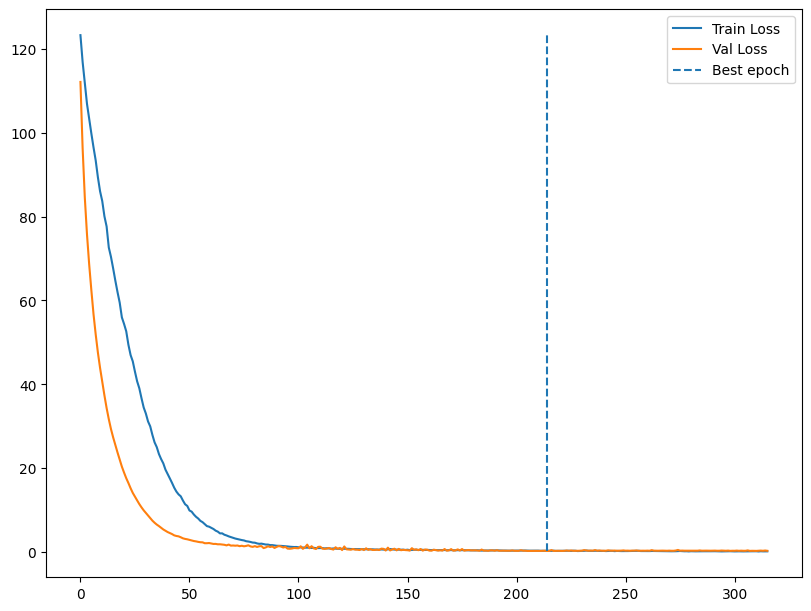

(20000, 556)
(20000,)
Train - f1=0.9057 recall=0.9796 precision=0.8421 log-loss=0.1090 opt-log-loss=0.1171
(20000, 61)
(20000,)
Test  - f1=0.7778 recall=0.7000 precision=0.8750 log-loss=0.4402 opt-log-loss=0.2976

-- Fold # 10/10 - Repeat #6/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2998 - Val: 0.2597 at epoch 247.
Restore the best model.


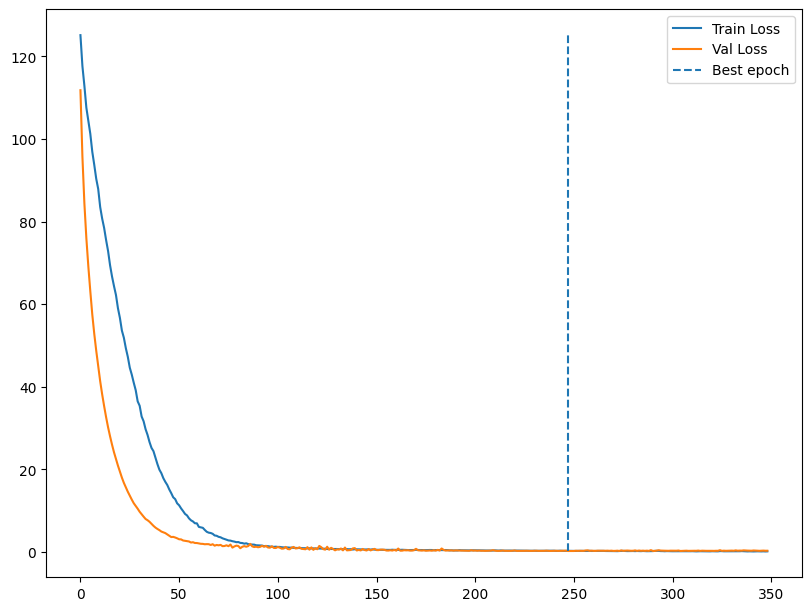

(20000, 556)
(20000,)
Train - f1=0.9423 recall=1.0000 precision=0.8909 log-loss=0.0619 opt-log-loss=0.0901
(20000, 61)
(20000,)
Test  - f1=0.8421 recall=0.8000 precision=0.8889 log-loss=0.4013 opt-log-loss=0.2975

-- Fold # 10/10 - Repeat #7/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2560 - Val: 0.2919 at epoch 262.
Restore the best model.


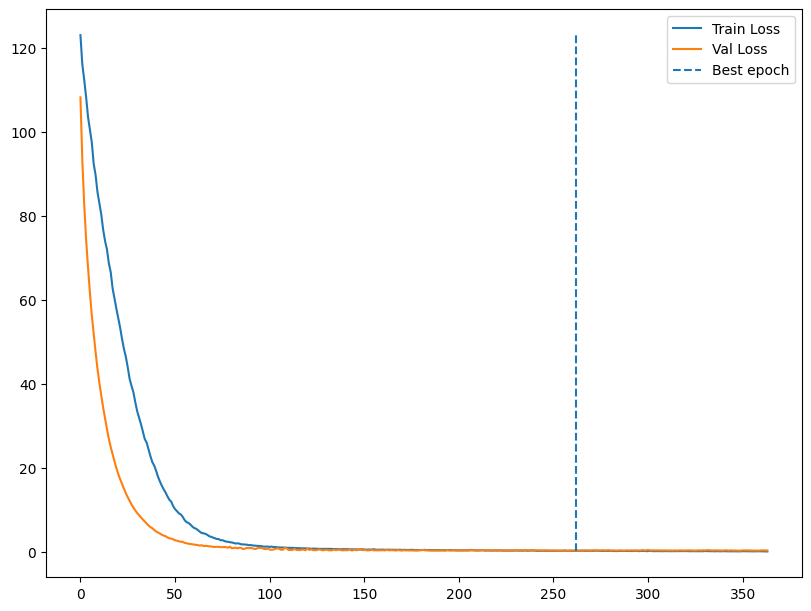

(20000, 556)
(20000,)
Train - f1=0.9700 recall=0.9898 precision=0.9510 log-loss=0.0591 opt-log-loss=0.0724
(20000, 61)
(20000,)
Test  - f1=0.7000 recall=0.7000 precision=0.7000 log-loss=0.4844 opt-log-loss=0.3488

-- Fold # 10/10 - Repeat #8/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2271 - Val: 0.2604 at epoch 275.
Restore the best model.


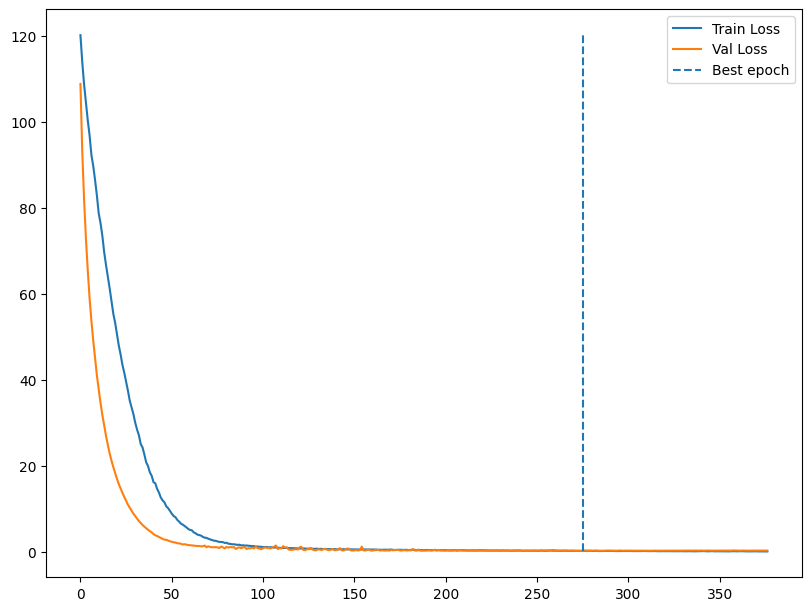

(20000, 556)
(20000,)
Train - f1=0.9463 recall=0.9898 precision=0.9065 log-loss=0.0511 opt-log-loss=0.0836
(20000, 61)
(20000,)
Test  - f1=0.8421 recall=0.8000 precision=0.8889 log-loss=0.3872 opt-log-loss=0.2965

-- Fold # 10/10 - Repeat #9/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2110 - Val: 0.3485 at epoch 316.
Restore the best model.


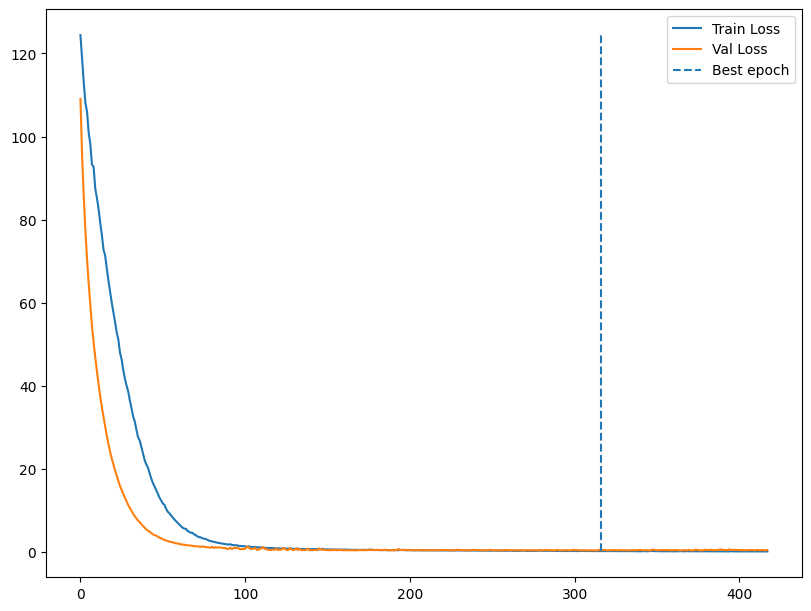

(20000, 556)
(20000,)
Train - f1=0.9800 recall=1.0000 precision=0.9608 log-loss=0.0263 opt-log-loss=0.0455
(20000, 61)
(20000,)
Test  - f1=0.8000 recall=0.8000 precision=0.8000 log-loss=0.5350 opt-log-loss=0.4229

-- Fold # 10/10 - Repeat #10/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3607 - Val: 0.2859 at epoch 202.
Restore the best model.


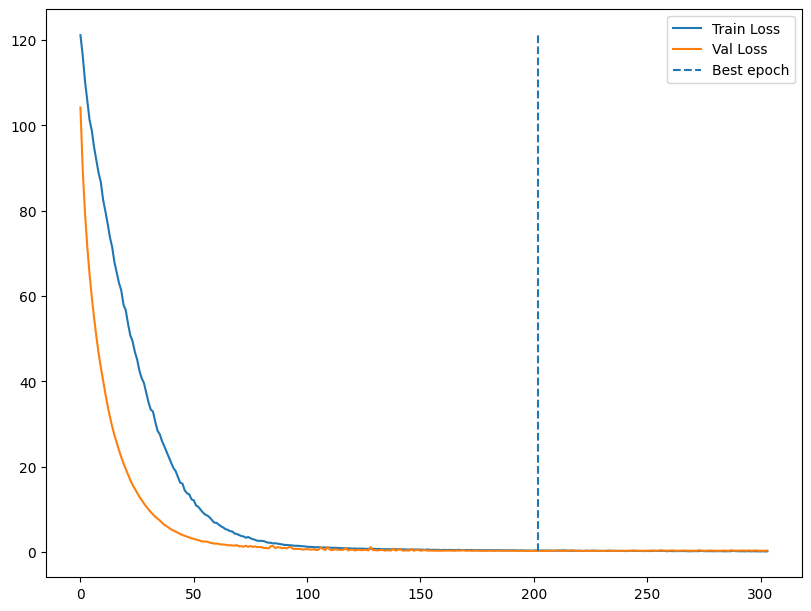

(20000, 556)
(20000,)
Train - f1=0.8398 recall=0.9898 precision=0.7293 log-loss=0.1307 opt-log-loss=0.1757
(20000, 61)
(20000,)
Test  - f1=0.7778 recall=0.7000 precision=0.8750 log-loss=0.3655 opt-log-loss=0.2739


In [18]:
def balanced_log_loss(y_true, pred_prob):
    nb_class_0 = np.sum(1 - y_true)
    nb_class_1 = np.sum(y_true)

    prob_0 = np.clip(1. - pred_prob, 1e-10, 1. - 1e-10)
    prob_1 = np.clip(pred_prob, 1e-10, 1. - 1e-10)
    return (-np.sum((1 - y_true) * np.log(prob_0)) / nb_class_0
            - np.sum(y_true * np.log(prob_1)) / nb_class_1) / 2.


def calculate_optimal_prob_prediction(y_preds):
    """
    Calculate the best probability prediction based on the formula
    (in experiment 04_logistics_bayesian_v4*).

    y_preds: numpy array of shape (nb_draws, nb_data_points).
    """
    assert y_preds.ndim == 2, "Only accept 2d numpy array as input."
    _, nb_data = y_preds.shape
    print(y_preds.shape)

    # Calculate number of classes for each draw.
    nb_class_0 = np.sum(1 - y_preds, axis=1)
    print(nb_class_0.shape)
    nb_class_1 = np.sum(y_preds, axis=1)

    best_probs = []
    eps = 1e-15
    for j in range(nb_data):
        cj = np.sum(y_preds[:, j] / (nb_class_1 + eps))
        cj_1 = np.sum((1 - y_preds[:, j]) / (nb_class_0 + eps))

        prob = cj / (cj + cj_1)
        best_probs.append(prob)

    return np.asarray(best_probs)


def estimate_optimal_prob_pred(y_prob, nb_samples: int = 20000):
    ys = bernoulli.rvs(y_prob[:, None], size=(y_prob.shape[0], nb_samples))
    return calculate_optimal_prob_prediction(ys.T)


def f1_recall_precision(y_true, y_pred):
    return tuple(f(y_true, y_pred)
                 for f in [f1_score, recall_score, precision_score])


def plot_train_history(history: dict, epochs: int):
    fig, ax = plt.subplots(figsize=(8, 6), layout='constrained')

    train_loss = history['train_loss']
    val_loss = history['val_loss']

    epochs = list(range(len(train_loss)))
    ax.plot(epochs, train_loss, label='Train Loss')
    ax.plot(epochs, val_loss, label='Val Loss')
    ax.vlines(
        history['best_epoch'],
        ymin=min(min(train_loss), min(val_loss)),
        ymax=max(max(train_loss), max(val_loss)),
        label='Best epoch',
        linestyles='dashed')
    ax.legend()

    return fig


def train_and_evaluate(*,
                       Xtr, gtr, ytr,
                       Xte, gte, yte,
                       epochs: int = 100,
                       device: str = 'cpu',
                       lr: float = 1e-3,
                       train_noise: float = 0.0,
                       early_stopping_patience: int = 100,
                       correlation_threshold: float = 0.3,
                       weight_decay: float = 1e-2,
                       regularization_weight: float = 1.0):
    # First, we will normalize the data.
    Xtr = pd.DataFrame(
        preprocessing.fit_transform(Xtr, ytr),
        columns=Xtr.columns)
    Xte = pd.DataFrame(
        preprocessing.transform(Xte),
        columns=Xte.columns)

    # Next, we'll filter out correlated features.
    Xtr = filter_in_uncorrelated_features(
        Xtr, correlation_threshold=correlation_threshold)
    Xte = Xte[Xtr.columns]

    # Store original training dataset.
    Xtr_orig = Xtr.copy()
    Xtr_orig['ej'] = gtr
    ytr_orig = ytr.copy()
    print(f'Before sampling, has {len(ytr_orig)} sammples,\n'
          f'in which there are {ytr_orig.sum()} positive samples.')

    # Next, we'll perform sampling.
    Xtr['ej'] = gtr
    Xte['ej'] = gte

    Xtr, ytr = sampling(Xtr, ytr)
    print(f'After sampling, has {len(ytr)} sammples,\n'
          f'in which there are {ytr.sum()} positive samples.')

    # Then, we use tree-based model to select important features.
    # Xtr = select_important_features(
    #     Xtr, ytr,
    #     n_estimators=1000,
    #     important_thresholds='5*median')
    # Xte = Xte[Xtr.columns]
    nb_features = len(Xtr.columns)
    print('Number of important features: ', nb_features)

    # Training neural network model.
    # print(Xtr.values, ytr[:, None])
    X_train_ds = TensorDataset(
        torch.tensor(Xtr.values, dtype=torch.float32),
        torch.tensor(ytr[:, None], dtype=torch.float32))
    X_val_ds = TensorDataset(
        torch.tensor(Xte.values, dtype=torch.float32),
        torch.tensor(yte[:, None], dtype=torch.float32))

    Xtr_dataloader = DataLoader(X_train_ds, batch_size=64, shuffle=True)
    Xva_dataloader = DataLoader(X_val_ds, batch_size=64)

    model, history = train(NNClassifier(nb_features),
                           train_ds=Xtr_dataloader,
                           val_ds=Xva_dataloader,
                           epochs=epochs,
                           early_stopping_patience=early_stopping_patience,
                           device=device,
                           lr=lr,
                           weight_decay=weight_decay,
                           regularization_weight=regularization_weight,
                           train_noise=train_noise)

    # Plot training history.
    fig = plot_train_history(history, epochs=epochs)
    plt.show()
    plt.close(fig)

    # Evaluate the model.
    ytr_prob = (model(
        torch.tensor(Xtr_orig.values, dtype=torch.float32).to(device))
        .cpu().detach().numpy().squeeze())
    ytr_opt_prob = estimate_optimal_prob_pred(ytr_prob)
    ytr_pred = np.where(ytr_prob > 0.5, 1., 0.)
    (f1_train,
     recall_train,
     precision_train) = f1_recall_precision(ytr_orig, ytr_pred)
    log_loss_train = balanced_log_loss(ytr_orig, ytr_prob)
    opt_log_loss_train = balanced_log_loss(ytr_orig, ytr_opt_prob)
    print(f'Train - f1={f1_train:.4f} recall={recall_train:.4f} '
          f'precision={precision_train:.4f} log-loss={log_loss_train:.4f} '
          f'opt-log-loss={opt_log_loss_train:.4f}')

    yte_prob = (model(
        torch.tensor(Xte.values, dtype=torch.float32).to(device))
        .cpu().detach().numpy().squeeze())
    yte_opt_prob = estimate_optimal_prob_pred(yte_prob)
    yte_pred = np.where(yte_prob > 0.5, 1., 0.)
    (f1_test,
     recall_test,
     precision_test) = f1_recall_precision(yte, yte_pred)
    log_loss_test = balanced_log_loss(yte, yte_prob)
    opt_log_loss_test = balanced_log_loss(yte, yte_opt_prob)
    print(f'Test  - f1={f1_test:.4f} recall={recall_test:.4f} '
          f'precision={precision_test:.4f} log-loss={log_loss_test:.4f} '
          f'opt-log-loss={opt_log_loss_test:.4f}')

    return dict(
        f1_train=f1_train,
        f1_test=f1_test,
        log_loss_train=log_loss_train,
        opt_log_loss_train=opt_log_loss_train,
        log_loss_test=log_loss_test,
        opt_log_loss_test=opt_log_loss_test,
    )


def cross_validations(*, X, grp, y,
                      n_folds: int = 10,
                      repeats_per_fold: int = 1,
                      **kwargs):
    results = []

    kfolds = StratifiedKFold(n_splits=n_folds)
    for fold, (train_idx, test_idx) in enumerate(kfolds.split(X, y)):
        for repeat in range(repeats_per_fold):
            print(f'\n-- Fold # {fold + 1}/{n_folds} - '
                  f'Repeat #{repeat + 1}/{repeats_per_fold}:')

            Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]
            gtr, gte = grp[train_idx], grp[test_idx]
            ytr, yte = y[train_idx], y[test_idx]

            result = train_and_evaluate(
                Xtr=Xtr, gtr=gtr, ytr=ytr,
                Xte=Xte, gte=gte, yte=yte,
                **kwargs)

            result['fold'] = fold + 1
            result['repeat'] = repeat + 1
            results.append(result)

    return pd.DataFrame(results)


cv_results = cross_validations(
    X=Xtrain_df,
    grp=ej.cat.codes.values,
    y=y,
    n_folds=10,
    repeats_per_fold=10,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    epochs=2000,
    correlation_threshold=0.3,
    lr=1e-4,
    early_stopping_patience=100,
    weight_decay=1e-2,
    regularization_weight=1.0,
    train_noise=0.01)

In [19]:
cv_results

f1_train   f1_test  log_loss_train  opt_log_loss_train  log_loss_test  \
0   0.989583  0.818182        0.071976            0.053715       0.187193   
1   0.979592  0.869565        0.028367            0.042103       0.210164   
2   0.974093  0.761905        0.056434            0.047790       0.358154   
3   0.989691  0.782609        0.023461            0.029541       0.197268   
4   0.973822  0.782609        0.081560            0.056390       0.243561   
..       ...       ...             ...                 ...            ...   
95  0.942308  0.842105        0.061894            0.090146       0.401303   
96  0.970000  0.700000        0.059106            0.072367       0.484441   
97  0.946341  0.842105        0.051079            0.083569       0.387160   
98  0.980000  0.800000        0.026327            0.045480       0.534957   
99  0.839827  0.777778        0.130681            0.175668       0.365459   

    opt_log_loss_test  fold  repeat  
0            0.141514     1       1  
1            0.190719     1       2  
2            0.246673     1       3  
3            0.171758     1       4  
4            0.180475     1       5  
..                ...   ...     ...  
95           0.297452    10       6  
96           0.348842    10       7  
97           0.296506    10       8  
98           0.422924    10       9  
99           0.273894    10      10  

[100 rows x 8 columns]

In [20]:
def get_optimal_cv_results_each_fold(results: pd.DataFrame,
                                     by: str,
                                     method: Literal['max', 'min'] = 'max'):
    folds = results.groupby('fold')

    optimal_results = []
    for fold, fold_results in folds:
        best_idx = (fold_results[by].argmax()
                    if method == 'max'
                    else fold_results[by].argmin())
        optimal_result = fold_results.iloc[best_idx].to_dict()
        optimal_results.append(optimal_result)

    return pd.DataFrame(optimal_results)

## Results
### Optimal F1 Test

In [21]:
# Optimal results per fold by f1_test.
cv_results_optimal_f1_test = get_optimal_cv_results_each_fold(
    cv_results, 'f1_test', 'max')
cv_results_optimal_f1_test

f1_train   f1_test  log_loss_train  opt_log_loss_train  log_loss_test  \
0  0.979592  0.869565        0.028367            0.042103       0.210164   
1  0.964467  0.909091        0.090443            0.088652       0.306749   
2  1.000000  0.869565        0.004253            0.004064       0.265552   
3  0.973822  0.952381        0.090496            0.036509       0.172269   
4  0.984772  0.956522        0.017513            0.043622       0.107846   
5  0.936842  0.727273        0.182927            0.131232       0.503898   
6  0.834171  0.666667        0.278960            0.225576       0.599265   
7  0.925373  0.833333        0.107067            0.097487       0.248593   
8  0.963351  0.888889        0.092479            0.042439       0.593830   
9  0.994924  0.842105        0.012581            0.033255       0.425986   

   opt_log_loss_test  fold  repeat  
0           0.190719   1.0     2.0  
1           0.222950   2.0     6.0  
2           0.216094   3.0     4.0  
3           0.122839   4.0     7.0  
4           0.110880   5.0     3.0  
5           0.391574   6.0    10.0  
6           0.439879   7.0     1.0  
7           0.222050   8.0     3.0  
8           0.490383   9.0     3.0  
9           0.330526  10.0     4.0

In [22]:
cv_results_optimal_f1_test.describe()

f1_train    f1_test  log_loss_train  opt_log_loss_train  \
count  10.000000  10.000000       10.000000           10.000000   
mean    0.955731   0.851539        0.090509            0.074494   
std     0.048791   0.092248        0.086304            0.064900   
min     0.834171   0.666667        0.004253            0.004064   
25%     0.943469   0.835526        0.020227            0.037908   
50%     0.969144   0.869565        0.090470            0.043031   
75%     0.983477   0.904040        0.103420            0.095278   
max     1.000000   0.956522        0.278960            0.225576   

       log_loss_test  opt_log_loss_test      fold     repeat  
count      10.000000          10.000000  10.00000  10.000000  
mean        0.343415           0.273790   5.50000   4.300000  
std         0.176282           0.131828   3.02765   2.668749  
min         0.107846           0.110880   1.00000   1.000000  
25%         0.219771           0.197063   3.25000   3.000000  
50%         0.286151           0.222500   5.50000   3.500000  
75%         0.484420           0.376312   7.75000   5.500000  
max         0.599265           0.490383  10.00000  10.000000

### Optimal `opt_log_loss_test`

In [23]:
cv_results_optimal_log_loss_test = get_optimal_cv_results_each_fold(
    cv_results, 'opt_log_loss_test', 'min')
cv_results_optimal_log_loss_test

f1_train   f1_test  log_loss_train  opt_log_loss_train  log_loss_test  \
0  0.989583  0.818182        0.071976            0.053715       0.187193   
1  0.964467  0.909091        0.090443            0.088652       0.306749   
2  0.979592  0.800000        0.061149            0.054598       0.213415   
3  0.973822  0.952381        0.090496            0.036509       0.172269   
4  0.979798  0.909091        0.021262            0.038754       0.151638   
5  0.936842  0.727273        0.182927            0.131232       0.503898   
6  0.834171  0.666667        0.278960            0.225576       0.599265   
7  0.925373  0.833333        0.107067            0.097487       0.248593   
8  1.000000  0.842105        0.004475            0.004069       0.539825   
9  0.839827  0.777778        0.130681            0.175668       0.365459   

   opt_log_loss_test  fold  repeat  
0           0.141514   1.0     1.0  
1           0.222950   2.0     6.0  
2           0.180991   3.0     3.0  
3           0.122839   4.0     7.0  
4           0.107231   5.0     7.0  
5           0.391574   6.0    10.0  
6           0.439879   7.0     1.0  
7           0.222050   8.0     3.0  
8           0.403033   9.0     8.0  
9           0.273894  10.0    10.0

In [24]:
cv_results_optimal_log_loss_test.describe()

f1_train    f1_test  log_loss_train  opt_log_loss_train  \
count  10.000000  10.000000       10.000000           10.000000   
mean    0.942348   0.823590        0.103944            0.090626   
std     0.059959   0.087071        0.079959            0.069053   
min     0.834171   0.666667        0.004475            0.004069   
25%     0.928240   0.783333        0.063856            0.042494   
50%     0.969144   0.825758        0.090470            0.071625   
75%     0.979746   0.892344        0.124777            0.122796   
max     1.000000   0.952381        0.278960            0.225576   

       log_loss_test  opt_log_loss_test      fold     repeat  
count      10.000000          10.000000  10.00000  10.000000  
mean        0.328831           0.250596   5.50000   5.600000  
std         0.165281           0.122330   3.02765   3.405877  
min         0.151638           0.107231   1.00000   1.000000  
25%         0.193748           0.151384   3.25000   3.000000  
50%         0.277671           0.222500   5.50000   6.500000  
75%         0.469288           0.362154   7.75000   7.750000  
max         0.599265           0.439879  10.00000  10.000000

### Discussions

Decrease the noise from 0.1 to 0.01 seems to help the CV scores
in term of f1 score and log loss score.
However, there is a slight decrease in the log loss score in the `opt_log_loss_test` case.

In term of overfitting and underfitting,
we have:

* Fold #4 and #5 have very good score in both training and testing.
* Fold #6 and #7 are both underfitting and overfitting.
The two folds are the worst score we have.
* Fold #9 is weird: the f1 score is very good but the log_loss score is terrible.

# Results Overview

---
* Architecture: 1024 (ReLu, Dropout, LayerNorm) -> 512 (ReLu, Dropout, LayerNorm) -> 64 (LayerNorm) -> 1
* Correlation Threshold: 0.3
* LR: 1-4
* Weight Decay: 1e-2
* Regularization weight: 1.0
* Train noise: 0.0